# MBA em Ciência de Dados - TCC
# Predição da Radiação Solar para Produção de Hidrogênio Verde: Análise comparativa de métodos de Aprendizado de Máquina

## Pré-Processamento
**Material Produzido por:** Mateus Vasconcelos Albuquerque

**Cemeai - ICMC/USP São Carlos**


---------------------------------------------------------------------------------------------------------





## **CRISP-DS**

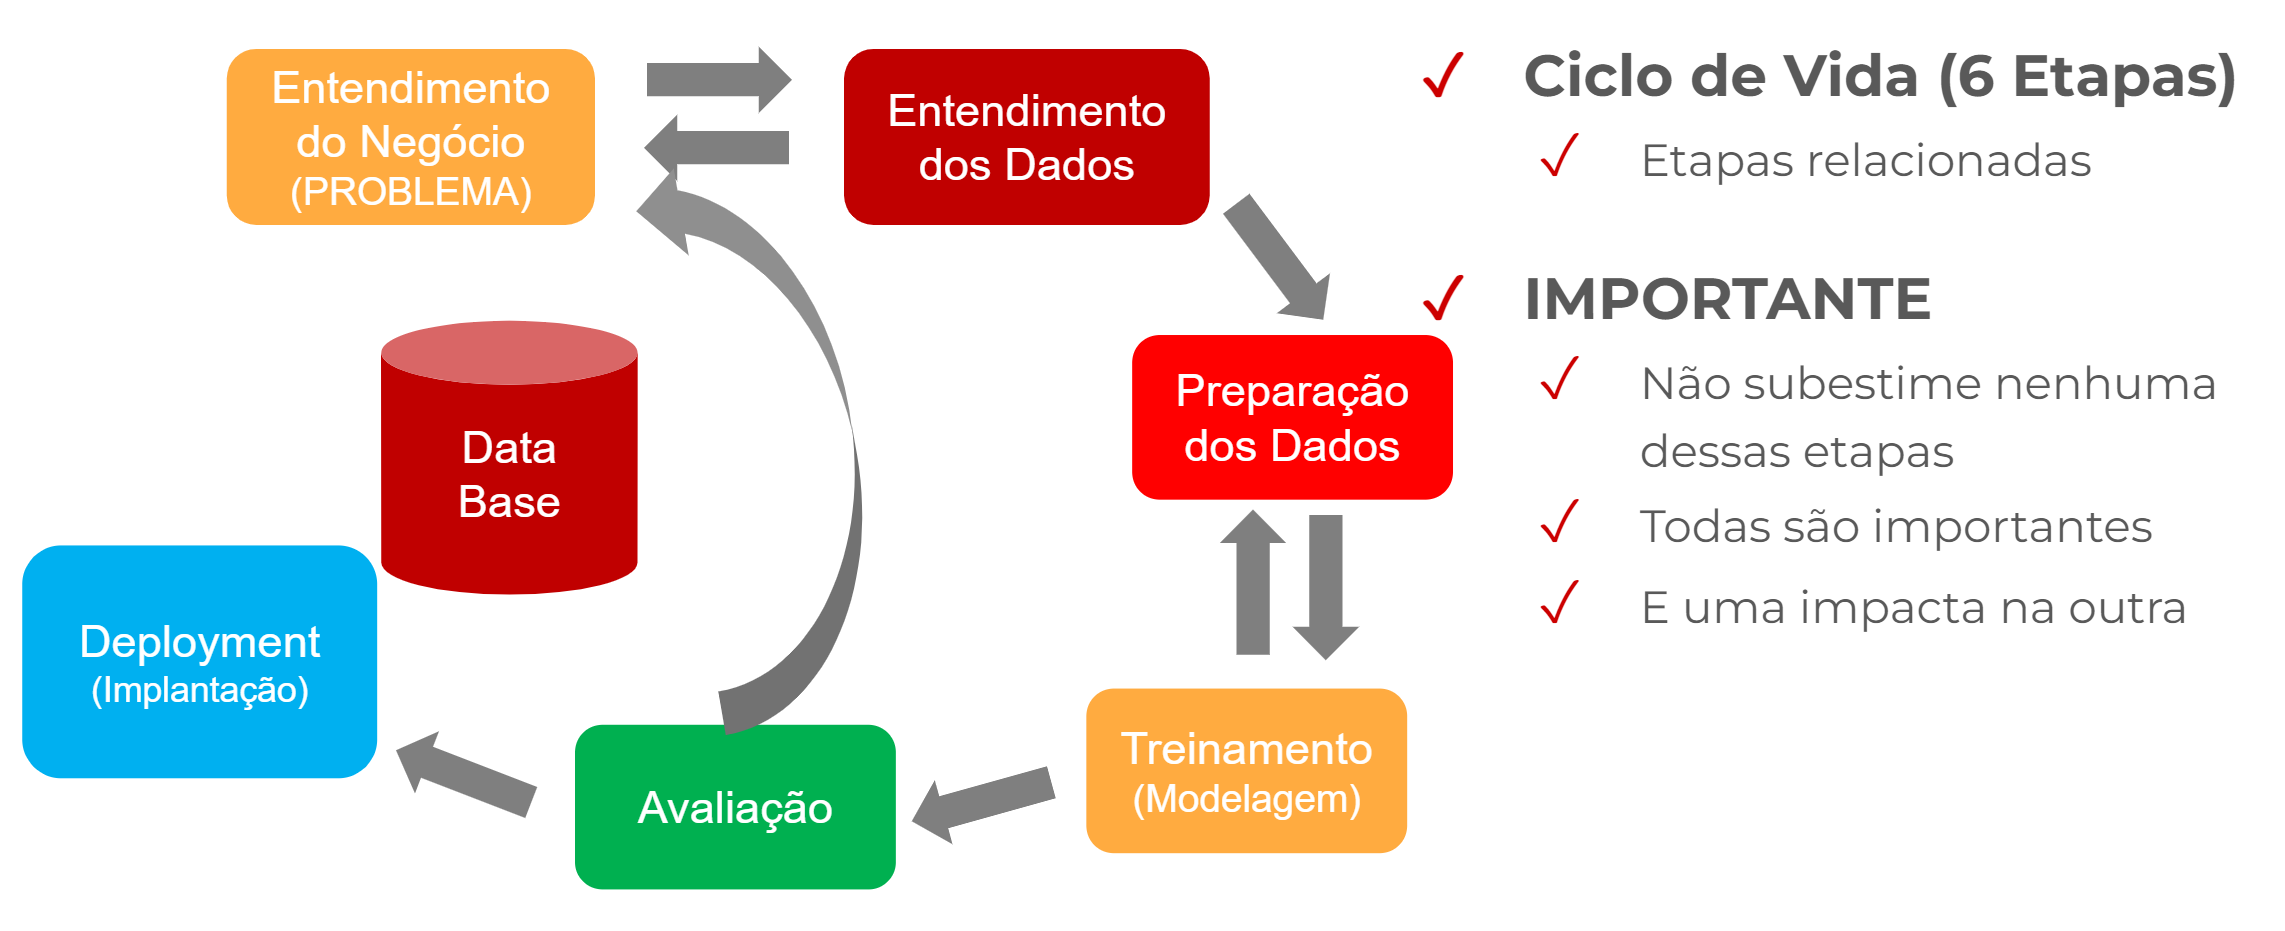

## **1. Entendimento do Problema**



## **2. Entendimento dos Dados**

“Why is the data collected in the first place? How was the data collected? What business rules, logic, or transformations have been applied to the data? Were these modifications applied during the data acquisition process or built into the systems that generate the data?”

Trecho de
Time Series Analysis with Python Cookbook
Tarek A. Atwan
https://itunes.apple.com/WebObjects/MZStore.woa/wa/viewBook?id=0
Este material pode estar protegido por copyright.

**(i) Por que os dados foram coletados?**

Prover informações meteorológicas para monitoramento, análise e previsão do tempo e clima com objetivo de formentar a produção brasileira. O INMET é ligado ao Ministério da Agricultura e Pecuária.

**(ii) Como os dados foram coletados?**

Através do Sistema de Coleta e Distribuição de Dados Meteorológicos do Instituto. Os dados utilizados nessa pesquisa são advindos de *estações meteorológicas automáticas*.




### 2.0 Import de bibliotecas

In [577]:
import pandas as pd
from pandas.plotting import lag_plot
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import os

### 2.1 Leitura dos Dados

Os dados advém do INMET através do endereço http://bancodedados.cptec.inpe.br

In [578]:
# Leitura do arquivo de configuração

# folder para carregar os config files
CONFIG_PATH = "config/"

# Função para carregar os dados
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

In [579]:
config = load_config("data_preprocessing_config_sobral.yaml")

# mostrar todas as colunas
pd.set_option("display.max_columns", None)

In [580]:
# Leitura dos dados a partir do CSV
codigo_wmo = config["input_data_parameters"]["codigo_wmo"]
estacao = config["input_data_parameters"]["estacao"]
data_inicial = config["input_data_parameters"]["data_inicial"]
data_final = config["input_data_parameters"]["data_final"]

input_dir = config["input_directory"]

filepath = f"{input_dir}/dados_{codigo_wmo}_{estacao}_H_{data_inicial}_{data_final}.csv"

df_original = pd.read_csv(
    filepath,
    header=config["header_line_number"],
    sep=";",
)

In [581]:
df_original.head()

Data Medicao  Hora Medicao  PRECIPITACAO TOTAL, HORARIO(mm)  \
0   2015-01-01             0                              0.0   
1   2015-01-01           100                              0.0   
2   2015-01-01           200                              0.0   
3   2015-01-01           300                              0.0   
4   2015-01-01           400                              0.0   

   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)  \
0                                             1002.5      
1                                             1002.6      
2                                             1002.7      
3                                             1002.1      
4                                             1001.7      

   PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)  \
0                                             1013.3    
1                                             1013.4    
2                                             1013.5    
3                                             1012.9    
4                                             1012.5    

   PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)  \
0                                          1002.5   
1                                          1002.7   
2                                          1003.0   
3                                          1002.7   
4                                          1002.1   

   PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)  RADIACAO GLOBAL(Kj/m²)  \
0                                           1001.8                    -3.5   
1                                           1002.4                    -3.5   
2                                           1002.6                    -3.5   
3                                           1002.1                    -3.5   
4                                           1001.7                    -3.5   

   TEMPERATURA DA CPU DA ESTACAO(°C)  \
0                               28.0   
1                               28.0   
2                               27.0   
3                               27.0   
4                               26.0   

   TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)  \
0                                         26.4   
1                                         25.9   
2                                         25.7   
3                                         25.2   
4                                         24.7   

   TEMPERATURA DO PONTO DE ORVALHO(°C)  \
0                                 21.2   
1                                 21.5   
2                                 21.6   
3                                 21.7   
4                                 21.7   

   TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)  \
0                                       27.1   
1                                       26.4   
2                                       25.9   
3                                       25.7   
4                                       25.2   

   TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)  \
0                                       26.4   
1                                       25.9   
2                                       25.7   
3                                       25.2   
4                                       24.7   

   TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(°C)  \
0                                             21.2   
1                                             21.5   
2                                             21.7   
3                                             21.7   
4                                             21.7   

   TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(°C)  \
0                                             21.0   
1                                             21.2   
2                                             21.5   
3                                             21.6   
4                                             21.6   

   TENSAO DA BATERIA DA ESTACAO(V)  UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)  \
0                      

Ajustamos o índice como combinação das duas primeira colunas e correção UTC

In [582]:
df = df_original.copy()

# Concatenação das colunas "Data Medicao" com formato "YYYY-MM-DD" e "Hora Medicao" com formato "100", "200"... e conversão de UTC para GMT-3
utc_offset = config["utc_offset"]
df["data"] = pd.to_datetime(df["Data Medicao"]) + pd.to_timedelta(
    df["Hora Medicao"] / 100 + utc_offset, unit="h"
)

# Retirada de n primeiras entradas (para não contar o ano anterior ao início da medida)
n_entradas = -utc_offset
df = df[n_entradas:]

# Retirada de colunas combinadas
df.drop(columns=["Hora Medicao", "Data Medicao"], inplace=True)

# Indexação da coluna "Data"
df.set_index("data", inplace=True)

In [583]:
df.head()

PRECIPITACAO TOTAL, HORARIO(mm)  \
data                                                   
2015-01-01 00:00:00                              0.0   
2015-01-01 01:00:00                              0.0   
2015-01-01 02:00:00                              0.0   
2015-01-01 03:00:00                              0.0   
2015-01-01 04:00:00                              0.0   

                     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)  \
data                                                                        
2015-01-01 00:00:00                                             1002.1      
2015-01-01 01:00:00                                             1001.7      
2015-01-01 02:00:00                                             1001.5      
2015-01-01 03:00:00                                             1001.5      
2015-01-01 04:00:00                                             1001.5      

                     PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)  \
data                                                                      
2015-01-01 00:00:00                                             1012.9    
2015-01-01 01:00:00                                             1012.5    
2015-01-01 02:00:00                                             1012.3    
2015-01-01 03:00:00                                             1012.3    
2015-01-01 04:00:00                                             1012.3    

                     PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)  \
data                                                                  
2015-01-01 00:00:00                                          1002.7   
2015-01-01 01:00:00                                          1002.1   
2015-01-01 02:00:00                                          1001.7   
2015-01-01 03:00:00                                          1001.6   
2015-01-01 04:00:00                                          1001.7   

                     PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)  \
data                                                                   
2015-01-01 00:00:00                                           1002.1   
2015-01-01 01:00:00                                           1001.7   
2015-01-01 02:00:00                                           1001.4   
2015-01-01 03:00:00                                           1001.4   
2015-01-01 04:00:00                                           1001.5   

                     RADIACAO GLOBAL(Kj/m²)  \
data                                          
2015-01-01 00:00:00                    -3.5   
2015-01-01 01:00:00                    -3.5   
2015-01-01 02:00:00                    -3.4   
2015-01-01 03:00:00                    -3.5   
2015-01-01 04:00:00                    -3.5   

                     TEMPERATURA DA CPU DA ESTACAO(°C)  \
data                                                     
2015-01-01 00:00:00                               27.0   
2015-01-01 01:00:00                               26.0   
2015-01-01 02:00:00                               26.0   
2015-01-01 03:00:00                               26.0   
2015-01-01 04:00:00                               25.0   

                     TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)  \
data                                                               
2015-01-01 00:00:00                                         25.2   
2015-01-01 01:00:00                                         24.7   
2015-01-01 02:00:00                                         24.6   
2015-01-01 03:00:00                                         24.4   
2015-01-01 04:00:00                                         24.2   

                     TEMPERATURA DO PONTO DE ORVALHO(°C)  \
data                                                       
2015-01-01 00:00:00                                 21.7   
2015-01-01 01:00:00                                 21.7   
2015-01-01 02:00:00                                 21.7   
2015-01-01 03:00:00                          

Check dos data types das colunas e ideia inicial de dados faltantes

In [584]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84741 entries, 2015-01-01 00:00:00 to 2024-08-31 20:00:00
Data columns (total 21 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   PRECIPITACAO TOTAL, HORARIO(mm)                       54760 non-null  float64
 1   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)  64937 non-null  float64
 2   PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)    61721 non-null  float64
 3   PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)        64892 non-null  float64
 4   PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)       64892 non-null  float64
 5   RADIACAO GLOBAL(Kj/m²)                                64834 non-null  float64
 6   TEMPERATURA DA CPU DA ESTACAO(°C)                     64938 non-null  float64
 7   TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)           61722 non-null  float64
 8   TEMPERATURA DO PONTO 

In [585]:
df.columns

Index(['PRECIPITACAO TOTAL, HORARIO(mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)',
       'PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)',
       'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)',
       'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)',
       'RADIACAO GLOBAL(Kj/m²)', 'TEMPERATURA DA CPU DA ESTACAO(°C)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)',
       'TEMPERATURA DO PONTO DE ORVALHO(°C)',
       'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)',
       'TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(°C)',
       'TENSAO DA BATERIA DA ESTACAO(V)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)',
       'UMIDADE RELATIVA DO AR, HORARIA(%)',
       'VENTO, DIRECAO HORARIA (gr)(° (gr))', 'VENTO, RAJADA MAXIMA(m/s)',
       'VENTO, VELOCIDADE HORARIA(m/s)', 'Unnamed: 22'],
      dtyp

### 2.2. Reindexacão

In [586]:
# Reindexacão
freq = config["resample_freq"]
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
df = df.reindex(idx)

# Remove Unnamed columns
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

In [587]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84741 entries, 2015-01-01 00:00:00 to 2024-08-31 20:00:00
Freq: H
Data columns (total 20 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   PRECIPITACAO TOTAL, HORARIO(mm)                       54760 non-null  float64
 1   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)  64937 non-null  float64
 2   PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)    61721 non-null  float64
 3   PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)        64892 non-null  float64
 4   PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)       64892 non-null  float64
 5   RADIACAO GLOBAL(Kj/m²)                                64834 non-null  float64
 6   TEMPERATURA DA CPU DA ESTACAO(°C)                     64938 non-null  float64
 7   TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)           61722 non-null  float64
 8   TEMPERATURA D

In [588]:
df.head()

PRECIPITACAO TOTAL, HORARIO(mm)  \
2015-01-01 00:00:00                              0.0   
2015-01-01 01:00:00                              0.0   
2015-01-01 02:00:00                              0.0   
2015-01-01 03:00:00                              0.0   
2015-01-01 04:00:00                              0.0   

                     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)  \
2015-01-01 00:00:00                                             1002.1      
2015-01-01 01:00:00                                             1001.7      
2015-01-01 02:00:00                                             1001.5      
2015-01-01 03:00:00                                             1001.5      
2015-01-01 04:00:00                                             1001.5      

                     PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)  \
2015-01-01 00:00:00                                             1012.9    
2015-01-01 01:00:00                                             1012.5    
2015-01-01 02:00:00                                             1012.3    
2015-01-01 03:00:00                                             1012.3    
2015-01-01 04:00:00                                             1012.3    

                     PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)  \
2015-01-01 00:00:00                                          1002.7   
2015-01-01 01:00:00                                          1002.1   
2015-01-01 02:00:00                                          1001.7   
2015-01-01 03:00:00                                          1001.6   
2015-01-01 04:00:00                                          1001.7   

                     PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)  \
2015-01-01 00:00:00                                           1002.1   
2015-01-01 01:00:00                                           1001.7   
2015-01-01 02:00:00                                           1001.4   
2015-01-01 03:00:00                                           1001.4   
2015-01-01 04:00:00                                           1001.5   

                     RADIACAO GLOBAL(Kj/m²)  \
2015-01-01 00:00:00                    -3.5   
2015-01-01 01:00:00                    -3.5   
2015-01-01 02:00:00                    -3.4   
2015-01-01 03:00:00                    -3.5   
2015-01-01 04:00:00                    -3.5   

                     TEMPERATURA DA CPU DA ESTACAO(°C)  \
2015-01-01 00:00:00                               27.0   
2015-01-01 01:00:00                               26.0   
2015-01-01 02:00:00                               26.0   
2015-01-01 03:00:00                               26.0   
2015-01-01 04:00:00                               25.0   

                     TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)  \
2015-01-01 00:00:00                                         25.2   
2015-01-01 01:00:00                                         24.7   
2015-01-01 02:00:00                                         24.6   
2015-01-01 03:00:00                                         24.4   
2015-01-01 04:00:00                                         24.2   

                     TEMPERATURA DO PONTO DE ORVALHO(°C)  \
2015-01-01 00:00:00                                 21.7   
2015-01-01 01:00:00                                 21.7   
2015-01-01 02:00:00                                 21.7   
2015-01-01 03:00:00                                 21.6   
2015-01-01 04:00:00                                 21.5   

                     TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)  \
2015-01-01 00:00:00                                       25.7   
2015-01-01 01:00:00                                       25.2   
2015-01-01 02:00:00                                       24.7   
2015-01-01 03:00:00                                       24.8   
2015-01-01 04:00:00                                       24.4   

                     TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)  \
2015-01-01 00:00:00                          

**Observações:**

- Todos os tipos de dados parecem condizentes
- Frequência horária
- Temos um número coerente de entradas (índice parece não ter valores faltantes)
- temos dados faltantes para todas as colunas. Posteriormente trataremos

### 2.3. Ajuste dos nomes das colunas e ordem das colunas

In [589]:
# Função para transformar o nome da coluna
def transformar_nome_coluna(coluna):
    # Converte para minúsculas
    coluna = coluna.lower()
    # Remove acentos
    coluna = (
        coluna.replace("ç", "c")
        .replace("ã", "a")
        .replace("á", "a")
        .replace("é", "e")
        .replace("ó", "o")
        .replace("í", "i")
    )
    # Remove preposições
    coluna = (
        coluna.replace(" de ", "_")
        .replace(" da ", "_")
        .replace(" do ", "_")
        .replace(" dos ", "_")
        .replace(" das ", "_")
        .replace(" no ", "_")
        .replace(" na ", "_")
        .replace(" nos ", "_")
        .replace(" nas ", "_")
        .replace(" ao ", "_")
        .replace(".na", "_")
        .replace(" em ", "_")
        .replace(" e ", "_")
        .replace(" a ", "_")
        .replace(" o ", "_")
        .replace(" as ", "_")
        .replace(" os ", "_")
    )
    # Remove unidades e parênteses
    coluna = coluna.split("(")[0]
    # Remove caracteres especiais e substitui espaços por underscores
    coluna = (
        coluna.replace(" ", "_")
        .replace(",", "")
        .replace("-", "_")
        .replace(".", "")
    )
    # Remove underscores duplicados
    coluna = "_".join([part for part in coluna.split("_") if part])
    return coluna

In [590]:
# Aplica a função em todas as colunas
colunas_originais = df.columns
colunas_transformadas = [
    transformar_nome_coluna(coluna) for coluna in colunas_originais
]

# Identifica e extrai a coluna de radiação
coluna_radiacao = [
    coluna for coluna in colunas_transformadas if "radiacao" in coluna
][0]

# Renomeia as colunas do DataFrame
df.columns = colunas_transformadas

# Salva a série coluna_radiacao
coluna_radiacao_serie = df[coluna_radiacao]

# Remove a coluna de radiação do DataFrame
df = df.drop(columns=[coluna_radiacao])

# Adiciona a coluna de radiação de volta ao final
df[coluna_radiacao] = coluna_radiacao_serie

In [591]:
df.head()

precipitacao_total_horario  \
2015-01-01 00:00:00                         0.0   
2015-01-01 01:00:00                         0.0   
2015-01-01 02:00:00                         0.0   
2015-01-01 03:00:00                         0.0   
2015-01-01 04:00:00                         0.0   

                     pressao_atmosferica_nivel_estacao_horaria  \
2015-01-01 00:00:00                                     1002.1   
2015-01-01 01:00:00                                     1001.7   
2015-01-01 02:00:00                                     1001.5   
2015-01-01 03:00:00                                     1001.5   
2015-01-01 04:00:00                                     1001.5   

                     pressao_atmosferica_reduzida_nivel_mar_aut  \
2015-01-01 00:00:00                                      1012.9   
2015-01-01 01:00:00                                      1012.5   
2015-01-01 02:00:00                                      1012.3   
2015-01-01 03:00:00                                      1012.3   
2015-01-01 04:00:00                                      1012.3   

                     pressao_atmosferica_max_hora_ant  \
2015-01-01 00:00:00                            1002.7   
2015-01-01 01:00:00                            1002.1   
2015-01-01 02:00:00                            1001.7   
2015-01-01 03:00:00                            1001.6   
2015-01-01 04:00:00                            1001.7   

                     pressao_atmosferica_min_hora_ant  \
2015-01-01 00:00:00                            1002.1   
2015-01-01 01:00:00                            1001.7   
2015-01-01 02:00:00                            1001.4   
2015-01-01 03:00:00                            1001.4   
2015-01-01 04:00:00                            1001.5   

                     temperatura_cpu_estacao  \
2015-01-01 00:00:00                     27.0   
2015-01-01 01:00:00                     26.0   
2015-01-01 02:00:00                     26.0   
2015-01-01 03:00:00                     26.0   
2015-01-01 04:00:00                     25.0   

                     temperatura_ar_bulbo_seco_horaria  \
2015-01-01 00:00:00                               25.2   
2015-01-01 01:00:00                               24.7   
2015-01-01 02:00:00                               24.6   
2015-01-01 03:00:00                               24.4   
2015-01-01 04:00:00                               24.2   

                     temperatura_ponto_orvalho  temperatura_maxima_hora_ant  \
2015-01-01 00:00:00                       21.7                         25.7   
2015-01-01 01:00:00                       21.7                         25.2   
2015-01-01 02:00:00                       21.7                         24.7   
2015-01-01 03:00:00                       21.6                         24.8   
2015-01-01 04:00:00                       21.5                         24.4   

                     temperatura_minima_hora_ant  \
2015-01-01 00:00:00                         25.2   
2015-01-01 01:00:00                         24.7   
2015-01-01 02:00:00                         24.5   
2015-01-01 03:00:00                         24.4   
2015-01-01 04:00:00                         24.2   

                     temperatura_orvalho_max_hora_ant  \
2015-01-01 00:00:00                              21.7   
2015-01-01 01:00:00                              21.7   
2015-01-01 02:00:00                              21.8   
2015-01-01 03:00:00                              21.8   
2015-01-01 04:00:00                              21.7   

                     temperatura_orvalho_min_hora_ant  tensao_bateria_estacao  \
2015-01-01 00:00:00                              21.6                    12.3   
2015-01-01 01:00:00                              21.6                    12.2   
2015-01-01 02:00:00                              21.6                    12.2   
2015-01-01 03:00:00                              21.6                    12.2   
2015-01-01 04:00:00                              21.5 

In [592]:
## coluna temperatura_ponto_orvalho após coluna temperatura_minima_hora_ant
# Identifica a posição da coluna 'temperatura_minima_hora_ant'
colunas = df.columns.tolist()
indice = colunas.index('temperatura_minima_hora_ant')

# Insere a coluna 'temperatura_ponto_orvalho' após 'temperatura_minima_hora_ant'
# Remove a coluna existente primeiro, se já estiver no DataFrame
coluna_orvalho = df.pop('temperatura_ponto_orvalho')

# Inserir a coluna na nova posição (índice + 1)
df.insert(indice, 'temperatura_ponto_orvalho', coluna_orvalho)

In [593]:
df.head()

precipitacao_total_horario  \
2015-01-01 00:00:00                         0.0   
2015-01-01 01:00:00                         0.0   
2015-01-01 02:00:00                         0.0   
2015-01-01 03:00:00                         0.0   
2015-01-01 04:00:00                         0.0   

                     pressao_atmosferica_nivel_estacao_horaria  \
2015-01-01 00:00:00                                     1002.1   
2015-01-01 01:00:00                                     1001.7   
2015-01-01 02:00:00                                     1001.5   
2015-01-01 03:00:00                                     1001.5   
2015-01-01 04:00:00                                     1001.5   

                     pressao_atmosferica_reduzida_nivel_mar_aut  \
2015-01-01 00:00:00                                      1012.9   
2015-01-01 01:00:00                                      1012.5   
2015-01-01 02:00:00                                      1012.3   
2015-01-01 03:00:00                                      1012.3   
2015-01-01 04:00:00                                      1012.3   

                     pressao_atmosferica_max_hora_ant  \
2015-01-01 00:00:00                            1002.7   
2015-01-01 01:00:00                            1002.1   
2015-01-01 02:00:00                            1001.7   
2015-01-01 03:00:00                            1001.6   
2015-01-01 04:00:00                            1001.7   

                     pressao_atmosferica_min_hora_ant  \
2015-01-01 00:00:00                            1002.1   
2015-01-01 01:00:00                            1001.7   
2015-01-01 02:00:00                            1001.4   
2015-01-01 03:00:00                            1001.4   
2015-01-01 04:00:00                            1001.5   

                     temperatura_cpu_estacao  \
2015-01-01 00:00:00                     27.0   
2015-01-01 01:00:00                     26.0   
2015-01-01 02:00:00                     26.0   
2015-01-01 03:00:00                     26.0   
2015-01-01 04:00:00                     25.0   

                     temperatura_ar_bulbo_seco_horaria  \
2015-01-01 00:00:00                               25.2   
2015-01-01 01:00:00                               24.7   
2015-01-01 02:00:00                               24.6   
2015-01-01 03:00:00                               24.4   
2015-01-01 04:00:00                               24.2   

                     temperatura_maxima_hora_ant  temperatura_minima_hora_ant  \
2015-01-01 00:00:00                         25.7                         25.2   
2015-01-01 01:00:00                         25.2                         24.7   
2015-01-01 02:00:00                         24.7                         24.5   
2015-01-01 03:00:00                         24.8                         24.4   
2015-01-01 04:00:00                         24.4                         24.2   

                     temperatura_ponto_orvalho  \
2015-01-01 00:00:00                       21.7   
2015-01-01 01:00:00                       21.7   
2015-01-01 02:00:00                       21.7   
2015-01-01 03:00:00                       21.6   
2015-01-01 04:00:00                       21.5   

                     temperatura_orvalho_max_hora_ant  \
2015-01-01 00:00:00                              21.7   
2015-01-01 01:00:00                              21.7   
2015-01-01 02:00:00                              21.8   
2015-01-01 03:00:00                              21.8   
2015-01-01 04:00:00                              21.7   

                     temperatura_orvalho_min_hora_ant  tensao_bateria_estacao  \
2015-01-01 00:00:00                              21.6                    12.3   
2015-01-01 01:00:00                              21.6                    12.2   
2015-01-01 02:00:00                              21.6                    12.2   
2015-01-01 03:00:00                              21.6                    12.2   
2015-01-01 04:00:00                              21.5 

### 2.4. Heatmap com dados ausentes

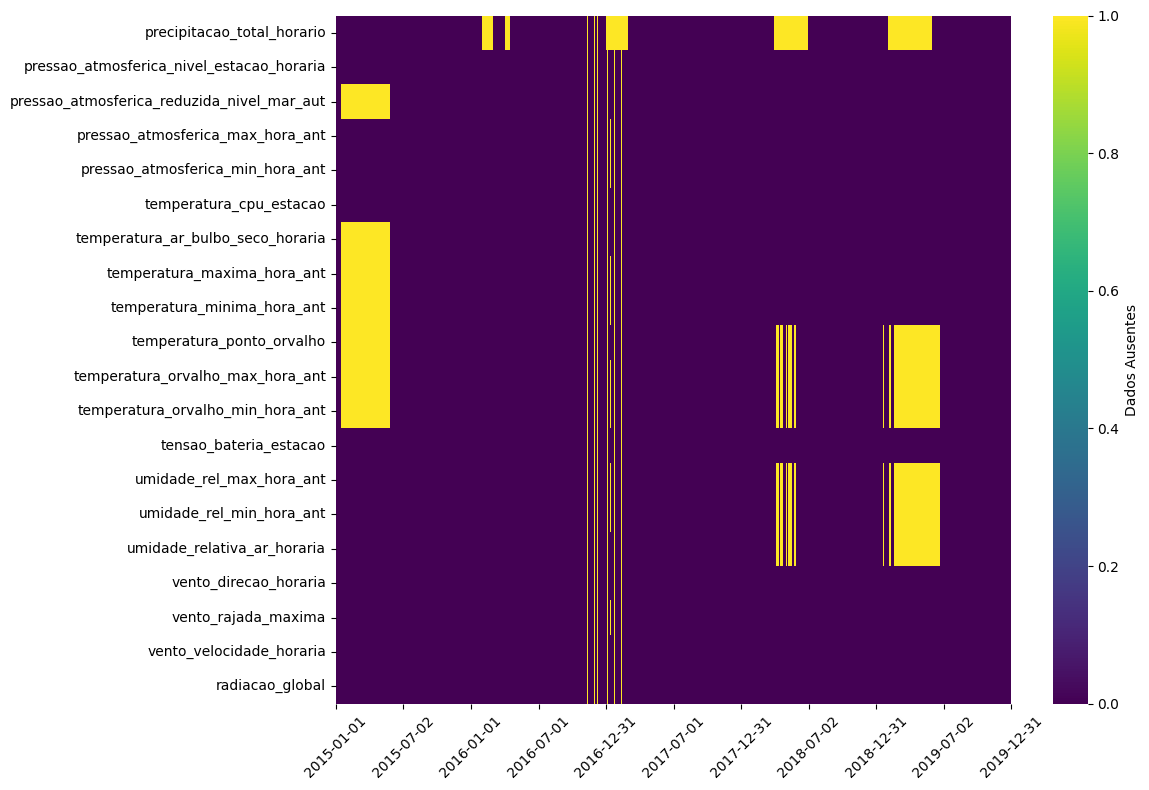

In [594]:
# Criar um dataframe booleano: True se o valor está ausente, False caso contrário
missing_data = df.loc["2015-01-01":"2019-12-31"].isnull()

# Configurar os ticks para o eixo X
date_index = missing_data.index
tick_positions = range(0, len(date_index), len(date_index) // 10)  # Exibe ~10 ticks espaçados
tick_labels = [date_index[i].strftime('%Y-%m-%d') for i in tick_positions]

# Criar um gráfico de calor para visualizar os valores ausentes
plt.figure(figsize=(12, 8))
sns.heatmap(
    missing_data.T,
    cbar_kws={'label': 'Dados Ausentes'},
    cmap="viridis",
    xticklabels=tick_positions, 
    yticklabels=df.columns,
)

# Adicionar os rótulos personalizados no eixo X
plt.xticks(tick_positions, tick_labels, rotation=45, fontsize=10)

# plt.title("Distribuição de Valores Ausentes ao Longo do Tempo", fontsize=14)
# plt.xlabel("Tempo (horas)", fontsize=12)
# plt.ylabel("Variáveis", fontsize=12)
plt.tight_layout()
plt.show()

### 2.5 Descrição das variáveis estudadas

| **Variável**                              | **Descrição (INMET)**                                                                 | **Unidade**         | **Explicação**                                                                          |
|-------------------------------------------|---------------------------------------------------------------------------------|---------------------|------------------------------------------------------------------------------------------|
| `precipitacao_total_horario`              | É a medida total de precipitação (chuva), ocorrida na última hora antes de cada mensagem de dados     | milímetros (mm)      | Reflete a intensidade das chuvas durante o período.                                       |
| `pressao_atmosferica_nivel_estacao_horaria` | É a medida média da pressão atmosférica, também ao nível da estação, ocorrida na última hora antes de cada mensagem de dados | milibares (mB)    | Esta é a pressão real no local da estação.                                                |
| `pressao_atmosferica_reduzida_nivel_mar_aut` | Pressão atmosférica média do nível do mar, normalmente determinada a partir da pressão da estação em que é observada.                               | milibares (mB)       | Remove o efeito da altitude, permitindo comparações globais.                              |
| `pressao_atmosferica_max_hora_ant` | Medida da pressão atmosférica máxima, ocorrida na última hora antes de cada mensagem de dados.                      | milibares (mB)       | Indica a maior pressão atmosférica observada na hora anterior.                            |
| `pressao_atmosferica_min_hora_ant` | Medida da pressão atmosférica mínima, ocorrida na última hora antes de cada mensagem de dados                      | milibares (mB)       | Representa a menor pressão atmosférica observada na hora anterior.                        |
| `temperatura_cpu_estacao`           | Temperatura do processador (CPU) da estação meteorológica (não há no glossário INMET)                      | graus Celsius (°C)   | Garante o funcionamento adequado do equipamento da estação.                               |
| `temperatura_ar_bulbo_seco_horaria`    | Medida média da temperatura do ar, ocorrida na última hora antes de cada mensagem de dados                         | graus Celsius (°C)   | É a temperatura do ar ambiente sem influências de umidade.                                |
| `temperatura_maxima_hora_ant`      | Medida máxima da temperatura do ar, ocorrida na última hora antes de cada mensagem de dados                                 | graus Celsius (°C)   | Reflete a maior temperatura observada durante a hora anterior.                            |
| `temperatura_minima_hora_ant`      | Medida mínima da temperatura do ar, ocorrida na última hora antes de cada mensagem de dados                                 | graus Celsius (°C)   | Reflete a menor temperatura observada durante a hora anterior.                            |
| `temperatura_ponto_orvalho`         | Nas estações automáticas este parâmetro é calculado a partir dos valores de temperatura do ar e da umidade relativa, ocorridos na última hora antes de cada mensagem de dados          | graus Celsius (°C)   | Indica a umidade do ar.                                                                   |
| `temperatura_orvalho_max_hora_ant` | Nas estações automáticas este parâmetro é calculado a partir dos valores máximos de temperatura do ar e da umidade relativa, ocorridos na última hora antes de cada mensagem de dados.              | graus Celsius (°C)   | Maior temperatura em que ocorreu condensação na hora anterior.                            |
| `temperatura_orvalho_min_hora_ant` | Nas estações automáticas este parâmetro é calculado a partir dos valores mínimos de temperatura do ar e da umidade relativa, ocorridos na última hora antes de cada mensagem de dados.             | graus Celsius (°C)   | Menor temperatura em que houve condensação na hora anterior.                              |
| `tensao_bateria_estacao`                  | Tensão elétrica da bateria da estação meteorológica (não disponível no glossário do INMET)                            | volts (V)            | Monitora o estado de energia da estação.                                                  |
| `umidade_rel_max_hora_ant`         | Medida máxima da umidade relativa do ar, ocorrida na última hora antes de cada mensagem de dados                            | porcentagem (%)      | Reflete o maior nível de saturação de vapor d'água no ar na hora anterior.                |
| `umidade_rel_min_hora_ant`         | Medida mínima da umidade relativa do ar, ocorrida na última hora antes de cada mensagem de dados                            | porcentagem (%)      | Reflete o menor nível de saturação de vapor d'água no ar na hora anterior.                |
| `umidade_relativa_ar_horaria`          | Medida da umidade relativa do ar, ocorrida na última hora antes de cada mensagem de dados                                   | porcentagem (%)      | Indica a quantidade de vapor d'água presente no ar em comparação ao máximo que ele pode conter. |
| `vento_direcao_horaria`                   | Medida em graus angulares da direção do vento (de onde o vento vem). Este valor é a média dos últimos 10 minutos antes de cada hora, de envio da mensagem de dados                                         | graus (°)            | Indica de qual direção o vento está soprando (0°: norte, 90°: leste, 180°: sul, 270°: oeste). |
| `vento_rajada_maxima`                     | Medida máxima da velocidade do vento, ocorrida na última hora antes de cada mensagem de dados       | metros por segundo (m/s) | Reflete a maior intensidade de vento em rajadas.                                           |
| `vento_velocidade_horaria`                | Medida da velocidade do vento. Este valor é a média dos últimos 10 minutos antes de cada hora, de envio da mensagem de dados                  | metros por segundo (m/s) | Representa a intensidade do vento durante o período.                                      |
| `radiacao_global`                         | Medida de toda radiação solar que chegou a superfície terrestre, na última hora antes de cada mensagem de dados.             | kilojoules por metro quadrado (Kj/m²) | Representa a energia total do sol atingindo o solo.                                        |


OBS.: "A integral da irradiância no tempo é definida como irradiação solar ou radiação solar incidente ou energia radiante incidente acumulada em um intervalo de tempo e tem como unidade de medida padrão Wh/m2. Neste trabalho, utilizou-se a nomenclatura Irradiação Solar e a notação estabelecida pelo INMET, já que os dados dessa variável foram disponibilizados em kJ/m2. Para efeito comparativo, o valor de 1 Wh (medida padrão) é equivalente a 3,6 · 103J = 3600J = 3,6kJ"

## **3. Preparação dos Dados**

### 3.1. Check de Sanidade - Tratamento de Dados Errôneos (Valores Extremos / Impossíveis)

Check de tipos de dados

In [595]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84741 entries, 2015-01-01 00:00:00 to 2024-08-31 20:00:00
Freq: H
Data columns (total 20 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   precipitacao_total_horario                  54760 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria   64937 non-null  float64
 2   pressao_atmosferica_reduzida_nivel_mar_aut  61721 non-null  float64
 3   pressao_atmosferica_max_hora_ant            64892 non-null  float64
 4   pressao_atmosferica_min_hora_ant            64892 non-null  float64
 5   temperatura_cpu_estacao                     64938 non-null  float64
 6   temperatura_ar_bulbo_seco_horaria           61722 non-null  float64
 7   temperatura_maxima_hora_ant                 61677 non-null  float64
 8   temperatura_minima_hora_ant                 61677 non-null  float64
 9   temperatura_ponto_orvalho               

Vemos que todas as colunas têm o tipo de dado correto, logo não temos strings no meio das colunas numéricas

In [596]:
df_sanitized = df.copy()

# precipitacao não pode ser menor que zero (valor máximo não conclusivo)
min_precipitation = config["min_precipitation"]
df_sanitized.loc[
    (df_sanitized["precipitacao_total_horario"] < min_precipitation),
    "precipitacao_total_horario",
] = np.nan

# Cálculo de qtde de valores trocados
precipitacao_total_horario_san = (
    df_sanitized["precipitacao_total_horario"].isna().sum()
    - df["precipitacao_total_horario"].isna().sum()
)


# pressao atmosferica em mB não pode ser menor que 880 (pressão estimada para ponto mais alto do estado - 1160m - Pico da Serra Branca) nem maior que 1200 - trocar por nulo
min_atm_pressure = config["min_atm_pressure"]
max_atm_pressure = config["max_atm_pressure"]
df_sanitized.loc[
    (
        df_sanitized["pressao_atmosferica_nivel_estacao_horaria"]
        < min_atm_pressure
    )
    | (
        df_sanitized["pressao_atmosferica_nivel_estacao_horaria"]
        > max_atm_pressure
    ),
    "pressao_atmosferica_nivel_estacao_horaria",
] = np.nan

# Cálculo de qtde de valores trocados
pressao_atmosferica_nivel_estacao_horaria_san = (
    df_sanitized["pressao_atmosferica_nivel_estacao_horaria"].isna().sum()
    - df["pressao_atmosferica_nivel_estacao_horaria"].isna().sum()
)


df_sanitized.loc[
    (
        df_sanitized["pressao_atmosferica_reduzida_nivel_mar_aut"]
        < min_atm_pressure
    )
    | (
        df_sanitized["pressao_atmosferica_reduzida_nivel_mar_aut"]
        > max_atm_pressure
    ),
    "pressao_atmosferica_reduzida_nivel_mar_aut",
] = np.nan

pressao_atmosferica_reduzida_nivel_mar_aut_san = (
    df_sanitized["pressao_atmosferica_reduzida_nivel_mar_aut"].isna().sum()
    - df["pressao_atmosferica_reduzida_nivel_mar_aut"].isna().sum()
)


df_sanitized.loc[
    (df_sanitized["pressao_atmosferica_max_hora_ant"] < min_atm_pressure)
    | (df_sanitized["pressao_atmosferica_max_hora_ant"] > max_atm_pressure),
    "pressao_atmosferica_max_hora_ant",
] = np.nan

pressao_atmosferica_reduzida_nivel_mar_aut_san = (
    df_sanitized["pressao_atmosferica_max_hora_ant"].isna().sum()
    - df["pressao_atmosferica_max_hora_ant"].isna().sum()
)


df_sanitized.loc[
    (df_sanitized["pressao_atmosferica_min_hora_ant"] < min_atm_pressure)
    | (df_sanitized["pressao_atmosferica_min_hora_ant"] > max_atm_pressure),
    "pressao_atmosferica_min_hora_ant",
] = np.nan

pressao_atmosferica_reduzida_nivel_mar_aut_san = (
    df_sanitized["pressao_atmosferica_min_hora_ant"].isna().sum()
    - df["pressao_atmosferica_min_hora_ant"].isna().sum()
)


# sanidade temperatura CPU da estação
min_cpu_temp = config["min_cpu_temp"]
max_cpu_temp = config["max_cpu_temp"]
df_sanitized.loc[
    (df_sanitized["temperatura_cpu_estacao"] < min_cpu_temp)
    | (df_sanitized["temperatura_cpu_estacao"] > max_cpu_temp),
    "temperatura_cpu_estacao",
] = np.nan

# qtde de valores trocados
temperatura_cpu_estacao_san = (
    df_sanitized["temperatura_cpu_estacao"].isna().sum()
    - df["temperatura_cpu_estacao"].isna().sum()
)


# temperatura não deve ser menor que 11 graus (temperatura mínima do estado) nem maior que 42 graus (temperatura máxima do estado) - trocar por nulo
min_air_temp = config["min_air_temp"]
max_air_temp = config["max_air_temp"]
df_sanitized.loc[
    (df_sanitized["temperatura_ar_bulbo_seco_horaria"] < min_air_temp)
    | (df_sanitized["temperatura_ar_bulbo_seco_horaria"] > max_air_temp),
    "temperatura_ar_bulbo_seco_horaria",
] = np.nan

temperatura_ar_bulbo_seco_horaria_san = (
    df_sanitized["temperatura_ar_bulbo_seco_horaria"].isna().sum()
    - df["temperatura_ar_bulbo_seco_horaria"].isna().sum()
)


df_sanitized.loc[
    (df_sanitized["temperatura_maxima_hora_ant"] < min_air_temp)
    | (df_sanitized["temperatura_maxima_hora_ant"] > max_air_temp),
    "temperatura_maxima_hora_ant",
] = np.nan

temperatura_maxima_hora_ant_san = (
    df_sanitized["temperatura_maxima_hora_ant"].isna().sum()
    - df["temperatura_maxima_hora_ant"].isna().sum()
)


df_sanitized.loc[
    (df_sanitized["temperatura_minima_hora_ant"] < min_air_temp)
    | (df_sanitized["temperatura_minima_hora_ant"] > max_air_temp),
    "temperatura_minima_hora_ant",
] = np.nan

temperatura_minima_hora_ant_san = (
    df_sanitized["temperatura_minima_hora_ant"].isna().sum()
    - df["temperatura_minima_hora_ant"].isna().sum()
)


# temperatura do ponto de orvalho não deve ser menor que -20 graus (temperatura e umidades mínimas do estado) e maior do que 42 graus (temperatura máxima do estado) - trocar por nulo
# cálculo segundo https://meteorologia.unifei.edu.br/pag/ponto_orvalho/
min_dew_temp = config["min_dew_temp"]
max_dew_temp = config["max_dew_temp"]
df_sanitized.loc[
    (df_sanitized["temperatura_ponto_orvalho"] < min_dew_temp)
    | (df_sanitized["temperatura_ponto_orvalho"] > max_dew_temp),
    "temperatura_ponto_orvalho",
] = np.nan

temperatura_ponto_orvalho_san = (
    df_sanitized["temperatura_ponto_orvalho"].isna().sum()
    - df["temperatura_ponto_orvalho"].isna().sum()
)


df_sanitized.loc[
    (df_sanitized["temperatura_orvalho_max_hora_ant"] < min_dew_temp)
    | (df_sanitized["temperatura_orvalho_max_hora_ant"] > max_dew_temp),
    "temperatura_orvalho_max_hora_ant",
] = np.nan

temperatura_orvalho_max_hora_ant_san = (
    df_sanitized["temperatura_orvalho_max_hora_ant"].isna().sum()
    - df["temperatura_orvalho_max_hora_ant"].isna().sum()
)


df_sanitized.loc[
    (df_sanitized["temperatura_orvalho_min_hora_ant"] < min_dew_temp)
    | (df_sanitized["temperatura_orvalho_min_hora_ant"] > max_dew_temp),
    "temperatura_orvalho_min_hora_ant",
] = np.nan

temperatura_orvalho_min_hora_ant_san = (
    df_sanitized["temperatura_orvalho_min_hora_ant"].isna().sum()
    - df["temperatura_orvalho_min_hora_ant"].isna().sum()
)


# umidade relativa não deve ser menor que 0% nem maior que 100% - trocar por nulo
min_rel_humidity = config["min_rel_humidity"]
max_rel_humidity = config["max_rel_humidity"]
df_sanitized.loc[
    (df_sanitized["umidade_rel_max_hora_ant"] < min_rel_humidity)
    | (df_sanitized["umidade_rel_max_hora_ant"] > max_rel_humidity),
] = np.nan

umidade_rel_max_hora_ant_san = (
    df_sanitized["umidade_rel_max_hora_ant"].isna().sum()
    - df["umidade_rel_max_hora_ant"].isna().sum()
)


df_sanitized.loc[
    (df_sanitized["umidade_rel_min_hora_ant"] < min_rel_humidity)
    | (df_sanitized["umidade_rel_min_hora_ant"] > max_rel_humidity),
] = np.nan

umidade_rel_min_hora_ant_san = (
    df_sanitized["umidade_rel_min_hora_ant"].isna().sum()
    - df["umidade_rel_min_hora_ant"].isna().sum()
)


df_sanitized.loc[
    (df_sanitized["umidade_relativa_ar_horaria"] < min_rel_humidity)
    | (df_sanitized["umidade_relativa_ar_horaria"] > max_rel_humidity),
    "umidade_relativa_ar_horaria",
] = np.nan

umidade_relativa_ar_horaria_san = (
    df_sanitized["umidade_relativa_ar_horaria"].isna().sum()
    - df["umidade_relativa_ar_horaria"].isna().sum()
)


# direção do vento não deve ser menor que 0 graus nem maior que 360 graus - trocar por nulo
min_wind_dir = config["min_wind_dir"]
max_wind_dir = config["max_wind_dir"]
df_sanitized.loc[
    (df_sanitized["vento_direcao_horaria"] < min_wind_dir)
    | (df_sanitized["vento_direcao_horaria"] > max_wind_dir),
    "vento_direcao_horaria",
] = np.nan

vento_direcao_horaria_san = (
    df_sanitized["vento_direcao_horaria"].isna().sum()
    - df["vento_direcao_horaria"].isna().sum()
)


# velocidade do vento não deve ser menor que 0 m/s nem maior que 114 m/s (maior valor já obtido no mundo) - trocar por nulo
min_wind_speed = config["min_wind_speed"]
max_wind_speed = config["max_wind_speed"]
df_sanitized.loc[
    (df_sanitized["vento_rajada_maxima"] < min_wind_speed)
    | (df_sanitized["vento_rajada_maxima"] > max_wind_speed),
    "vento_rajada_maxima",
] = np.nan

vento_rajada_maxima_san = (
    df_sanitized["vento_rajada_maxima"].isna().sum()
    - df["vento_rajada_maxima"].isna().sum()
)


df_sanitized.loc[
    (df_sanitized["vento_velocidade_horaria"] < min_wind_speed)
    | (df_sanitized["vento_velocidade_horaria"] > max_wind_speed),
    "vento_velocidade_horaria",
] = np.nan

vento_velocidade_horaria_san = (
    df_sanitized["vento_velocidade_horaria"].isna().sum()
    - df["vento_velocidade_horaria"].isna().sum()
)


# radiação não deve ser menor que 0 KJ/m² depois das 5h ou antes das 18h (nascer e pôr do sol)
# https://www.stjerneskinn.com/nascer-do-sol-fortaleza.htm
#  nem maior que TODO: checar
# https://journals.ametsoc.org/view/journals/bams/104/6/BAMS-D-22-0215.1.xml

# setar 0 quando valor menor que 0 e hora antes das 5h e depois das 18h
df_sanitized.loc[
    (df_sanitized["radiacao_global"] < 0)
    & ((df_sanitized.index.hour < 5) | (df_sanitized.index.hour > 18)),
    "radiacao_global",
] = 0

# setar 0 quando valor nulo e hora antes das 5h e depois das 18h
df_sanitized.loc[
    (df_sanitized["radiacao_global"].isna())
    & ((df_sanitized.index.hour < 5) | (df_sanitized.index.hour > 18)),
    "radiacao_global",
] = 0

radiacao_global_corrigido_neg = (  # qtde de valores negativos corrigidos
    df["radiacao_global"] < 0
).sum() - (df_sanitized["radiacao_global"] < 0).sum()

print("Valores Negativos fora da margem:")
print(
    df_sanitized.loc[
        (df_sanitized["radiacao_global"] < 0)
        # | (df_sanitized["radiacao_global"] > 1000),
        ,
        "radiacao_global",
    ]
)

max_radiation = config["max_solar_radiation"]
df_sanitized.loc[
    (df_sanitized["radiacao_global"] < 0)
    | (df_sanitized["radiacao_global"] > max_radiation),
    "radiacao_global",
] = np.nan

radiacao_global_san = (
    df_sanitized["radiacao_global"].isna().sum()
    - df["radiacao_global"].isna().sum()
)

Valores Negativos fora da margem:
2015-01-01 05:00:00   -3.1
2015-01-02 05:00:00   -3.4
2015-01-03 05:00:00   -3.4
2015-01-04 05:00:00   -3.4
2015-01-05 05:00:00   -3.5
                      ... 
2021-02-22 06:00:00   -3.3
2021-02-23 05:00:00   -3.2
2021-02-23 06:00:00   -3.5
2021-02-24 05:00:00   -3.5
2021-02-24 06:00:00   -3.5
Name: radiacao_global, Length: 2961, dtype: float64


In [597]:
df.loc[
    (df["radiacao_global"].isna())
    & ((df.index.hour < 5) | (df.index.hour > 18)),
    "radiacao_global",
]

2016-11-01 02:00:00   NaN
2016-11-01 03:00:00   NaN
2016-11-01 04:00:00   NaN
2016-11-04 04:00:00   NaN
2016-11-06 04:00:00   NaN
                       ..
2024-08-31 02:00:00   NaN
2024-08-31 03:00:00   NaN
2024-08-31 04:00:00   NaN
2024-08-31 19:00:00   NaN
2024-08-31 20:00:00   NaN
Name: radiacao_global, Length: 8274, dtype: float64

In [598]:
df_sanitized.loc[
    (df_sanitized["radiacao_global"].isna())
    & ((df_sanitized.index.hour < 5) | (df_sanitized.index.hour > 18)),
    "radiacao_global",
]

Series([], Freq: H, Name: radiacao_global, dtype: float64)

In [599]:
# dataframe com % de dados sanitizados para cada variável
# Dicionário com a quantidade de valores corrigidos por variável
valores_corrigidos = {
    "precipitacao_total_horario": precipitacao_total_horario_san,
    "pressao_atmosferica_nivel_estacao_horaria": pressao_atmosferica_nivel_estacao_horaria_san,
    "pressao_atmosferica_reduzida_nivel_mar_aut": pressao_atmosferica_reduzida_nivel_mar_aut_san,
    "pressao_atmosferica_max_hora_ant": pressao_atmosferica_reduzida_nivel_mar_aut_san,
    "pressao_atmosferica_min_hora_ant": pressao_atmosferica_reduzida_nivel_mar_aut_san,
    "temperatura_cpu_estacao": temperatura_cpu_estacao_san,
    "temperatura_ar_bulbo_seco_horaria": temperatura_ar_bulbo_seco_horaria_san,
    "temperatura_maxima_hora_ant": temperatura_maxima_hora_ant_san,
    "temperatura_minima_hora_ant": temperatura_minima_hora_ant_san,
    "temperatura_ponto_orvalho": temperatura_ponto_orvalho_san,
    "temperatura_orvalho_max_hora_ant": temperatura_orvalho_max_hora_ant_san,
    "temperatura_orvalho_min_hora_ant": temperatura_orvalho_min_hora_ant_san,
    "umidade_rel_max_hora_ant": umidade_rel_max_hora_ant_san,
    "umidade_rel_min_hora_ant": umidade_rel_min_hora_ant_san,
    "umidade_relativa_ar_horaria": umidade_relativa_ar_horaria_san,
    "vento_direcao_horaria": vento_direcao_horaria_san,
    "vento_rajada_maxima": vento_rajada_maxima_san,
    "vento_velocidade_horaria": vento_velocidade_horaria_san,
    "radiacao_global": radiacao_global_san
}

# Total de valores por coluna
total_valores = df.shape[0]

# Cálculo da porcentagem de valores corrigidos
percentuais_corrigidos = {
    coluna: (valores_corrigidos[coluna] / total_valores) * 100
    for coluna in valores_corrigidos
}


# Criação do DataFrame com os percentuais
df_percentuais_corrigidos = pd.DataFrame.from_dict(
    percentuais_corrigidos, orient='index', columns=["% de Dados Corrigidos"]
)

# Salvar em arquivo CSV
output_dir_missing = config["output_directory_missing_data"]
df_percentuais_corrigidos.to_csv(
    f"{output_dir_missing}/corrected_values_{codigo_wmo}_{estacao}.csv"
)

**Pontos:**
1. Para voltagem da bateria, não temos maiores informações, então teremos apenas o tratamento de outliers, sem check de sanidade prévio
2. Para radiação nos baseamos no:
    1. horário mínimo para o nascer do Sol no Brasil (https://g1.globo.com/pb/paraiba/noticia/2022/08/05/joao-pessoa-e-mesmo-a-cidade-onde-o-sol-nasce-primeiro-nas-americas.ghtml) e em Fortaleza (https://www.stjerneskinn.com/nascer-do-sol-fortaleza.htm) --> Consideraremos 5h
    2. horário máximo para Crepúsculo astronômico em Fortaleza (https://www.stjerneskinn.com/nascer-do-sol-fortaleza.htm)
    3. Constante solar para setar valor máximo teórico

In [600]:
df_sanitized.head()

precipitacao_total_horario  \
2015-01-01 00:00:00                         0.0   
2015-01-01 01:00:00                         0.0   
2015-01-01 02:00:00                         0.0   
2015-01-01 03:00:00                         0.0   
2015-01-01 04:00:00                         0.0   

                     pressao_atmosferica_nivel_estacao_horaria  \
2015-01-01 00:00:00                                     1002.1   
2015-01-01 01:00:00                                     1001.7   
2015-01-01 02:00:00                                     1001.5   
2015-01-01 03:00:00                                     1001.5   
2015-01-01 04:00:00                                     1001.5   

                     pressao_atmosferica_reduzida_nivel_mar_aut  \
2015-01-01 00:00:00                                      1012.9   
2015-01-01 01:00:00                                      1012.5   
2015-01-01 02:00:00                                      1012.3   
2015-01-01 03:00:00                                      1012.3   
2015-01-01 04:00:00                                      1012.3   

                     pressao_atmosferica_max_hora_ant  \
2015-01-01 00:00:00                            1002.7   
2015-01-01 01:00:00                            1002.1   
2015-01-01 02:00:00                            1001.7   
2015-01-01 03:00:00                            1001.6   
2015-01-01 04:00:00                            1001.7   

                     pressao_atmosferica_min_hora_ant  \
2015-01-01 00:00:00                            1002.1   
2015-01-01 01:00:00                            1001.7   
2015-01-01 02:00:00                            1001.4   
2015-01-01 03:00:00                            1001.4   
2015-01-01 04:00:00                            1001.5   

                     temperatura_cpu_estacao  \
2015-01-01 00:00:00                     27.0   
2015-01-01 01:00:00                     26.0   
2015-01-01 02:00:00                     26.0   
2015-01-01 03:00:00                     26.0   
2015-01-01 04:00:00                     25.0   

                     temperatura_ar_bulbo_seco_horaria  \
2015-01-01 00:00:00                               25.2   
2015-01-01 01:00:00                               24.7   
2015-01-01 02:00:00                               24.6   
2015-01-01 03:00:00                               24.4   
2015-01-01 04:00:00                               24.2   

                     temperatura_maxima_hora_ant  temperatura_minima_hora_ant  \
2015-01-01 00:00:00                         25.7                         25.2   
2015-01-01 01:00:00                         25.2                         24.7   
2015-01-01 02:00:00                         24.7                         24.5   
2015-01-01 03:00:00                         24.8                         24.4   
2015-01-01 04:00:00                         24.4                         24.2   

                     temperatura_ponto_orvalho  \
2015-01-01 00:00:00                       21.7   
2015-01-01 01:00:00                       21.7   
2015-01-01 02:00:00                       21.7   
2015-01-01 03:00:00                       21.6   
2015-01-01 04:00:00                       21.5   

                     temperatura_orvalho_max_hora_ant  \
2015-01-01 00:00:00                              21.7   
2015-01-01 01:00:00                              21.7   
2015-01-01 02:00:00                              21.8   
2015-01-01 03:00:00                              21.8   
2015-01-01 04:00:00                              21.7   

                     temperatura_orvalho_min_hora_ant  tensao_bateria_estacao  \
2015-01-01 00:00:00                              21.6                    12.3   
2015-01-01 01:00:00                              21.6                    12.2   
2015-01-01 02:00:00                              21.6                    12.2   
2015-01-01 03:00:00                              21.6                    12.2   
2015-01-01 04:00:00                              21.5 

### 3.2. Tratamento de Valores Faltantes - (i)

#### 3.2.1. Checks de Qualidade dos Dados - Nulos - para seleção de Estações Meteorológicas p/ Estudo

In [601]:
# df_faltantes é somente entre 2015 e 2019
ano_inicial = config["initial_year"]
ano_final = config["final_year"]
# df_faltantes = df_sanitized.loc[an].copy()
df_sanitized_loc = df_sanitized.loc[ano_inicial:ano_final].copy()

In [602]:
# Porcentagem de valores nulos para cada coluna do DataFrame
round(df_sanitized_loc.isnull().sum() / len(df_sanitized_loc) * 100, 2)

precipitacao_total_horario                    17.91
pressao_atmosferica_nivel_estacao_horaria      1.06
pressao_atmosferica_reduzida_nivel_mar_aut     8.40
pressao_atmosferica_max_hora_ant               1.16
pressao_atmosferica_min_hora_ant               1.16
temperatura_cpu_estacao                        1.06
temperatura_ar_bulbo_seco_horaria              8.40
temperatura_maxima_hora_ant                    8.50
temperatura_minima_hora_ant                    8.50
temperatura_ponto_orvalho                     17.44
temperatura_orvalho_max_hora_ant              17.59
temperatura_orvalho_min_hora_ant              17.59
tensao_bateria_estacao                         1.06
umidade_rel_max_hora_ant                      10.23
umidade_rel_min_hora_ant                      10.23
umidade_relativa_ar_horaria                   10.10
vento_direcao_horaria                          1.07
vento_rajada_maxima                            1.20
vento_velocidade_horaria                       1.07
radiacao_glo

In [603]:
# média de valores nulos por coluna
print("Em média", round(df_sanitized_loc.isnull().mean().mean() * 100, 2), "% de dados faltantes por coluna")

Em média 7.48 % de dados faltantes por coluna


In [604]:
# Porcentagem de valores nulos para coluna radiacao_global e média de valores nulos por coluna por ano
def col_with_most_nulls(df):
    # Calcula a porcentagem de valores nulos por coluna
    nulls_percentage = df.isnull().mean() * 100
    # Encontra a coluna com a maior porcentagem de valores nulos
    max_null_col = nulls_percentage.idxmax()
    # Retorna o nome da coluna e a porcentagem de valores nulos
    return pd.Series(
        {
            "column_with_most_nulls": max_null_col,
            "max_null_percentage": nulls_percentage[max_null_col],
        }
    )


df_sanitized_loc["year"] = df_sanitized_loc.index.year

df_sanitized_loc.groupby("year").agg(
    radiacao_global_null=(
        "radiacao_global",
        lambda x: x.isnull().mean() * 100,
    ),
    mean_null_all_columns=(
        "year",
        lambda x: df_sanitized_loc.loc[x.index].isnull().mean(axis=1).mean() * 100,
    ),
).join(df_sanitized_loc.groupby("year").apply(col_with_most_nulls)).to_csv(
    f"{output_dir_missing}/missing_values_{codigo_wmo}_{estacao}.csv"
)

#### 3.2.2. Input de dados baseados em variáveis de Máximo e Mínimo

##### Pressão atmosférica

In [605]:
# pressao_atmosferica_nivel_estacao_horaria nulo e pressao_atmosferica_max_hora_ant ou pressao_atmosferica_min_hora_ant não nulos
df_sanitized_loc.loc[
    df_sanitized_loc["pressao_atmosferica_nivel_estacao_horaria"].isnull()
    & (
        df_sanitized_loc["pressao_atmosferica_max_hora_ant"].notnull()
        | df_sanitized_loc["pressao_atmosferica_min_hora_ant"].notnull()
    )
].head()

Empty DataFrame
Columns: [precipitacao_total_horario, pressao_atmosferica_nivel_estacao_horaria, pressao_atmosferica_reduzida_nivel_mar_aut, pressao_atmosferica_max_hora_ant, pressao_atmosferica_min_hora_ant, temperatura_cpu_estacao, temperatura_ar_bulbo_seco_horaria, temperatura_maxima_hora_ant, temperatura_minima_hora_ant, temperatura_ponto_orvalho, temperatura_orvalho_max_hora_ant, temperatura_orvalho_min_hora_ant, tensao_bateria_estacao, umidade_rel_max_hora_ant, umidade_rel_min_hora_ant, umidade_relativa_ar_horaria, vento_direcao_horaria, vento_rajada_maxima, vento_velocidade_horaria, radiacao_global, year]
Index: []

In [606]:
# input de média entre pressao_atmosferica_max_hora_ant e pressao_atmosferica_min_hora_ant quando pressao_atmosferica_nivel_estacao_horaria é nulo
df_wo_max_min = df_sanitized_loc.copy()

df_wo_max_min["pressao_atmosferica_nivel_estacao_horaria"] = df_wo_max_min[
    "pressao_atmosferica_nivel_estacao_horaria"
].fillna(
    df_wo_max_min[
        [
            "pressao_atmosferica_max_hora_ant",
            "pressao_atmosferica_min_hora_ant",
        ]
    ].mean(axis=1)
)

# drop pressao_atmosferica_max_hora_ant e pressao_atmosferica_min_hora_ant
df_wo_max_min.drop(
    columns=["pressao_atmosferica_max_hora_ant", "pressao_atmosferica_min_hora_ant"],
    inplace=True,
)

##### Temperatura do ar

In [607]:
# temperatura_ar_bulbo_seco_horaria nulo e temperatura_maxima_hora_ant ou temperatura_minima_hora_ant não nulos
df_wo_max_min.loc[
    df_wo_max_min["temperatura_ar_bulbo_seco_horaria"].isnull()
    & (
        df_wo_max_min["temperatura_maxima_hora_ant"].notnull()
        | df_wo_max_min["temperatura_minima_hora_ant"].notnull()
    )
].head()

Empty DataFrame
Columns: [precipitacao_total_horario, pressao_atmosferica_nivel_estacao_horaria, pressao_atmosferica_reduzida_nivel_mar_aut, temperatura_cpu_estacao, temperatura_ar_bulbo_seco_horaria, temperatura_maxima_hora_ant, temperatura_minima_hora_ant, temperatura_ponto_orvalho, temperatura_orvalho_max_hora_ant, temperatura_orvalho_min_hora_ant, tensao_bateria_estacao, umidade_rel_max_hora_ant, umidade_rel_min_hora_ant, umidade_relativa_ar_horaria, vento_direcao_horaria, vento_rajada_maxima, vento_velocidade_horaria, radiacao_global, year]
Index: []

In [608]:
# input de média entre temperatura_maxima_hora_ant e temperatura_minima_hora_ant quando temperatura_ar_bulbo_seco_horaria é nulo
df_wo_max_min["temperatura_ar_bulbo_seco_horaria"] = df_wo_max_min[
    "temperatura_ar_bulbo_seco_horaria"
].fillna(
    df_wo_max_min[
        ["temperatura_maxima_hora_ant", "temperatura_minima_hora_ant"]
    ].mean(axis=1)
)

# drop temperatura_maxima_hora_ant e temperatura_minima_hora_ant
df_wo_max_min.drop(
    columns=["temperatura_maxima_hora_ant", "temperatura_minima_hora_ant"],
    inplace=True,
)

##### Temperatura Ponto de Orvalho

In [609]:
# temperatura_ponto_orvalho nulo e temperatura_orvalho_max_hora_ant ou temperatura_orvalho_min_hora_ant não nulos
df_wo_max_min.loc[
    df_wo_max_min["temperatura_ponto_orvalho"].isnull()
    & (
        df_wo_max_min["temperatura_orvalho_max_hora_ant"].notnull()
        | df_wo_max_min["temperatura_orvalho_min_hora_ant"].notnull()
    )
].head()

precipitacao_total_horario  \
2017-03-26 02:00:00                         0.0   
2018-03-31 08:00:00                         0.0   
2018-03-31 22:00:00                         NaN   
2018-04-06 14:00:00                         NaN   
2018-04-08 22:00:00                         NaN   

                     pressao_atmosferica_nivel_estacao_horaria  \
2017-03-26 02:00:00                                      999.7   
2018-03-31 08:00:00                                     1000.9   
2018-03-31 22:00:00                                      999.6   
2018-04-06 14:00:00                                      997.7   
2018-04-08 22:00:00                                     1002.4   

                     pressao_atmosferica_reduzida_nivel_mar_aut  \
2017-03-26 02:00:00                                      1010.5   
2018-03-31 08:00:00                                      1011.6   
2018-03-31 22:00:00                                      1010.4   
2018-04-06 14:00:00                                      1008.4   
2018-04-08 22:00:00                                      1013.3   

                     temperatura_cpu_estacao  \
2017-03-26 02:00:00                     25.0   
2018-03-31 08:00:00                     28.0   
2018-03-31 22:00:00                     27.0   
2018-04-06 14:00:00                     34.0   
2018-04-08 22:00:00                     26.0   

                     temperatura_ar_bulbo_seco_horaria  \
2017-03-26 02:00:00                               23.8   
2018-03-31 08:00:00                               26.6   
2018-03-31 22:00:00                               25.1   
2018-04-06 14:00:00                               26.4   
2018-04-08 22:00:00                               23.6   

                     temperatura_ponto_orvalho  \
2017-03-26 02:00:00                        NaN   
2018-03-31 08:00:00                        NaN   
2018-03-31 22:00:00                        NaN   
2018-04-06 14:00:00                        NaN   
2018-04-08 22:00:00                        NaN   

                     temperatura_orvalho_max_hora_ant  \
2017-03-26 02:00:00                              24.2   
2018-03-31 08:00:00                              25.6   
2018-03-31 22:00:00                              25.5   
2018-04-06 14:00:00                              22.7   
2018-04-08 22:00:00                              23.5   

                     temperatura_orvalho_min_hora_ant  tensao_bateria_estacao  \
2017-03-26 02:00:00                              23.8                    11.4   
2018-03-31 08:00:00                              24.1                    13.0   
2018-03-31 22:00:00                              24.0                    11.8   
2018-04-06 14:00:00                              12.4                    12.5   
2018-04-08 22:00:00                              18.9                    11.8   

                     umidade_rel_max_hora_ant  umidade_rel_min_hora_ant  \
2017-03-26 02:00:00                     100.0                      99.0   
2018-03-31 08:00:00                      99.0                      96.0   
2018-03-31 22:00:00                     100.0                      90.0   
2018-04-06 14:00:00                      95.0                      31.0   
2018-04-08 22:00:00                     100.0                      73.0   

                     umidade_relativa_ar_horaria  vento_direcao_horaria  \
2017-03-26 02:00:00                          NaN                  338.0   
2018-03-31 08:00:00                          NaN                  246.0   
2018-03-31 22:00:00                          NaN                   57.0   
2018-04-06 14:00:00                          NaN                   60.0   
2018-04-08 22:00:00                          NaN                   62.0   

                     vento_rajada_maxima  vento_velocidade_horaria  \
2017-03-26 02:00:00                  0.0                       0.0   
2018-03-31 08:00:00                  0.0                       0.0   
2018-03-31 22:00:00              

In [610]:
# input de média entre temperatura_orvalho_max_hora_ant e temperatura_orvalho_min_hora_ant quando temperatura_ponto_orvalho é nulo
df_wo_max_min["temperatura_ponto_orvalho"] = df_wo_max_min[
    "temperatura_ponto_orvalho"
].fillna(
    df_wo_max_min[
        ["temperatura_orvalho_max_hora_ant", "temperatura_orvalho_min_hora_ant"]
    ].mean(axis=1)
)

# drop temperatura_orvalho_max_hora_ant e temperatura_orvalho_min_hora_ant
df_wo_max_min.drop(
    columns=["temperatura_orvalho_max_hora_ant", "temperatura_orvalho_min_hora_ant"],
    inplace=True,
)

##### Umidade Relativa

In [611]:
# umidade_relativa_ar_horaria nulo e umidade_rel_max_hora_ant ou umidade_rel_min_hora_ant não nulos
df_wo_max_min.loc[
    df_wo_max_min["umidade_relativa_ar_horaria"].isnull()
    & (
        df_wo_max_min["umidade_rel_max_hora_ant"].notnull()
        | df_wo_max_min["umidade_rel_min_hora_ant"].notnull()
    )
].head()

precipitacao_total_horario  \
2017-03-26 02:00:00                         0.0   
2018-03-31 08:00:00                         0.0   
2018-03-31 22:00:00                         NaN   
2018-04-06 14:00:00                         NaN   
2018-04-08 22:00:00                         NaN   

                     pressao_atmosferica_nivel_estacao_horaria  \
2017-03-26 02:00:00                                      999.7   
2018-03-31 08:00:00                                     1000.9   
2018-03-31 22:00:00                                      999.6   
2018-04-06 14:00:00                                      997.7   
2018-04-08 22:00:00                                     1002.4   

                     pressao_atmosferica_reduzida_nivel_mar_aut  \
2017-03-26 02:00:00                                      1010.5   
2018-03-31 08:00:00                                      1011.6   
2018-03-31 22:00:00                                      1010.4   
2018-04-06 14:00:00                                      1008.4   
2018-04-08 22:00:00                                      1013.3   

                     temperatura_cpu_estacao  \
2017-03-26 02:00:00                     25.0   
2018-03-31 08:00:00                     28.0   
2018-03-31 22:00:00                     27.0   
2018-04-06 14:00:00                     34.0   
2018-04-08 22:00:00                     26.0   

                     temperatura_ar_bulbo_seco_horaria  \
2017-03-26 02:00:00                               23.8   
2018-03-31 08:00:00                               26.6   
2018-03-31 22:00:00                               25.1   
2018-04-06 14:00:00                               26.4   
2018-04-08 22:00:00                               23.6   

                     temperatura_ponto_orvalho  tensao_bateria_estacao  \
2017-03-26 02:00:00                      24.00                    11.4   
2018-03-31 08:00:00                      24.85                    13.0   
2018-03-31 22:00:00                      24.75                    11.8   
2018-04-06 14:00:00                      17.55                    12.5   
2018-04-08 22:00:00                      21.20                    11.8   

                     umidade_rel_max_hora_ant  umidade_rel_min_hora_ant  \
2017-03-26 02:00:00                     100.0                      99.0   
2018-03-31 08:00:00                      99.0                      96.0   
2018-03-31 22:00:00                     100.0                      90.0   
2018-04-06 14:00:00                      95.0                      31.0   
2018-04-08 22:00:00                     100.0                      73.0   

                     umidade_relativa_ar_horaria  vento_direcao_horaria  \
2017-03-26 02:00:00                          NaN                  338.0   
2018-03-31 08:00:00                          NaN                  246.0   
2018-03-31 22:00:00                          NaN                   57.0   
2018-04-06 14:00:00                          NaN                   60.0   
2018-04-08 22:00:00                          NaN                   62.0   

                     vento_rajada_maxima  vento_velocidade_horaria  \
2017-03-26 02:00:00                  0.0                       0.0   
2018-03-31 08:00:00                  0.0                       0.0   
2018-03-31 22:00:00                  2.6                       0.0   
2018-04-06 14:00:00                 11.8                       5.5   
2018-04-08 22:00:00                  4.8                       0.0   

                     radiacao_global  year  
2017-03-26 02:00:00              0.0  2017  
2018-03-31 08:00:00           1341.7  2018  
2018-03-31 22:00:00              0.0  2018  
2018-04-06 14:00:00           3128.5  2018  
2018-04-08 22:00:00              0.0  2018

In [612]:
# input de média entre umidade_rel_max_hora_ant e umidade_rel_min_hora_ant quando umidade_relativa_ar_horaria é nulo
df_wo_max_min["umidade_relativa_ar_horaria"] = df_wo_max_min[
    "umidade_relativa_ar_horaria"
].fillna(
    df_wo_max_min[
        ["umidade_rel_max_hora_ant", "umidade_rel_min_hora_ant"]
    ].mean(axis=1)
)

# drop umidade_rel_max_hora_ant e umidade_rel_min_hora_ant
df_wo_max_min.drop(
    columns=["umidade_rel_max_hora_ant", "umidade_rel_min_hora_ant"],
    inplace=True,
)

#### 3.2.3. Check Inicial de Correlação entre variáveis e input de variáveis dependentes

In [613]:
df_wo_max_min.head()

precipitacao_total_horario  \
2015-01-01 00:00:00                         0.0   
2015-01-01 01:00:00                         0.0   
2015-01-01 02:00:00                         0.0   
2015-01-01 03:00:00                         0.0   
2015-01-01 04:00:00                         0.0   

                     pressao_atmosferica_nivel_estacao_horaria  \
2015-01-01 00:00:00                                     1002.1   
2015-01-01 01:00:00                                     1001.7   
2015-01-01 02:00:00                                     1001.5   
2015-01-01 03:00:00                                     1001.5   
2015-01-01 04:00:00                                     1001.5   

                     pressao_atmosferica_reduzida_nivel_mar_aut  \
2015-01-01 00:00:00                                      1012.9   
2015-01-01 01:00:00                                      1012.5   
2015-01-01 02:00:00                                      1012.3   
2015-01-01 03:00:00                                      1012.3   
2015-01-01 04:00:00                                      1012.3   

                     temperatura_cpu_estacao  \
2015-01-01 00:00:00                     27.0   
2015-01-01 01:00:00                     26.0   
2015-01-01 02:00:00                     26.0   
2015-01-01 03:00:00                     26.0   
2015-01-01 04:00:00                     25.0   

                     temperatura_ar_bulbo_seco_horaria  \
2015-01-01 00:00:00                               25.2   
2015-01-01 01:00:00                               24.7   
2015-01-01 02:00:00                               24.6   
2015-01-01 03:00:00                               24.4   
2015-01-01 04:00:00                               24.2   

                     temperatura_ponto_orvalho  tensao_bateria_estacao  \
2015-01-01 00:00:00                       21.7                    12.3   
2015-01-01 01:00:00                       21.7                    12.2   
2015-01-01 02:00:00                       21.7                    12.2   
2015-01-01 03:00:00                       21.6                    12.2   
2015-01-01 04:00:00                       21.5                    12.2   

                     umidade_relativa_ar_horaria  vento_direcao_horaria  \
2015-01-01 00:00:00                         81.0                  236.0   
2015-01-01 01:00:00                         83.0                  236.0   
2015-01-01 02:00:00                         84.0                  236.0   
2015-01-01 03:00:00                         84.0                  236.0   
2015-01-01 04:00:00                         85.0                  236.0   

                     vento_rajada_maxima  vento_velocidade_horaria  \
2015-01-01 00:00:00                  6.3                       2.3   
2015-01-01 01:00:00                  4.5                       2.0   
2015-01-01 02:00:00                  4.1                       1.7   
2015-01-01 03:00:00                  3.3                       1.2   
2015-01-01 04:00:00                  1.9                       0.9   

                     radiacao_global  year  
2015-01-01 00:00:00              0.0  2015  
2015-01-01 01:00:00              0.0  2015  
2015-01-01 02:00:00              0.0  2015  
2015-01-01 03:00:00              0.0  2015  
2015-01-01 04:00:00              0.0  2015

##### Correlação entre Variáveis

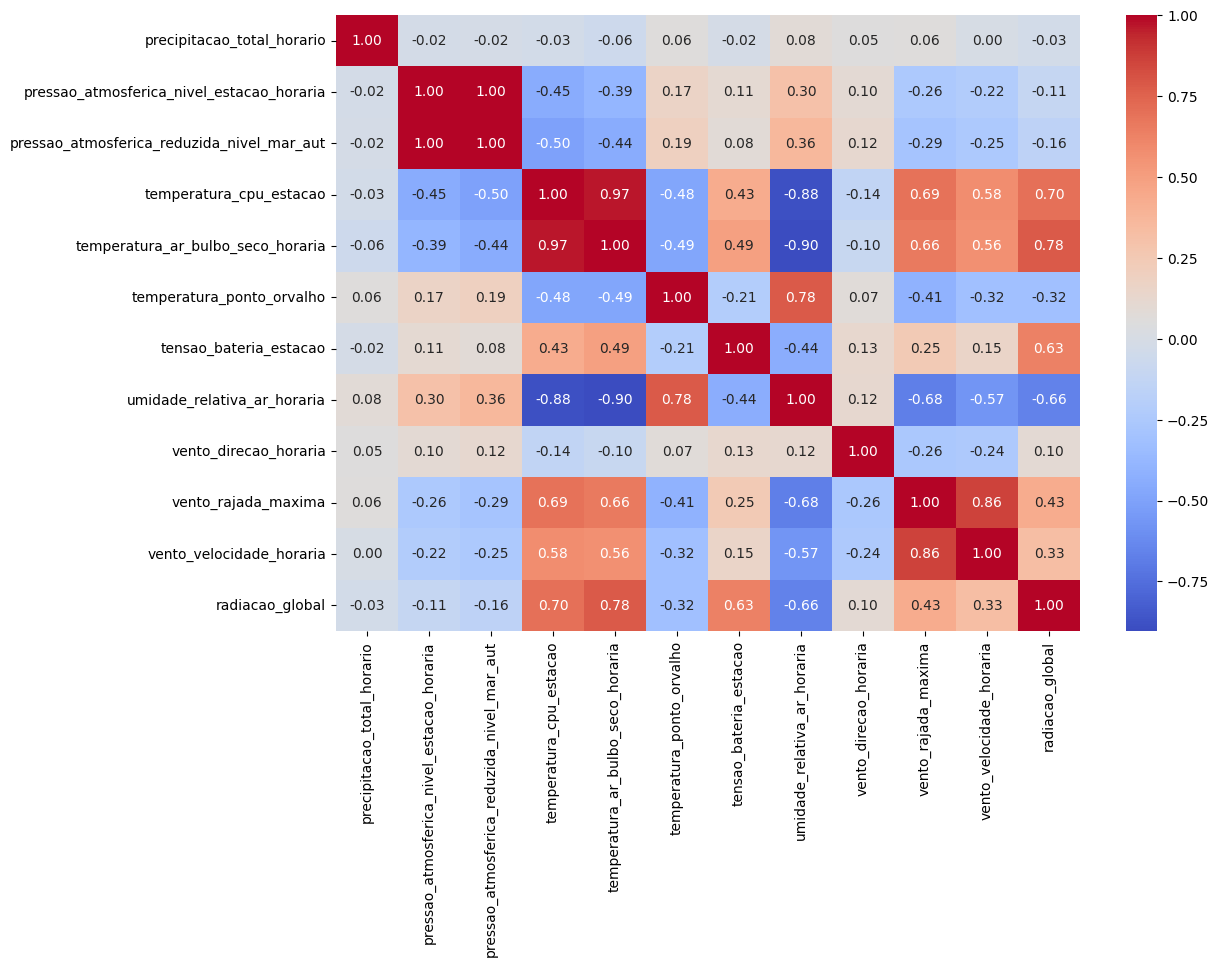

In [614]:
# plot dos valores da correlação entre as variáveis retirando a coluna year
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_wo_max_min.drop(columns=["year"]).corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)
# plt.title("Correlação entre as variáveis")
plt.show()

**Observações:**

- Identificamos altas correlações (>90%) entre:
    - `pressao_atmosferica_nivel_estacao_horaria` e `pressao_atmosferica_reduzida_nivel_mar_aut`
    - `temperatura_cpu_estacao` e `temperatura_ar_bulbo_seco_horaria`
- Ambas fazem sentido físico, visto que: 
    - o primeiro par é apenas uma mudança de referencial
    - faz sentido no senso comum a temperatura da cpu estar altamente relacionada à temperatura atmosférica ao seu redor

Usaremos essas correlações para inputar valores faltantes e retirar as variáveis redundantes

##### Correlação entre variáveis de Pressão Atmosférica

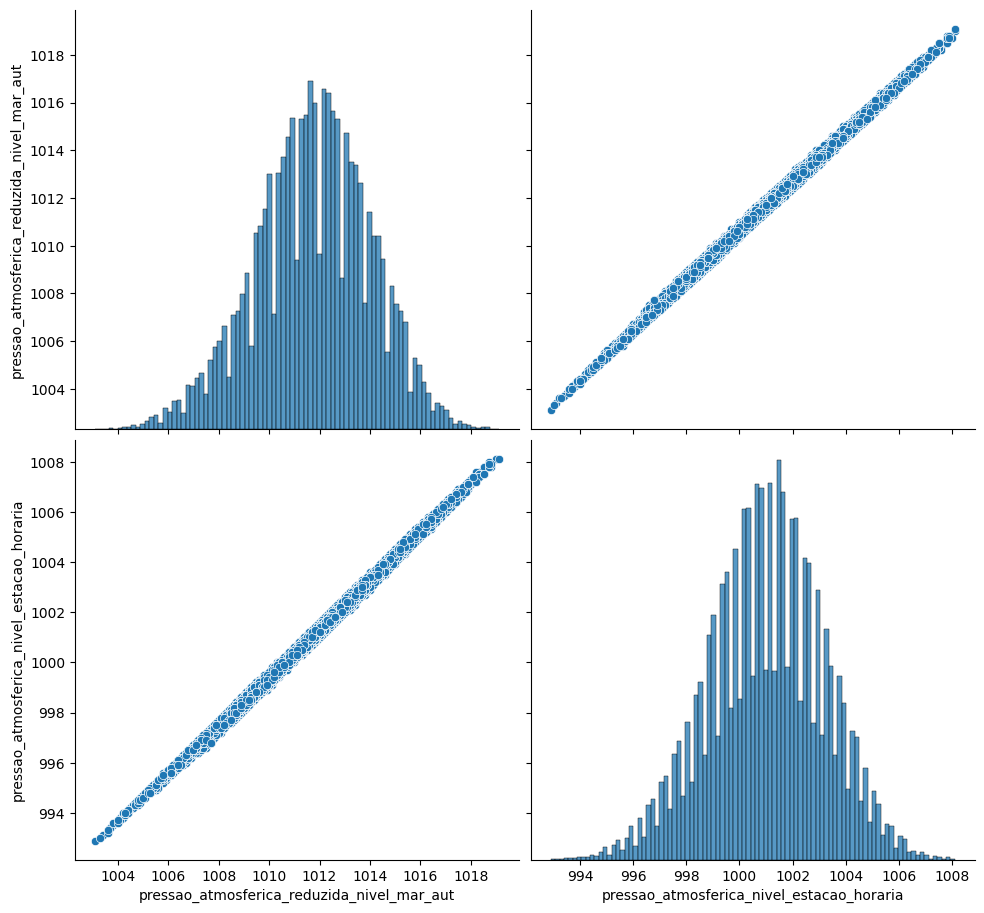

In [615]:
# plot da correlação entre pressao_atmosferica_reduzida_nivel_mar_aut e pressao_atmosferica_nivel_estacao_horaria
# tamanho da figura
# plt.figure(figsize=(50, 40))
sns.pairplot(
    df_wo_max_min[
        [
            "pressao_atmosferica_reduzida_nivel_mar_aut",
            "pressao_atmosferica_nivel_estacao_horaria",
        ]
    ],
    height=5  # Aumentando o tamanho de cada gráfico
)

# Ajustando o espaçamento dos títulos dos eixos
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.05, right=0.95)

# Rotacionando os títulos dos eixos
for label in plt.gca().get_xticklabels():
    label.set_rotation(45)

for label in plt.gca().get_yticklabels():
    label.set_rotation(45)

plt.show()

e \texttt{pressao\_atmosferica\_reduzida\_nivel\_mar\_aut}, que correspondem às pressões ao nível da estação e ao nível do mar, respectivamente, assim como \texttt{temperatura\_cpu\_estacao} e \texttt{temperatura\_ar\_bulbo\_seco\_horaria}

Temos uma correlação que se aproxima de linear

In [616]:
df_wo_max_min[
        [
            "pressao_atmosferica_reduzida_nivel_mar_aut",
            "pressao_atmosferica_nivel_estacao_horaria",
        ]
    ].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   pressao_atmosferica_reduzida_nivel_mar_aut  40144 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria   43360 non-null  float64
dtypes: float64(2)
memory usage: 2.0 MB


In [617]:
# Casos onde pressao_atmosferica_nivel_estacao_horaria é nula e pressao_atmosferica_reduzida_nivel_mar_aut não
df_wo_max_min.loc[
    df_wo_max_min["pressao_atmosferica_nivel_estacao_horaria"].isnull()
    & df_wo_max_min["pressao_atmosferica_reduzida_nivel_mar_aut"].notnull()
].head()

Empty DataFrame
Columns: [precipitacao_total_horario, pressao_atmosferica_nivel_estacao_horaria, pressao_atmosferica_reduzida_nivel_mar_aut, temperatura_cpu_estacao, temperatura_ar_bulbo_seco_horaria, temperatura_ponto_orvalho, tensao_bateria_estacao, umidade_relativa_ar_horaria, vento_direcao_horaria, vento_rajada_maxima, vento_velocidade_horaria, radiacao_global, year]
Index: []

**Observações:**

- Não temos casos onde a variável de interesse é nula e a variável correlacionada não o seja para podemos inferir via regressão linear
- Vamos apenas dropar a coluna

In [618]:
# Drop na coluna pressao_atmosferica_reduzida_nivel_mar_aut
df_reduzido = df_wo_max_min.copy()
df_reduzido.drop(
    columns=["pressao_atmosferica_reduzida_nivel_mar_aut"], inplace=True
)

##### Correlação entre variáveis de Temperatura

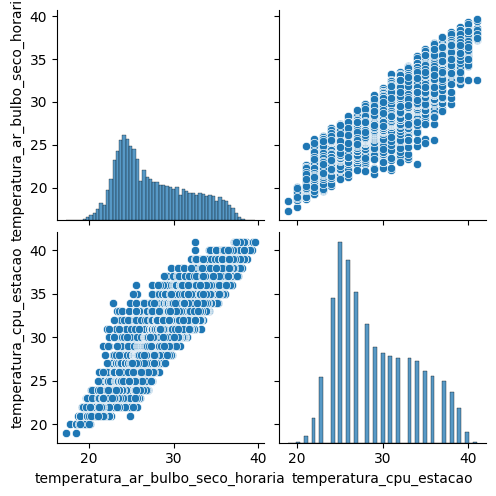

In [619]:
# plot da correlação entre pressao_atmosferica_reduzida_nivel_mar_aut e pressao_atmosferica_nivel_estacao_horaria
sns.pairplot(
    df_reduzido[
        [
            "temperatura_ar_bulbo_seco_horaria",
            "temperatura_cpu_estacao",
        ]
    ]
)

Temos uma tendência aproximadamente linear, mas não tão acentuada quanto para as variáveis de pressão

In [620]:
# % Casos onde temperatura_ar_bulbo_seco_horaria é nula e temperatura_cpu_estacao não
df_reduzido.loc[
    df_reduzido["temperatura_ar_bulbo_seco_horaria"].isnull()
    & df_reduzido["temperatura_cpu_estacao"].notnull()
].shape[0] / df_reduzido.loc[
    df_reduzido["temperatura_ar_bulbo_seco_horaria"].isnull()
].shape[
    0
] * 100

87.39130434782608

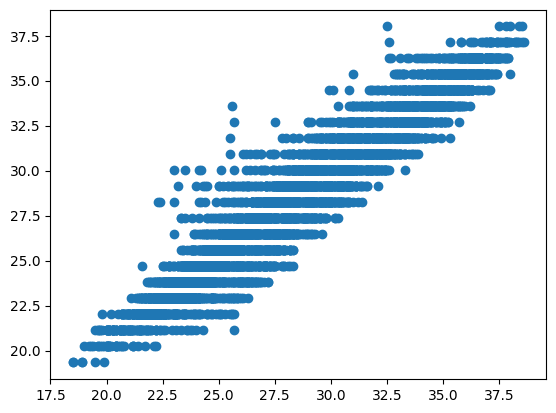

In [621]:
# Regressão linear para preencher valores nulos de temperatura_ar_bulbo_seco_horaria a partir de temperatura_cpu_estacao
from sklearn.linear_model import LinearRegression

# Criação do modelo de regressão linear
lm = LinearRegression()

df_reduzido_temp = df_reduzido[
    ["temperatura_ar_bulbo_seco_horaria", "temperatura_cpu_estacao"]
].dropna()

# Separação em treino e teste em 80% e 20%
from sklearn.model_selection import train_test_split

X = df_reduzido_temp["temperatura_cpu_estacao"].values.reshape(-1, 1)
y = df_reduzido_temp["temperatura_ar_bulbo_seco_horaria"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Treinamento do modelo
lm.fit(X_train, y_train)

# Predição
predictions = lm.predict(X_test)

# Plot dos valores reais e preditos
plt.scatter(y_test, predictions)


<Axes: xlabel='temperatura_ar_bulbo_seco_horaria', ylabel='Count'>

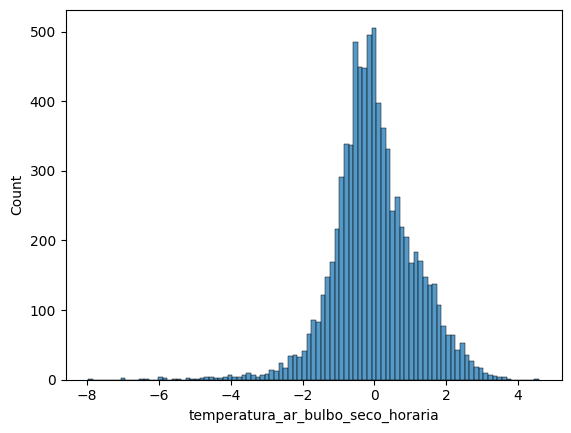

In [622]:
# Plot da distribuição dos resíduos
sns.histplot(y_test - predictions)

In [623]:
# Coeficientes do modelo
lm.coef_, lm.intercept_


(array([0.88928016]), 1.5519082769996864)

In [624]:
# acurácia do modelo com r2
from sklearn.metrics import r2_score

r2_score(y_test, predictions)

0.9304049378115263

In [625]:
# df reduzido de 2015-01-13 a 2015-01-16 --> período com falta de dados
df_reduzido.loc["2015-05-27":"2015-05-28"].head(24)

precipitacao_total_horario  \
2015-05-27 00:00:00                         0.0   
2015-05-27 01:00:00                         0.0   
2015-05-27 02:00:00                         0.0   
2015-05-27 03:00:00                         0.0   
2015-05-27 04:00:00                         0.0   
2015-05-27 05:00:00                         0.0   
2015-05-27 06:00:00                         0.0   
2015-05-27 07:00:00                         0.0   
2015-05-27 08:00:00                         0.0   
2015-05-27 09:00:00                         0.0   
2015-05-27 10:00:00                         0.0   
2015-05-27 11:00:00                         0.0   
2015-05-27 12:00:00                         0.0   
2015-05-27 13:00:00                         0.0   
2015-05-27 14:00:00                         0.0   
2015-05-27 15:00:00                         0.0   
2015-05-27 16:00:00                         0.0   
2015-05-27 17:00:00                         0.0   
2015-05-27 18:00:00                         0.0   
2015-05-27 19:00:00                         0.0   
2015-05-27 20:00:00                         0.0   
2015-05-27 21:00:00                         0.0   
2015-05-27 22:00:00                         0.0   
2015-05-27 23:00:00                         0.0   

                     pressao_atmosferica_nivel_estacao_horaria  \
2015-05-27 00:00:00                                     1001.9   
2015-05-27 01:00:00                                     1001.2   
2015-05-27 02:00:00                                     1000.8   
2015-05-27 03:00:00                                     1000.7   
2015-05-27 04:00:00                                     1000.7   
2015-05-27 05:00:00                                     1001.4   
2015-05-27 06:00:00                                     1001.4   
2015-05-27 07:00:00                                     1001.9   
2015-05-27 08:00:00                                     1002.5   
2015-05-27 09:00:00                                     1002.6   
2015-05-27 10:00:00                                     1002.6   
2015-05-27 11:00:00                                     1001.8   
2015-05-27 12:00:00                                     1000.8   
2015-05-27 13:00:00                                      999.8   
2015-05-27 14:00:00                                      998.9   
2015-05-27 15:00:00                                      998.7   
2015-05-27 16:00:00                                      998.8   
2015-05-27 17:00:00                                      999.3   
2015-05-27 18:00:00                                     1000.4   
2015-05-27 19:00:00                                     1001.2   
2015-05-27 20:00:00                                     1001.9   
2015-05-27 21:00:00                                     1002.7   
2015-05-27 22:00:00                                     1002.7   
2015-05-27 23:00:00                                     1002.8   

                     temperatura_cpu_estacao  \
2015-05-27 00:00:00                     25.0   
2015-05-27 01:00:00                     25.0   
2015-05-27 02:00:00                     25.0   
2015-05-27 03:00:00                     24.0   
2015-05-27 04:00:00                     24.0   
2015-05-27 05:00:00                     24.0   
2015-05-27 06:00:00                     24.0   
2015-05-27 07:00:00                     24.0   
2015-05-27 08:00:00                     28.0   
2015-05-27 09:00:00                     31.0   
2015-05-27 10:00:00                     33.0   
2015-05-27 11:00:00                     33.0   
2015-05-27 12:00:00                     35.0   
2015-05-27 13:00:00                     36.0   
2015-05-27 14:00:00                     36.0   
2015-05-27 15:00:00                     35.0   
2015-05-27 16:00:00                     35.0   
2015-05-27 17:00:00                     32.0   
2015-05-27 18:00:00                     31.0   
2015-05-27 19:00:00                     29.0   
2015-05-27 20:00:00                     28.0   
2015-05-27 21:00:00                   

In [626]:
# input dos valores faltantes usando o modelo de regressão linear com 1 casa decimal
df_reduzido.loc[
    df_reduzido["temperatura_ar_bulbo_seco_horaria"].isnull()
    & df_reduzido["temperatura_cpu_estacao"].notnull(),
    "temperatura_ar_bulbo_seco_horaria",
] = np.round(
    lm.predict(
        df_reduzido.loc[
            df_reduzido["temperatura_ar_bulbo_seco_horaria"].isnull()
            & df_reduzido["temperatura_cpu_estacao"].notnull(),
            "temperatura_cpu_estacao",
        ].values.reshape(-1, 1)
    ),
    1,
)

In [627]:
# df reduzido de 2015-01-13 a 2015-01-16
df_reduzido.loc["2015-05-27":"2015-05-28"].head(24)

precipitacao_total_horario  \
2015-05-27 00:00:00                         0.0   
2015-05-27 01:00:00                         0.0   
2015-05-27 02:00:00                         0.0   
2015-05-27 03:00:00                         0.0   
2015-05-27 04:00:00                         0.0   
2015-05-27 05:00:00                         0.0   
2015-05-27 06:00:00                         0.0   
2015-05-27 07:00:00                         0.0   
2015-05-27 08:00:00                         0.0   
2015-05-27 09:00:00                         0.0   
2015-05-27 10:00:00                         0.0   
2015-05-27 11:00:00                         0.0   
2015-05-27 12:00:00                         0.0   
2015-05-27 13:00:00                         0.0   
2015-05-27 14:00:00                         0.0   
2015-05-27 15:00:00                         0.0   
2015-05-27 16:00:00                         0.0   
2015-05-27 17:00:00                         0.0   
2015-05-27 18:00:00                         0.0   
2015-05-27 19:00:00                         0.0   
2015-05-27 20:00:00                         0.0   
2015-05-27 21:00:00                         0.0   
2015-05-27 22:00:00                         0.0   
2015-05-27 23:00:00                         0.0   

                     pressao_atmosferica_nivel_estacao_horaria  \
2015-05-27 00:00:00                                     1001.9   
2015-05-27 01:00:00                                     1001.2   
2015-05-27 02:00:00                                     1000.8   
2015-05-27 03:00:00                                     1000.7   
2015-05-27 04:00:00                                     1000.7   
2015-05-27 05:00:00                                     1001.4   
2015-05-27 06:00:00                                     1001.4   
2015-05-27 07:00:00                                     1001.9   
2015-05-27 08:00:00                                     1002.5   
2015-05-27 09:00:00                                     1002.6   
2015-05-27 10:00:00                                     1002.6   
2015-05-27 11:00:00                                     1001.8   
2015-05-27 12:00:00                                     1000.8   
2015-05-27 13:00:00                                      999.8   
2015-05-27 14:00:00                                      998.9   
2015-05-27 15:00:00                                      998.7   
2015-05-27 16:00:00                                      998.8   
2015-05-27 17:00:00                                      999.3   
2015-05-27 18:00:00                                     1000.4   
2015-05-27 19:00:00                                     1001.2   
2015-05-27 20:00:00                                     1001.9   
2015-05-27 21:00:00                                     1002.7   
2015-05-27 22:00:00                                     1002.7   
2015-05-27 23:00:00                                     1002.8   

                     temperatura_cpu_estacao  \
2015-05-27 00:00:00                     25.0   
2015-05-27 01:00:00                     25.0   
2015-05-27 02:00:00                     25.0   
2015-05-27 03:00:00                     24.0   
2015-05-27 04:00:00                     24.0   
2015-05-27 05:00:00                     24.0   
2015-05-27 06:00:00                     24.0   
2015-05-27 07:00:00                     24.0   
2015-05-27 08:00:00                     28.0   
2015-05-27 09:00:00                     31.0   
2015-05-27 10:00:00                     33.0   
2015-05-27 11:00:00                     33.0   
2015-05-27 12:00:00                     35.0   
2015-05-27 13:00:00                     36.0   
2015-05-27 14:00:00                     36.0   
2015-05-27 15:00:00                     35.0   
2015-05-27 16:00:00                     35.0   
2015-05-27 17:00:00                     32.0   
2015-05-27 18:00:00                     31.0   
2015-05-27 19:00:00                     29.0   
2015-05-27 20:00:00                     28.0   
2015-05-27 21:00:00                   

In [628]:
# drop coluna temperatura_cpu_estacao
df_reduzido.drop(columns=["temperatura_cpu_estacao"], inplace=True)

In [629]:
df_reduzido.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 35973 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43360 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43360 non-null  float64
 3   temperatura_ponto_orvalho                  36193 non-null  float64
 4   tensao_bateria_estacao                     43360 non-null  float64
 5   umidade_relativa_ar_horaria                39412 non-null  float64
 6   vento_direcao_horaria                      43354 non-null  float64
 7   vento_rajada_maxima                        43299 non-null  float64
 8   vento_velocidade_horaria                   43354 non-null  float64
 9   radiacao_global                            41296 no

##### Correlação entre Temperatura Ponto Orvalho, Temperatura e Umidade

- De acordo com documentação das variáveis do INMET, a Temperatura Ponto Orvalho é uma variável calculada a partir da Temperatura e da Umidade;
- Vemos que esta tem uma correlação mais fraca do que as demais com a Radiação;
- Vamos checar se podemos usá-la para inputar algum dado para essas duas variáveis antes de dropa-la.

In [630]:
# temperatura_ponto_orvalho não nulo e umidade_relativa_ar_horaria nulo
df_reduzido.loc[
    df_reduzido["temperatura_ponto_orvalho"].notnull()
    & df_reduzido["umidade_relativa_ar_horaria"].isnull()
].head()

Empty DataFrame
Columns: [precipitacao_total_horario, pressao_atmosferica_nivel_estacao_horaria, temperatura_ar_bulbo_seco_horaria, temperatura_ponto_orvalho, tensao_bateria_estacao, umidade_relativa_ar_horaria, vento_direcao_horaria, vento_rajada_maxima, vento_velocidade_horaria, radiacao_global, year]
Index: []

In [631]:
# temperatura_ponto_orvalho não nulo e temperatura_ar_bulbo_seco_horaria nulo
df_reduzido.loc[
    df_reduzido["temperatura_ponto_orvalho"].notnull()
    & df_reduzido["temperatura_ar_bulbo_seco_horaria"].isnull()
].head()

Empty DataFrame
Columns: [precipitacao_total_horario, pressao_atmosferica_nivel_estacao_horaria, temperatura_ar_bulbo_seco_horaria, temperatura_ponto_orvalho, tensao_bateria_estacao, umidade_relativa_ar_horaria, vento_direcao_horaria, vento_rajada_maxima, vento_velocidade_horaria, radiacao_global, year]
Index: []

- Não temos valores que podem ser inputados a partir dessa variável
- Vamos, *abaixo*, fazer um check da dependência conjunta esse temperatura do ponto de orvalho e as outras duas conjuntamente

In [632]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import plotly.graph_objects as go

df_reduzido_orvalho = df_reduzido.copy()

# Interpolação linear para preencher os valores faltantes
df_reduzido_orvalho['temperatura_ar_bulbo_seco_horaria'] = df_reduzido_orvalho['temperatura_ar_bulbo_seco_horaria'].interpolate(method='linear')
df_reduzido_orvalho['umidade_relativa_ar_horaria'] = df_reduzido_orvalho['umidade_relativa_ar_horaria'].interpolate(method='linear')
df_reduzido_orvalho['temperatura_ponto_orvalho'] = df_reduzido_orvalho['temperatura_ponto_orvalho'].interpolate(method='linear')

# Ajuste de um modelo de regressão linear temperatura_ponto_orvalho ~ temperatura_ar_bulbo_seco_horaria + umidade_relativa_ar_horaria
model = LinearRegression()
model.fit(df_reduzido_orvalho[['temperatura_ar_bulbo_seco_horaria', 'umidade_relativa_ar_horaria']], df_reduzido_orvalho['temperatura_ponto_orvalho'])

# Previsão e cálculo do R^2
Z_pred = model.predict(df_reduzido_orvalho[['temperatura_ar_bulbo_seco_horaria', 'umidade_relativa_ar_horaria']])
r2 = r2_score(df_reduzido_orvalho['temperatura_ponto_orvalho'], Z_pred)
correlacao_multipla = np.sqrt(r2)

In [633]:
# print da correlação múltipla
print(f"Correlação Múltipla: {correlacao_multipla}")

# Criação do gráfico interativo 3D
fig = go.Figure(data=[go.Scatter3d(
    x=df_reduzido_orvalho['temperatura_ar_bulbo_seco_horaria'],
    y=df_reduzido_orvalho['umidade_relativa_ar_horaria'],
    z=df_reduzido_orvalho['temperatura_ponto_orvalho'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_reduzido_orvalho['temperatura_ponto_orvalho'],  # Cor baseado na temperatura do ponto de orvalho
        colorscale='Viridis',   # Escala de cores
        opacity=0.8
    )
)])

# Configurações de layout do gráfico
fig.update_layout(
    scene = dict(
        xaxis_title='temperatura_ar_bulbo_seco_horaria',
        yaxis_title='umidade_relativa_ar_horaria',
        zaxis_title='temperatura_ponto_orvalho'),
    title='Relação 3D entre temperatura_ar_bulbo_seco_horaria, umidade_relativa_ar_horaria e temperatura_ponto_orvalho',
    width=800,
    height=600
)

# Exibindo o gráfico interativo
fig.show()

Correlação Múltipla: 0.9044293140541985


**Observações:**

- Não conseguimos usar a variável de Temperatura do Ponto de Orvalho para input de valores faltantes para Temperatura e Umidade, visto a ausência de dados;
- Vemos, realmente, uma alta correlação conjunta entre essa variável e as outras duas, conforme indicado na documentação do INMET;
- Vamos, portanto, apenas retirá-la para os próximos passos devido a, teoricamente, esta não trazer informações adicionais.

In [634]:
# Remoção da coluna de temperatura do ponto de orvalho
df_reduzido.drop(columns=['temperatura_ponto_orvalho'], inplace=True)

In [635]:
df_reduzido.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 35973 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43360 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43360 non-null  float64
 3   tensao_bateria_estacao                     43360 non-null  float64
 4   umidade_relativa_ar_horaria                39412 non-null  float64
 5   vento_direcao_horaria                      43354 non-null  float64
 6   vento_rajada_maxima                        43299 non-null  float64
 7   vento_velocidade_horaria                   43354 non-null  float64
 8   radiacao_global                            41296 non-null  float64
 9   year                                       43824 no

##### Correlação entre Temperatura e Umidade

Vemos uma correlação negativa forte entre `temperatura_ar_bulbo_seco_horaria` e `umidade_relativa_ar_horaria`, vamos analisar para avaliar um input

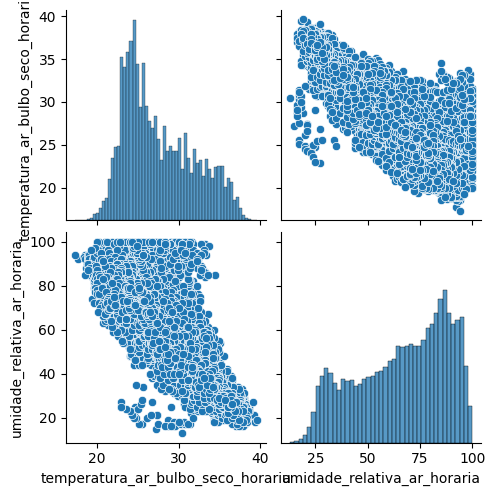

In [636]:
# plot da correlação entre temperatura_ar_bulbo_seco_horaria e umidade_relativa_ar_horaria
sns.pairplot(
    df_reduzido[
        [
            "temperatura_ar_bulbo_seco_horaria",
            "umidade_relativa_ar_horaria",
        ]
    ]
)

Não temos uma relação linear tão precisa para input rápido de dados baseado em regressão linear. Usaremos métodos de interpolacão

In [637]:
df_reduzido.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 35973 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43360 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43360 non-null  float64
 3   tensao_bateria_estacao                     43360 non-null  float64
 4   umidade_relativa_ar_horaria                39412 non-null  float64
 5   vento_direcao_horaria                      43354 non-null  float64
 6   vento_rajada_maxima                        43299 non-null  float64
 7   vento_velocidade_horaria                   43354 non-null  float64
 8   radiacao_global                            41296 non-null  float64
 9   year                                       43824 no

##### Correlação entre Rajada Máxima do Vento e Velocidade do Vento

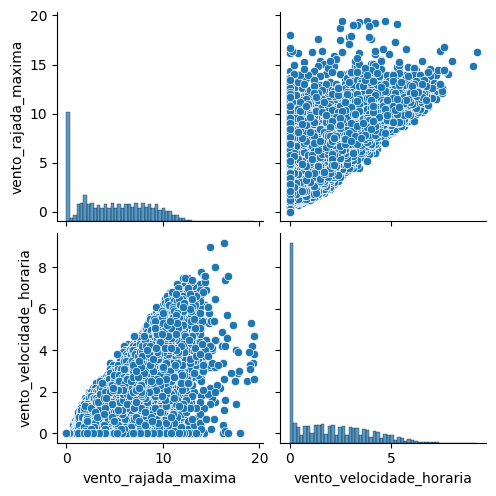

In [638]:
# plot da correlação entre temperatura_ar_bulbo_seco_horaria e umidade_relativa_ar_horaria
sns.pairplot(
    df_reduzido[
        [
            "vento_rajada_maxima",
            "vento_velocidade_horaria",
        ]
    ]
)

Da mesma forma, não temos uma dependência tão simples

#### 3.2.4. Input para variáveis sem dependência

A variável `precipitacao_total_horario` não tem relação com as demais variáveis. Vamos apenas inputar zero para os valores faltantes, visto a interpolação não fazer sentido para uma variável que indica precipitação

In [639]:
# Input de valor zero para valores faltantes de precipitacao_total_horario
df_reduzido['precipitacao_total_horario'].fillna(0, inplace=True)

### 3.3. Remoção de Variáveis sem sentido físico e correlação moderada

Vamos retirar a variável `tensao_bateria_estacao` para efeito de simplicidade, por esta não trazer sentido físico nem ter uma correlação forte com a variável target - `radiacao_global`

In [640]:
# Retirando a variável tensao_bateria_estacao
df_reduzido.drop(columns=['tensao_bateria_estacao'], inplace=True)

### 3.4. Remoção de Outliers

In [641]:
df_reduzido.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 43824 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43360 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43360 non-null  float64
 3   umidade_relativa_ar_horaria                39412 non-null  float64
 4   vento_direcao_horaria                      43354 non-null  float64
 5   vento_rajada_maxima                        43299 non-null  float64
 6   vento_velocidade_horaria                   43354 non-null  float64
 7   radiacao_global                            41296 non-null  float64
 8   year                                       43824 non-null  int32  
dtypes: float64(8), int32(1)
memory usage: 4.2 MB


In [642]:
# Novas colunas para facilitar análises
df_reduzido["hora"] = df_reduzido.index.hour
df_reduzido["mes"] = df_reduzido.index.month
# semana do ano
df_reduzido["semana"] = df_reduzido.index.isocalendar().week
# dia do ano
df_reduzido["dia_ano"] = df_reduzido.index.dayofyear

#### 3.4.1. Precipitação

**Visualização de Histograma / Boxplot / Boxenplot / Violinplot**

<Axes: xlabel='precipitacao_total_horario'>

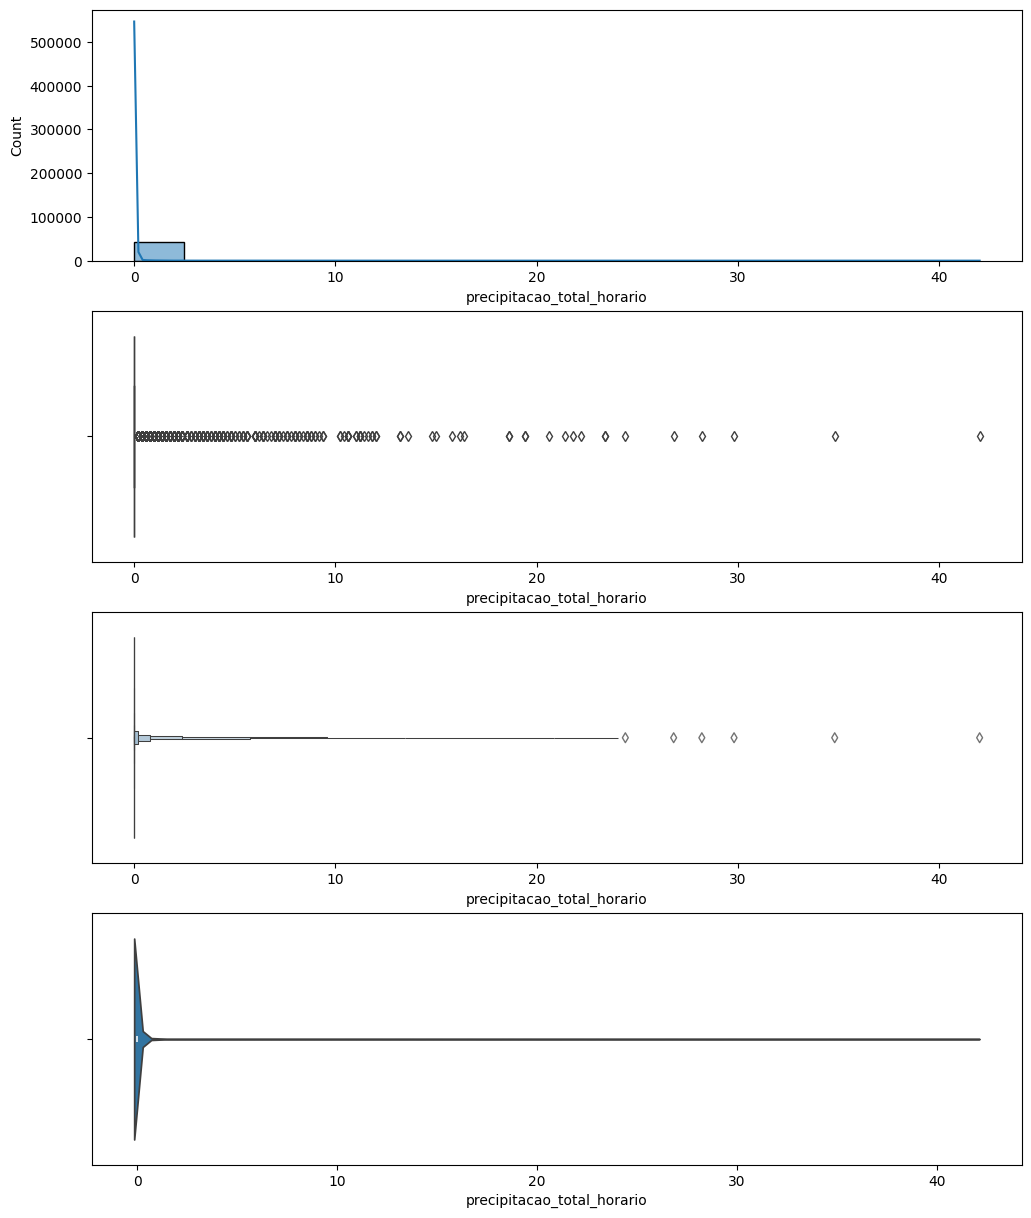

In [643]:
plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1)
sns.histplot(df_reduzido, x="precipitacao_total_horario", kde=True)
plt.subplot(4, 1, 2)
sns.boxplot(
    df_reduzido["precipitacao_total_horario"],
    orient="h",
    flierprops={"marker": "d", "markersize": 5, "color": "lightgray"},
)
plt.subplot(4, 1, 3)
sns.boxenplot(
    df_reduzido["precipitacao_total_horario"],
    orient="h",
    flier_kws={"marker": "d"},
    k_depth="tukey",
)
plt.subplot(4, 1, 4)
sns.violinplot(df_reduzido["precipitacao_total_horario"], orient="h")

Número de outliers: 1135


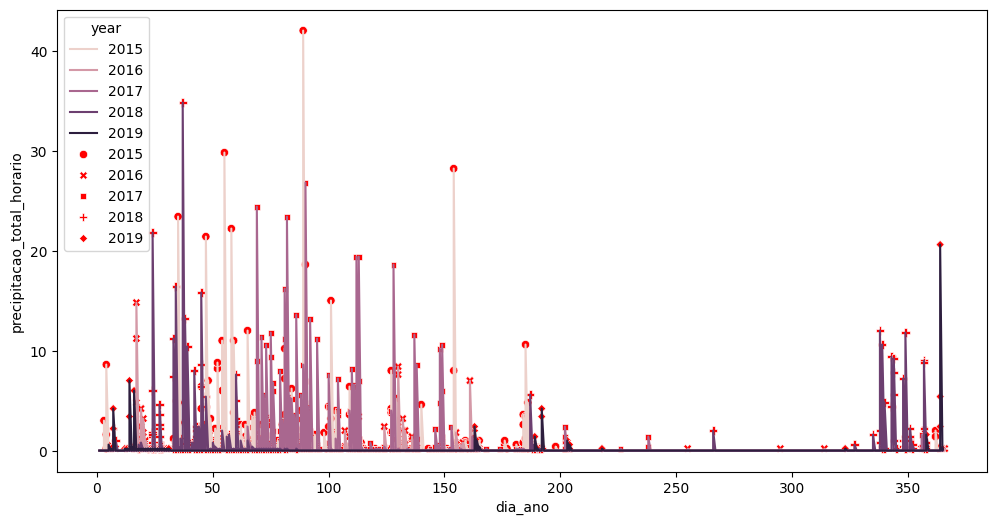

In [644]:
# plot da variável cada hue representa um ano e o eixo x corresponde ao dia do ano
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_reduzido,
    x="dia_ano",
    y="precipitacao_total_horario",
    hue="year",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

# plot outliers using IQR 1,5
def identify_outliers_iqr(variable):
    Q1 = variable.quantile(0.25)
    Q3 = variable.quantile(0.75)
    IQR = Q3 - Q1
    return (variable < (Q1 - 1.5 * IQR)) | (variable > (Q3 + 1.5 * IQR))

outlier_mask = identify_outliers_iqr(df_reduzido["precipitacao_total_horario"])
print("Número de outliers:", outlier_mask.sum())

sns.scatterplot(
    data=df_reduzido[outlier_mask],
    x="dia_ano",
    y="precipitacao_total_horario",
    style="year",
    color="red",
    markers=True,
)

plt.show()

- Vemos a maior parte dos dados de precipitação próximos de 0
- Essa observação faz sentido devido ao clima da região onde fica a estação (semiárido)
- Pontos outliers correspondem aos poucos dias de chuva e não parece fazer sentido retirá-los, visto que já foi feito check de sanidade

Visualizações de boxenplot

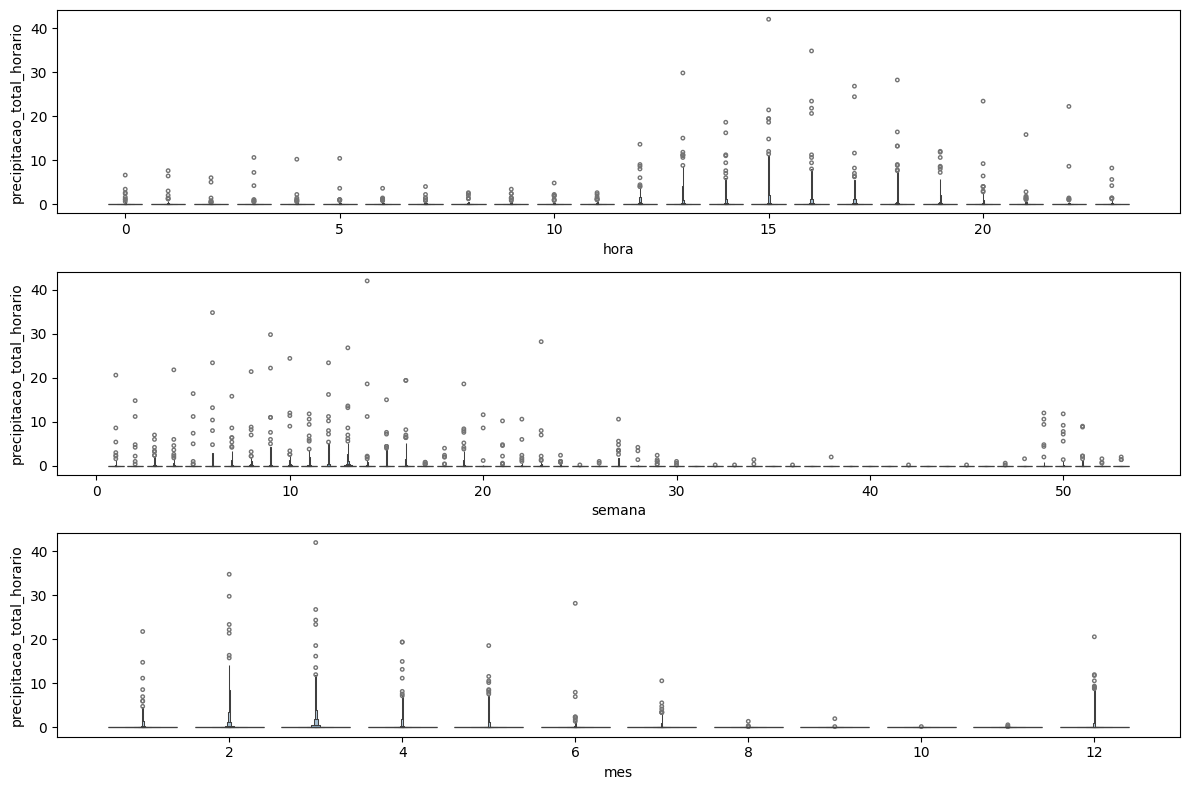

In [645]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
sns.boxenplot(x="hora", y="precipitacao_total_horario", data=df_reduzido, native_scale=True, flier_kws={"marker": "."})
plt.subplot(3, 1, 2)
sns.boxenplot(x="semana", y="precipitacao_total_horario", data=df_reduzido, native_scale=True, flier_kws={"marker": "."})
plt.subplot(3, 1, 3)
sns.boxenplot(x="mes", y="precipitacao_total_horario", data=df_reduzido, native_scale=True, flier_kws={"marker": "."})

plt.tight_layout()

- Vemos, agrupando os dados por hora do dia, mês do ano e semana do ano, uma corroboração do enunciado previamente. Fisicamente, não parece fazer sentido retirar outliers, visto serem valores com sentido de precipitações pontuais

#### 3.4.2. Pressão Atmosférica

##### a) Visualização de Histograma / Boxplot / Boxenplot / Violinplot

<Axes: xlabel='pressao_atmosferica_nivel_estacao_horaria'>

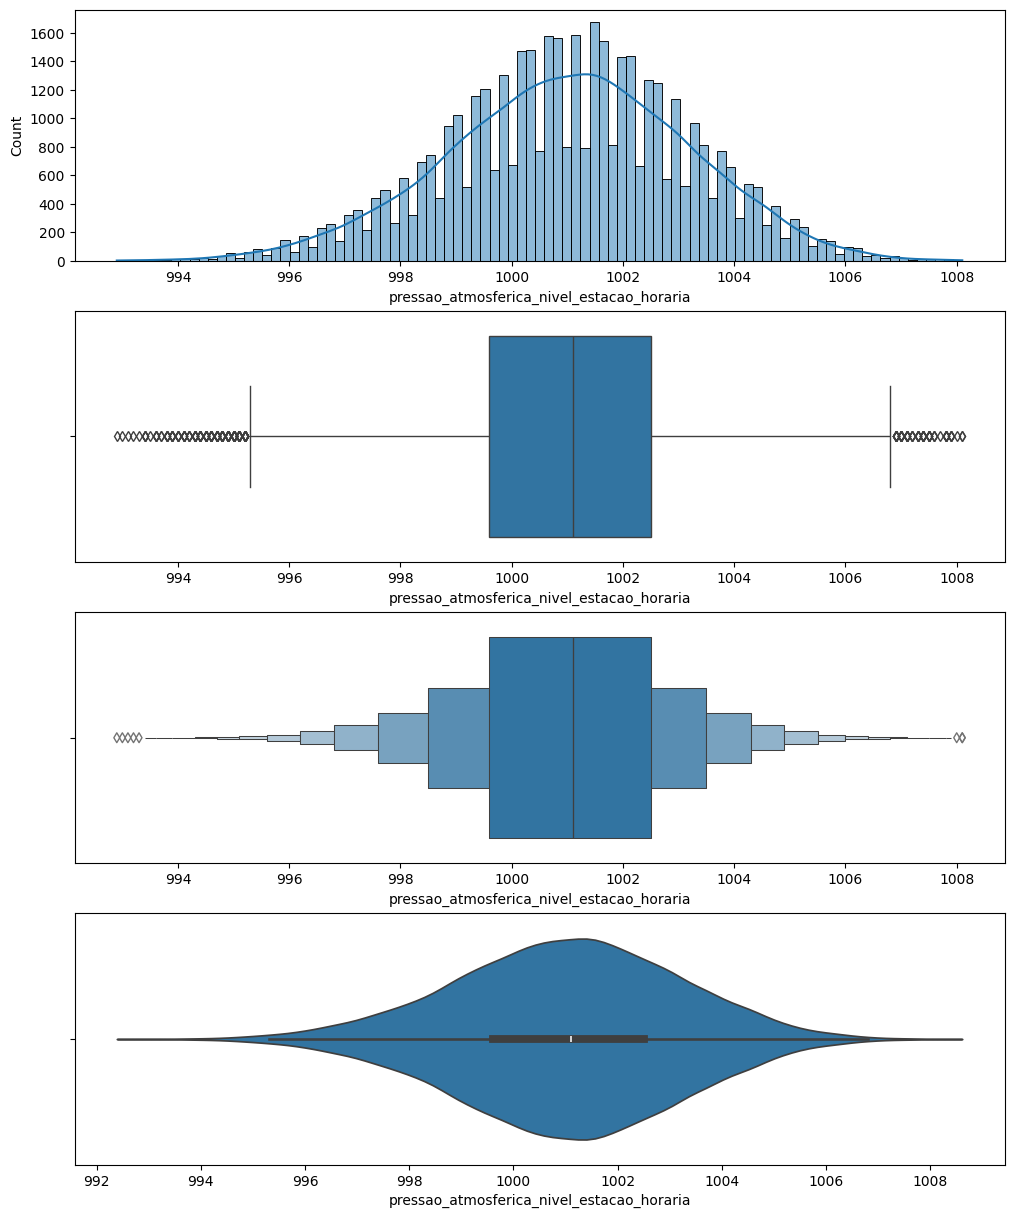

In [646]:
plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1)
sns.histplot(df_reduzido, x="pressao_atmosferica_nivel_estacao_horaria", kde=True)
plt.subplot(4, 1, 2)
sns.boxplot(
    df_reduzido["pressao_atmosferica_nivel_estacao_horaria"],
    orient="h",
    flierprops={"marker": "d", "markersize": 5, "color": "lightgray"},
)
plt.subplot(4, 1, 3)
sns.boxenplot(
    df_reduzido["pressao_atmosferica_nivel_estacao_horaria"],
    orient="h",
    flier_kws={"marker": "d"},
    k_depth="tukey",
)
plt.subplot(4, 1, 4)
sns.violinplot(df_reduzido["pressao_atmosferica_nivel_estacao_horaria"], orient="h")

##### b) Identificação de outliers via desvio padrão para distribuições normais

**Teste para identificação de normalidade dos dados**

In [647]:
from statsmodels.stats.diagnostic import kstest_normal

def test_normal(x):
    t_test, p_value = kstest_normal(x)
    print("p-value:", p_value)
    print("t test:", t_test)
    if p_value < 0.05:
        print("Reject null hypothesis. Data is not normal")
        return False
    else:
        print("Fail to reject null hypothesis. Data is normal")
        return True


**Função para detecção de outliers via desvio padrão**

In [648]:
def detect_outliers_dp(attribute, factor=2):
    """Funcao para identificar outliers com base no desvio padrão. Funciona como teste Z.
    Parametros:
        - attribute: atributos a considerar na remoção
        - factor: fator do desvio padrão a considerar
    Retorno:
        outliers identificados
    """
    outliers = []
    # verifica se variável é numerica
    if np.issubdtype(attribute.dtype, np.number):
        # calcula o desvio padrão
        std = attribute.std()
        media = attribute.mean()

        for x, i in zip(attribute, range(0, len(attribute))):
            if x > media + factor * std:
                outliers.append(i)
            elif x < media - factor * std:
                outliers.append(i)
            else:
                pass

        outliers = np.array(outliers)

    return outliers

In [649]:
# Teste de normalidade
normal = test_normal(
    df_reduzido["pressao_atmosferica_nivel_estacao_horaria"].dropna(inplace=False)
)

factor = config["outlier_detection"]["pressure"]["dp_factor"]
if normal:
    print("É normal, vamos usar o desvio padrão")
    outliers_dp = detect_outliers_dp(
        df_reduzido["pressao_atmosferica_nivel_estacao_horaria"],
        factor=factor,
    )

    print("Número de outliers:", len(outliers_dp))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_dp) / len(df_reduzido) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_reduzido,
        x="dia_ano",
        y="pressao_atmosferica_nivel_estacao_horaria",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )


    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_reduzido.iloc[outliers_dp],
        x="dia_ano",
        y="pressao_atmosferica_nivel_estacao_horaria",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_dp = []
    print("Não é normal")

p-value: 0.0009999999999998899
t test: 0.018620627341305096
Reject null hypothesis. Data is not normal
Não é normal


##### c) Identificação de outliers via IQR

In [650]:
def detect_outliers_iqr(attribute, factor=1.5):
    """Funcao para identificar outliers com base no IQR
    Parametros:
        - attributes: atributo a considerar na identificação
        - factor: fator do IQR a considerar
    Retorno:
        outliers identificados
    """
    # verifica se variável é numerica
    if np.issubdtype(attribute.dtype, np.number):
        Q1 = attribute.quantile(0.25)
        # Q2 = dfn[attribute].quantile(0.50)
        Q3 = attribute.quantile(0.75)
        IQR = Q3 - Q1

        outliers = []
        # outliers identificados (índices)
        for x, i in zip(attribute, range(0, len(attribute))):
            if x < Q1 - factor * IQR:
                outliers.append(i)
            elif x > Q3 + factor * IQR:
                outliers.append(i)
            else:
                pass

    return outliers

Número de outliers: 282
Porcentagem de outliers: 0.64 %


<Axes: xlabel='dia_ano', ylabel='pressao_atmosferica_nivel_estacao_horaria'>

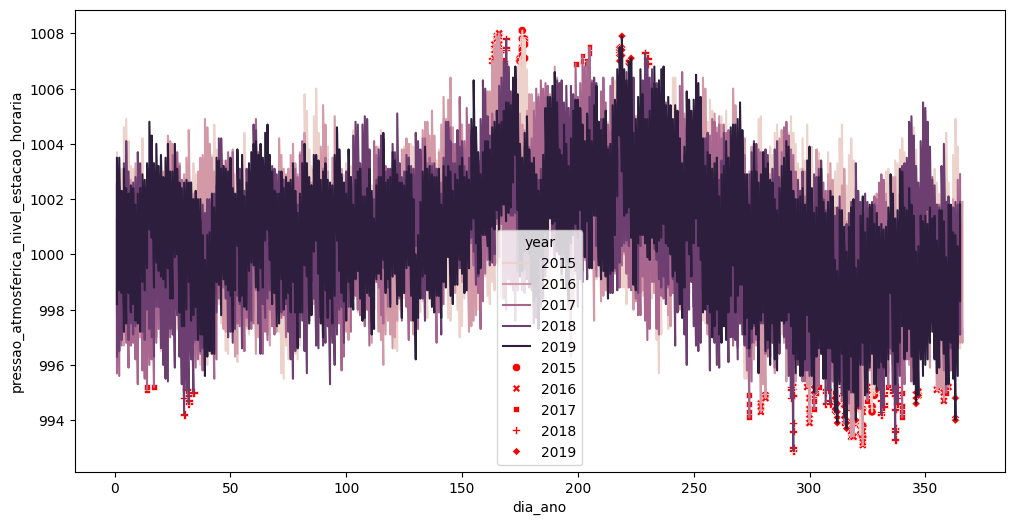

In [651]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_reduzido,
    x="dia_ano",
    y="pressao_atmosferica_nivel_estacao_horaria",
    hue="year",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

iqr_factor = config["outlier_detection"]["pressure"]["iqr_factor"]
outliers_iqr = detect_outliers_iqr(
    df_reduzido["pressao_atmosferica_nivel_estacao_horaria"],
    factor=iqr_factor,
)

print("Número de outliers:", len(outliers_iqr))
print(
    "Porcentagem de outliers:",
    round(len(outliers_iqr) / len(df_reduzido) * 100, 2),
    "%",
)

# outl são índices dos outliers, quero um scatterplot
sns.scatterplot(
    data=df_reduzido.iloc[outliers_iqr],
    x="dia_ano",
    y="pressao_atmosferica_nivel_estacao_horaria",
    style="year",
    color="red",
    markers=True,
)

##### d) Identificação de outliers via distribuição normal

In [652]:
def detect_outlier_Normal(attribute, epsilon=0.001, plotdist=False):
    """Funcao para detectar outliers com base na distribuicao Gaussiana univariada
    Parametros:
        - attribute: vetor de atributos/features
        - epsilon: limiar para rejeitar pontos como pertencendo a distribuicao (default:0.001)
        - plotdist: opcao que permite grafar a distribuicao com os parametros estimados
    Retorno:
        vetor com os índices dos outliers detectados
    """
    mean = np.mean(attribute)
    stdv  = np.std(attribute)
        
    # array vazio
    outliers = []
    # para cada atributo
    for x,i in zip(attribute, range(0,len(attribute))):
        # computa probabilidade
        p_x = np.exp(-(((x-mean)**2)/(2*stdv**2))) / (np.sqrt(2*np.pi)*stdv)
        # limiar para considerar outlier
        if (p_x < epsilon):
            outliers.append(i)
            
    outliers = np.array(outliers)
    
    # opcao para plotar a distribuicao marcando outliers
    if plotdist:
        x = np.arange(int(mean-4*stdv),int(mean+4*stdv),stdv/100.0)
        dist_gauss = np.exp(-(((x-mean)**2)/(2*(stdv**2)))) / (np.sqrt(2*np.pi)*stdv)
        plt.figure()
        plt.plot(x, dist_gauss)
        plt.plot(attribute[outliers], np.zeros(outliers.shape[0]), 'xr')
    
    return outliers

In [653]:
epsilon = config["outlier_detection"]["pressure"]["epsilon"]
if normal:
    print("É normal, vamos usar a dist Gaussiana")
    outliers_normal = detect_outlier_Normal(
        df_reduzido["pressao_atmosferica_nivel_estacao_horaria"],
        epsilon=epsilon,
        plotdist=False,
    )

    print("Número de outliers:", len(outliers_normal))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_normal) / len(df_reduzido) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_reduzido,
        x="dia_ano",
        y="pressao_atmosferica_nivel_estacao_horaria",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_reduzido.iloc[outliers_normal],
        x="dia_ano",
        y="pressao_atmosferica_nivel_estacao_horaria",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_normal = []
    print("Não é normal")

Não é normal


##### e) União dos 3 métodos de detecção e remoção dos outliers

Não é normal


<Axes: xlabel='None', ylabel='pressao_atmosferica_nivel_estacao_horaria'>

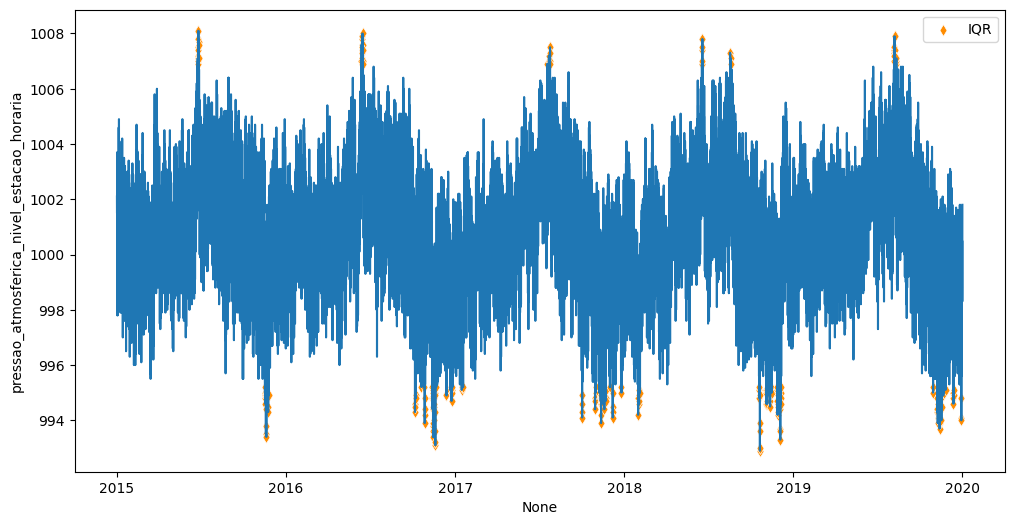

In [654]:
# Visualização de todos os 3 métodos de detecção de outliers sem separar por ano com eixo x correspondente ao índice
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_reduzido,
    x=df_reduzido.index,
    y="pressao_atmosferica_nivel_estacao_horaria",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

if normal:
    sns.scatterplot(
        data=df_reduzido.iloc[outliers_dp],
        x=df_reduzido.index[outliers_dp],
        y="pressao_atmosferica_nivel_estacao_horaria",
        color="red",
        markers=True,
        marker="o",
        label="Desvio Padrão",
    )
    sns.scatterplot(
        data=df_reduzido.iloc[outliers_normal],
        x=df_reduzido.index[outliers_normal],
        y="pressao_atmosferica_nivel_estacao_horaria",
        color="indigo",
        markers=True,
        marker="x",
        label="Distribuição Gaussiana",
    )
else:
    print("Não é normal")

sns.scatterplot(
        data=df_reduzido.iloc[outliers_iqr],
        x=df_reduzido.index[outliers_iqr],
        y="pressao_atmosferica_nivel_estacao_horaria",
        color="darkorange",
        markers=True,
        marker="d",
        label="IQR",
    )

In [655]:
# cálculo da % de outliers total
outliers_total = np.unique(
    np.concatenate((outliers_dp, outliers_iqr, outliers_normal))
)
# to int every element in outliers_total
outliers_total = outliers_total.astype(int)
print("Número de outliers total:", len(outliers_total))
print(
    "Porcentagem de outliers total:",
    round(len(outliers_total) / len(df_reduzido) * 100, 2),
    "%",
)

Número de outliers total: 282
Porcentagem de outliers total: 0.64 %


In [656]:
# Setando os outliers para NaN
df_wo_pressure_outliers = df_reduzido.copy()

df_wo_pressure_outliers.loc[
    df_reduzido.index[outliers_total],
    "pressao_atmosferica_nivel_estacao_horaria",
] = np.nan

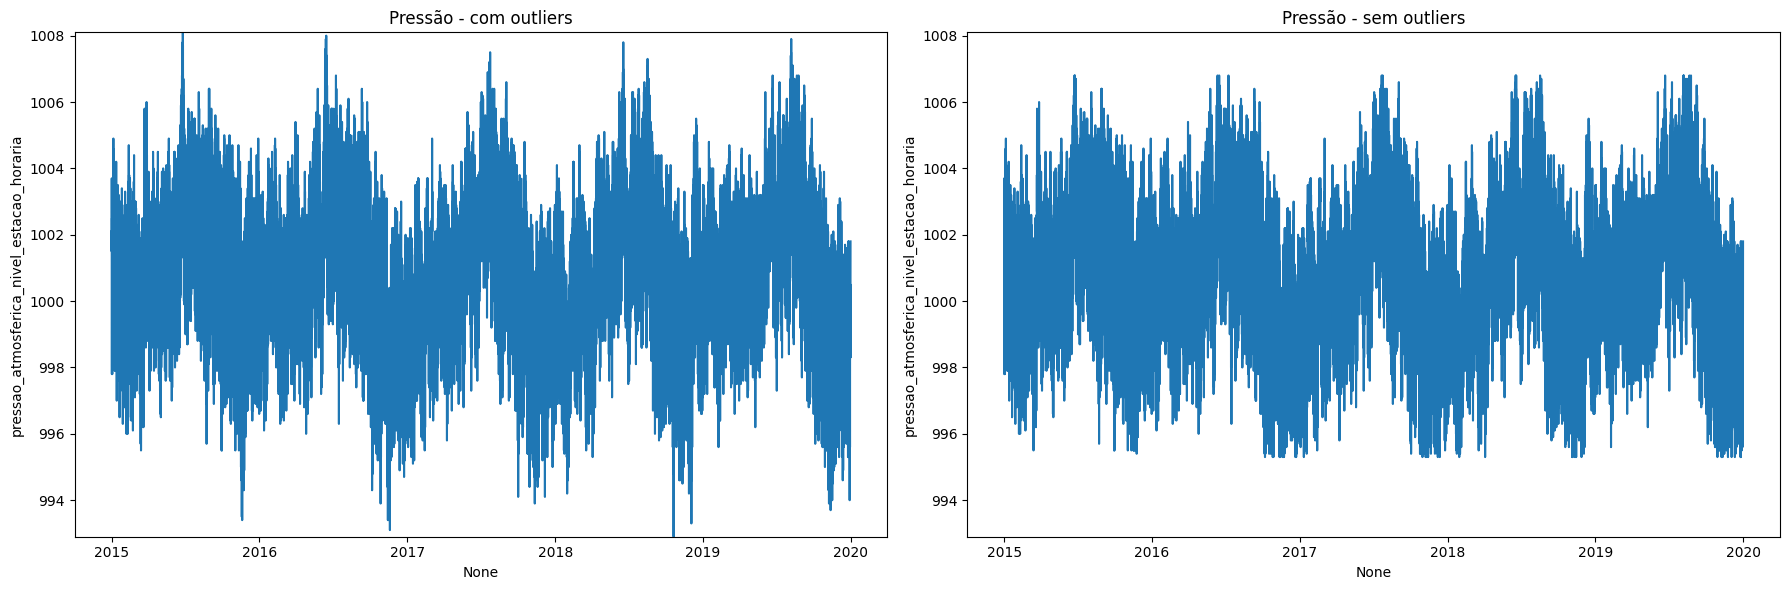

In [657]:
# Criando a figura e a grade de subgráficos
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 linha, 2 colunas

# Plot para df_reduzido
sns.lineplot(
    data=df_reduzido,
    x=df_reduzido.index,
    y="pressao_atmosferica_nivel_estacao_horaria",
    errorbar=None,
    estimator=None,
    ax=axes[0],  # Primeiro gráfico
)
axes[0].set_title("Pressão - com outliers")

# Plot para df_wo_pressure_outliers
sns.lineplot(
    data=df_wo_pressure_outliers,
    x=df_wo_pressure_outliers.index,
    y="pressao_atmosferica_nivel_estacao_horaria",
    errorbar=None,
    estimator=None,
    ax=axes[1],  # Segundo gráfico
)
axes[1].set_title("Pressão - sem outliers")

# Ajustando o limite do eixo y para ambos os gráficos (usando o valor do eixo y de df_reduzido)
y_min = min(
    df_reduzido["pressao_atmosferica_nivel_estacao_horaria"].min(),
    df_wo_pressure_outliers["pressao_atmosferica_nivel_estacao_horaria"].min(),
)
y_max = max(
    df_reduzido["pressao_atmosferica_nivel_estacao_horaria"].max(),
    df_wo_pressure_outliers["pressao_atmosferica_nivel_estacao_horaria"].max(),
)

# Definindo os limites do eixo y para ambos os gráficos
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

# Exibindo os gráficos
plt.tight_layout()
plt.show()

#### 3.4.3. Temperatura do ar

##### a) Visualização de Histograma / Boxplot / Boxenplot / Violinplot

<Axes: xlabel='temperatura_ar_bulbo_seco_horaria'>

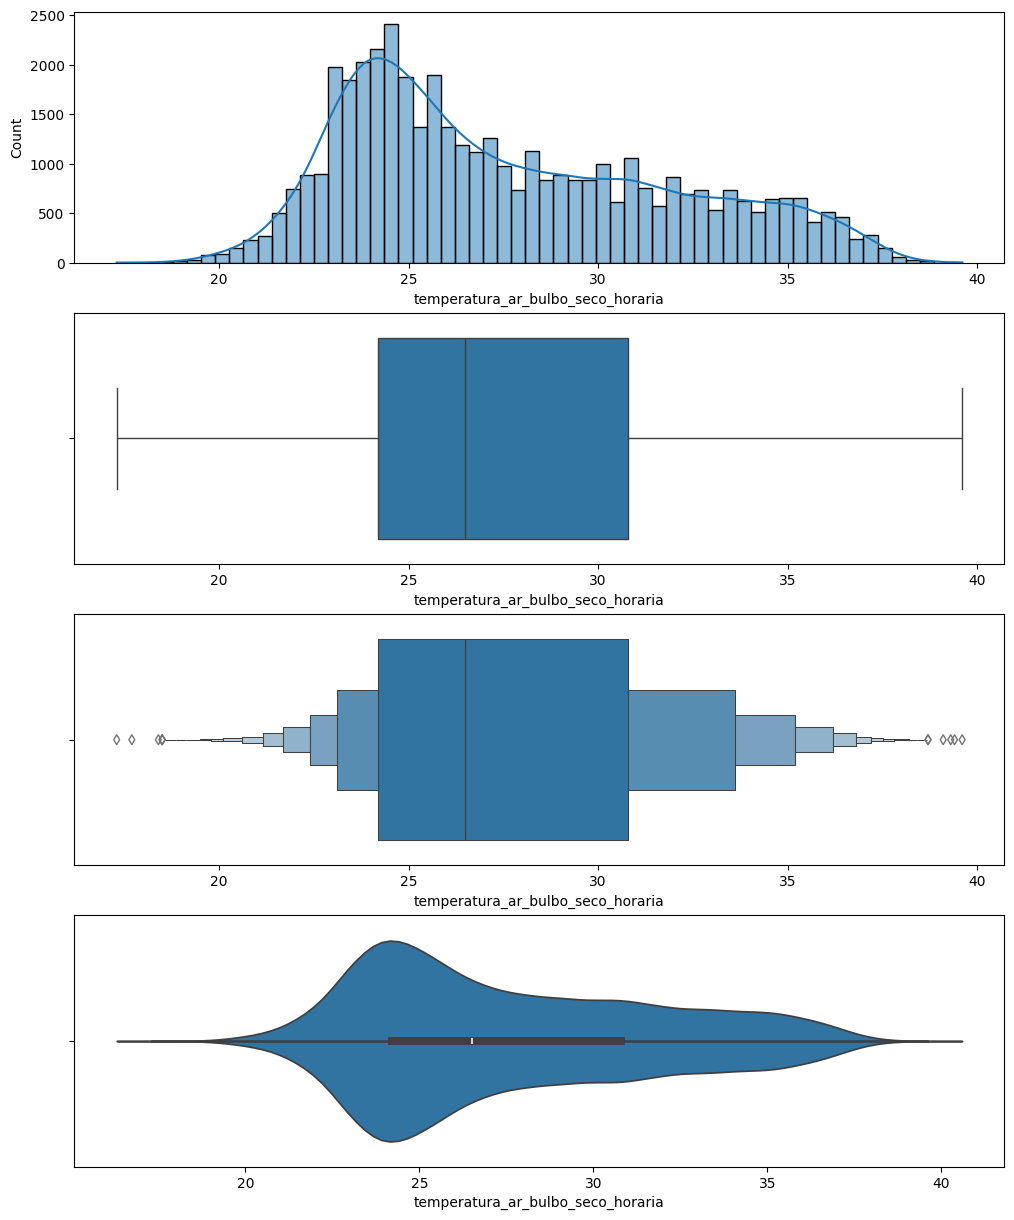

In [658]:
plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1)
sns.histplot(df_wo_pressure_outliers, x="temperatura_ar_bulbo_seco_horaria", kde=True)
plt.subplot(4, 1, 2)
sns.boxplot(
    df_wo_pressure_outliers["temperatura_ar_bulbo_seco_horaria"],
    orient="h",
    flierprops={"marker": "d", "markersize": 5, "color": "lightgray"},
)
plt.subplot(4, 1, 3)
sns.boxenplot(
    df_wo_pressure_outliers["temperatura_ar_bulbo_seco_horaria"],
    orient="h",
    flier_kws={"marker": "d"},
    k_depth="tukey",
)
plt.subplot(4, 1, 4)
sns.violinplot(df_wo_pressure_outliers["temperatura_ar_bulbo_seco_horaria"], orient="h")

##### b) Identificação de outliers via desvio padrão para distribuições normais

In [659]:
# Teste de normalidade
normal = test_normal(
    df_wo_pressure_outliers["temperatura_ar_bulbo_seco_horaria"].dropna(
        inplace=False
    )
)

factor = config["outlier_detection"]["temperature"]["dp_factor"]
if normal:
    print("É normal, vamos usar o desvio padrão")
    outliers_dp = detect_outliers_dp(
        df_wo_pressure_outliers["temperatura_ar_bulbo_seco_horaria"],
        factor=factor,
    )

    print("Número de outliers:", len(outliers_dp))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_dp) / len(df_wo_pressure_outliers) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_wo_pressure_outliers,
        x="dia_ano",
        y="temperatura_ar_bulbo_seco_horaria",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_wo_pressure_outliers.iloc[outliers_dp],
        x="dia_ano",
        y="temperatura_ar_bulbo_seco_horaria",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_dp = []
    print("Não é normal")

p-value: 0.0009999999999998899
t test: 0.11145324149950925
Reject null hypothesis. Data is not normal
Não é normal


##### c) Identificação de outliers via IQR

Número de outliers: 0
Porcentagem de outliers: 0.0 %


<Axes: xlabel='dia_ano', ylabel='temperatura_ar_bulbo_seco_horaria'>

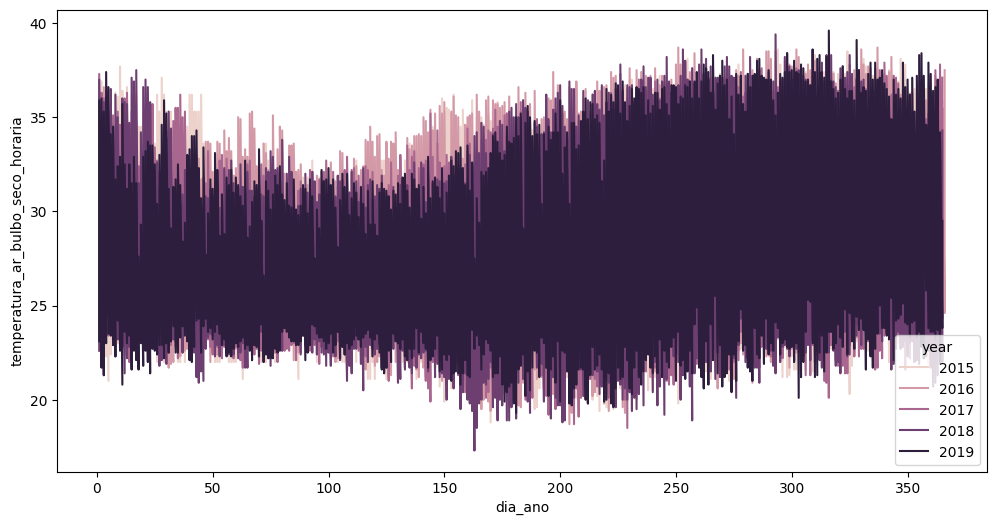

In [660]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_wo_pressure_outliers,
    x="dia_ano",
    y="temperatura_ar_bulbo_seco_horaria",
    hue="year",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

iqr_factor = config["outlier_detection"]["temperature"]["iqr_factor"]
outliers_iqr = detect_outliers_iqr(
    df_wo_pressure_outliers["temperatura_ar_bulbo_seco_horaria"],
    factor=iqr_factor,
)

print("Número de outliers:", len(outliers_iqr))
print(
    "Porcentagem de outliers:",
    round(len(outliers_iqr) / len(df_wo_pressure_outliers) * 100, 2),
    "%",
)

# outl são índices dos outliers, quero um scatterplot
sns.scatterplot(
    data=df_wo_pressure_outliers.iloc[outliers_iqr],
    x="dia_ano",
    y="temperatura_ar_bulbo_seco_horaria",
    style="year",
    color="red",
    markers=True,
)

##### d) Identificação de outliers via distribuição normal

In [661]:
epsilon = config["outlier_detection"]["temperature"]["epsilon"]
if normal:
    print("É normal, vamos usar a dist Gaussiana")
    outliers_normal = detect_outlier_Normal(
        df_wo_pressure_outliers["temperatura_ar_bulbo_seco_horaria"],
        epsilon=epsilon,
        plotdist=False,
    )

    print("Número de outliers:", len(outliers_normal))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_normal) / len(df_wo_pressure_outliers) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_wo_pressure_outliers,
        x="dia_ano",
        y="temperatura_ar_bulbo_seco_horaria",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_wo_pressure_outliers.iloc[outliers_normal],
        x="dia_ano",
        y="temperatura_ar_bulbo_seco_horaria",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_normal = []
    print("Não é normal")

Não é normal


##### e) União dos 3 métodos de detecção e remoção dos outliers

Não é normal


<Axes: xlabel='None', ylabel='temperatura_ar_bulbo_seco_horaria'>

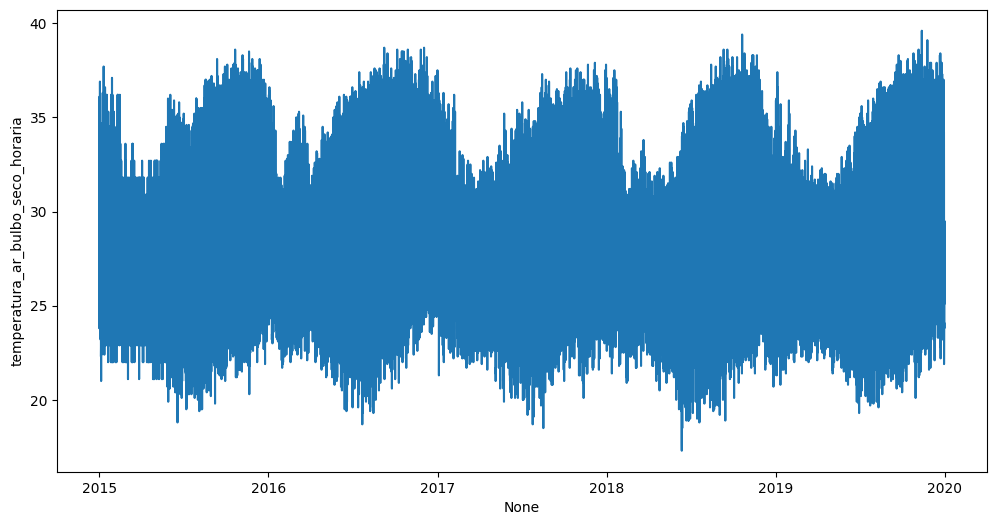

In [662]:
# Visualização de todos os 3 métodos de detecção de outliers sem separar por ano com eixo x correspondente ao índice
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_wo_pressure_outliers,
    x=df_wo_pressure_outliers.index,
    y="temperatura_ar_bulbo_seco_horaria",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

if normal:
    sns.scatterplot(
        data=df_wo_pressure_outliers.iloc[outliers_dp],
        x=df_wo_pressure_outliers.index[outliers_dp],
        y="temperatura_ar_bulbo_seco_horaria",
        color="red",
        markers=True,
        marker="o",
        label="Desvio Padrão",
    )
    sns.scatterplot(
        data=df_wo_pressure_outliers.iloc[outliers_normal],
        x=df_wo_pressure_outliers.index[outliers_normal],
        y="temperatura_ar_bulbo_seco_horaria",
        color="indigo",
        markers=True,
        marker="x",
        label="Distribuição Gaussiana",
    )
else:
    print("Não é normal")

sns.scatterplot(
        data=df_wo_pressure_outliers.iloc[outliers_iqr],
        x=df_wo_pressure_outliers.index[outliers_iqr],
        y="temperatura_ar_bulbo_seco_horaria",
        color="darkorange",
        markers=True,
        marker="d",
        label="IQR",
    )

In [663]:
# cálculo da % de outliers total
outliers_total = np.unique(
    np.concatenate((outliers_dp, outliers_iqr, outliers_normal))
)
# to int every element in outliers_total
outliers_total = outliers_total.astype(int)
print("Número de outliers total:", len(outliers_total))
print(
    "Porcentagem de outliers total:",
    round(len(outliers_total) / len(df_wo_pressure_outliers) * 100, 2),
    "%",
)

Número de outliers total: 0
Porcentagem de outliers total: 0.0 %


In [664]:
# Setando os outliers para NaN
df_wo_temperature_outliers = df_wo_pressure_outliers.copy()

df_wo_temperature_outliers.loc[
    df_wo_pressure_outliers.index[outliers_total],
    "pressao_atmosferica_nivel_estacao_horaria",
] = np.nan

#### 3.4.4. Umidade Relativa do ar

##### a) Visualização de Histograma / Boxplot / Boxenplot / Violinplot

<Axes: xlabel='umidade_relativa_ar_horaria'>

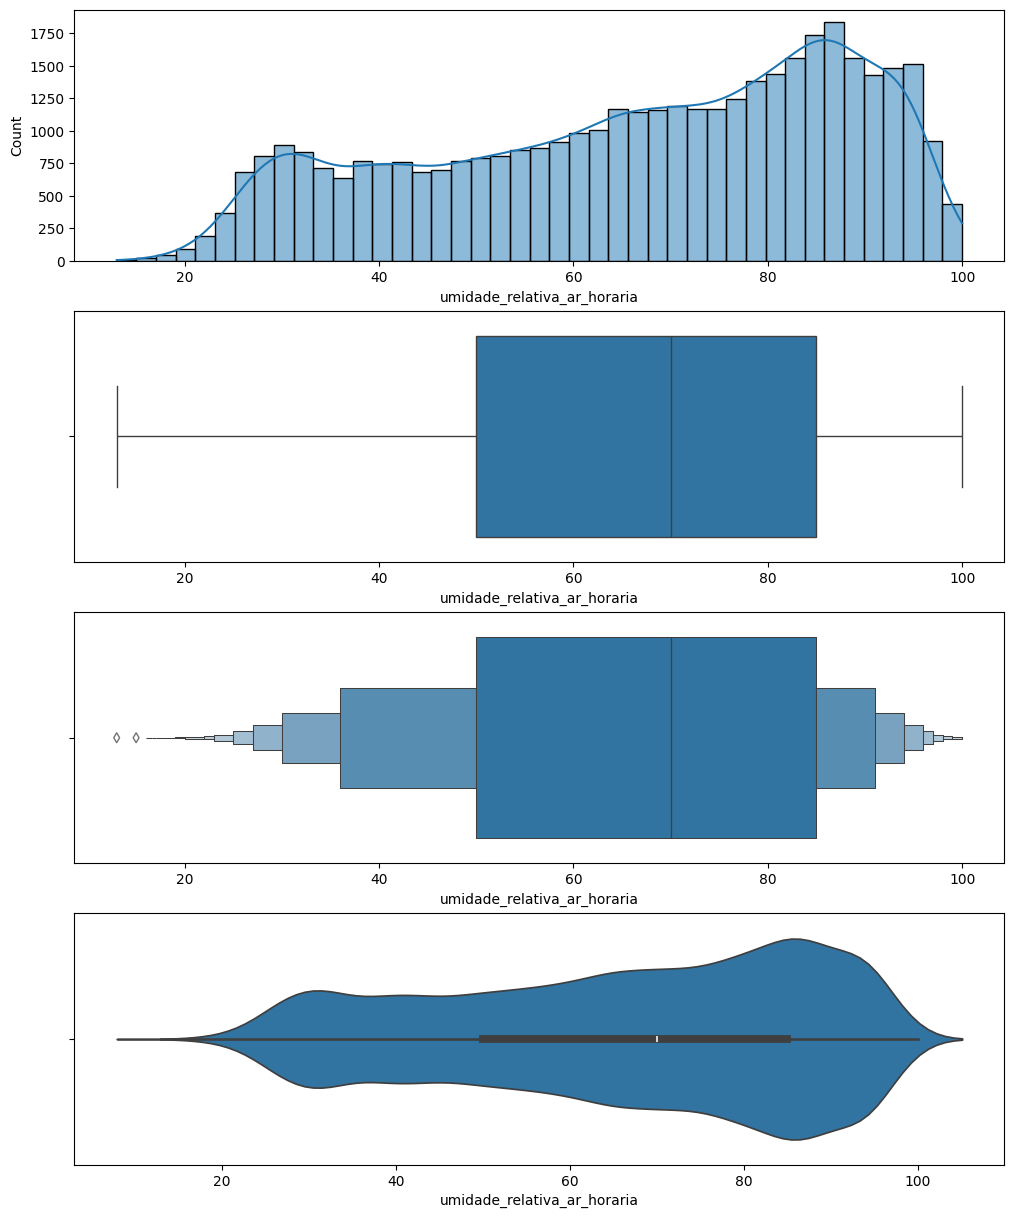

In [665]:
plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1)
sns.histplot(df_wo_temperature_outliers, x="umidade_relativa_ar_horaria", kde=True)
plt.subplot(4, 1, 2)
sns.boxplot(
    df_wo_temperature_outliers["umidade_relativa_ar_horaria"],
    orient="h",
    flierprops={"marker": "d", "markersize": 5, "color": "lightgray"},
)
plt.subplot(4, 1, 3)
sns.boxenplot(
    df_wo_temperature_outliers["umidade_relativa_ar_horaria"],
    orient="h",
    flier_kws={"marker": "d"},
    k_depth="tukey",
)
plt.subplot(4, 1, 4)
sns.violinplot(df_wo_temperature_outliers["umidade_relativa_ar_horaria"], orient="h")

##### b) Identificação de outliers via desvio padrão para distribuições normais

In [666]:
# Teste de normalidade
normal = test_normal(
    df_wo_temperature_outliers["umidade_relativa_ar_horaria"].dropna(
        inplace=False
    )
)

factor = config["outlier_detection"]["humidity"]["dp_factor"]
if normal:
    print("É normal, vamos usar o desvio padrão")
    outliers_dp = detect_outliers_dp(
        df_wo_temperature_outliers["umidade_relativa_ar_horaria"],
        factor=factor,
    )

    print("Número de outliers:", len(outliers_dp))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_dp) / len(df_wo_temperature_outliers) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_wo_temperature_outliers,
        x="dia_ano",
        y="umidade_relativa_ar_horaria",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_wo_temperature_outliers.iloc[outliers_dp],
        x="dia_ano",
        y="umidade_relativa_ar_horaria",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_dp = []
    print("Não é normal")

p-value: 0.0009999999999998899
t test: 0.09396301562588305
Reject null hypothesis. Data is not normal
Não é normal


##### c) Identificação de outliers via IQR

Número de outliers: 0
Porcentagem de outliers: 0.0 %


<Axes: xlabel='dia_ano', ylabel='umidade_relativa_ar_horaria'>

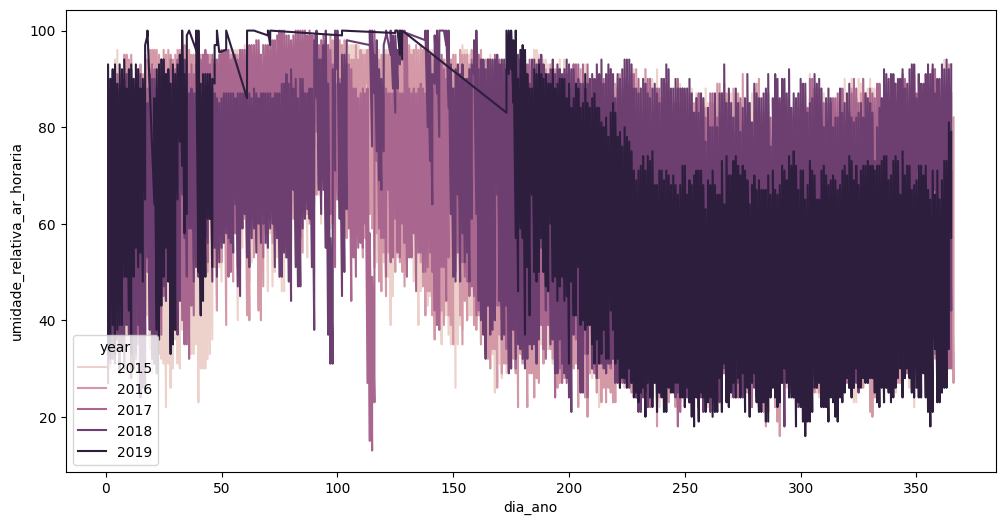

In [667]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_wo_temperature_outliers,
    x="dia_ano",
    y="umidade_relativa_ar_horaria",
    hue="year",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

iqr_factor = config["outlier_detection"]["humidity"]["iqr_factor"]
outliers_iqr = detect_outliers_iqr(
    df_wo_temperature_outliers["umidade_relativa_ar_horaria"],
    factor=iqr_factor,
)

print("Número de outliers:", len(outliers_iqr))
print(
    "Porcentagem de outliers:",
    round(len(outliers_iqr) / len(df_wo_temperature_outliers) * 100, 2),
    "%",
)

# outl são índices dos outliers, quero um scatterplot
sns.scatterplot(
    data=df_wo_temperature_outliers.iloc[outliers_iqr],
    x="dia_ano",
    y="umidade_relativa_ar_horaria",
    style="year",
    color="red",
    markers=True,
)

##### d) Identificação de outliers via distribuição normal

In [668]:
epsilon = config["outlier_detection"]["humidity"]["epsilon"]
if normal:
    print("É normal, vamos usar a dist Gaussiana")
    outliers_normal = detect_outlier_Normal(
        df_wo_temperature_outliers["umidade_relativa_ar_horaria"],
        epsilon=epsilon,
        plotdist=False,
    )

    print("Número de outliers:", len(outliers_normal))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_normal) / len(df_wo_temperature_outliers) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_wo_temperature_outliers,
        x="dia_ano",
        y="umidade_relativa_ar_horaria",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_wo_temperature_outliers.iloc[outliers_normal],
        x="dia_ano",
        y="umidade_relativa_ar_horaria",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_normal = []
    print("Não é normal")

Não é normal


##### e) União dos 3 métodos de detecção e remoção dos outliers

Não é normal


<Axes: xlabel='None', ylabel='umidade_relativa_ar_horaria'>

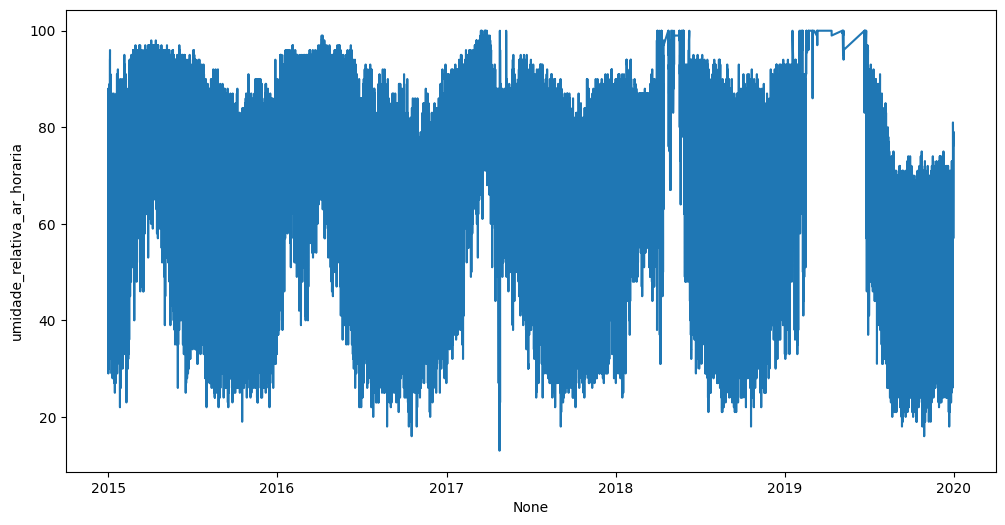

In [669]:
# Visualização de todos os 3 métodos de detecção de outliers sem separar por ano com eixo x correspondente ao índice
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_wo_temperature_outliers,
    x=df_wo_temperature_outliers.index,
    y="umidade_relativa_ar_horaria",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

if normal:
    sns.scatterplot(
        data=df_wo_temperature_outliers.iloc[outliers_dp],
        x=df_wo_temperature_outliers.index[outliers_dp],
        y="umidade_relativa_ar_horaria",
        color="red",
        markers=True,
        marker="o",
        label="Desvio Padrão",
    )
    sns.scatterplot(
        data=df_wo_temperature_outliers.iloc[outliers_normal],
        x=df_wo_temperature_outliers.index[outliers_normal],
        y="umidade_relativa_ar_horaria",
        color="indigo",
        markers=True,
        marker="x",
        label="Distribuição Gaussiana",
    )
else:
    print("Não é normal")

sns.scatterplot(
        data=df_wo_temperature_outliers.iloc[outliers_iqr],
        x=df_wo_temperature_outliers.index[outliers_iqr],
        y="umidade_relativa_ar_horaria",
        color="darkorange",
        markers=True,
        marker="d",
        label="IQR",
    )

In [670]:
# cálculo da % de outliers total
outliers_total = np.unique(
    np.concatenate((outliers_dp, outliers_iqr, outliers_normal))
)
# to int every element in outliers_total
outliers_total = outliers_total.astype(int)
print("Número de outliers total:", len(outliers_total))
print(
    "Porcentagem de outliers total:",
    round(len(outliers_total) / len(df_wo_temperature_outliers) * 100, 2),
    "%",
)

Número de outliers total: 0
Porcentagem de outliers total: 0.0 %


In [671]:
# Setando os outliers para NaN
df_wo_humidity_outliers = df_wo_temperature_outliers.copy()

df_wo_humidity_outliers.loc[
    df_wo_temperature_outliers.index[outliers_total],
    "pressao_atmosferica_nivel_estacao_horaria",
] = np.nan

#### 3.4.5. Direção do Vento

##### a) Visualização de Histograma / Boxplot / Boxenplot / Violinplot

<Axes: xlabel='vento_direcao_horaria'>

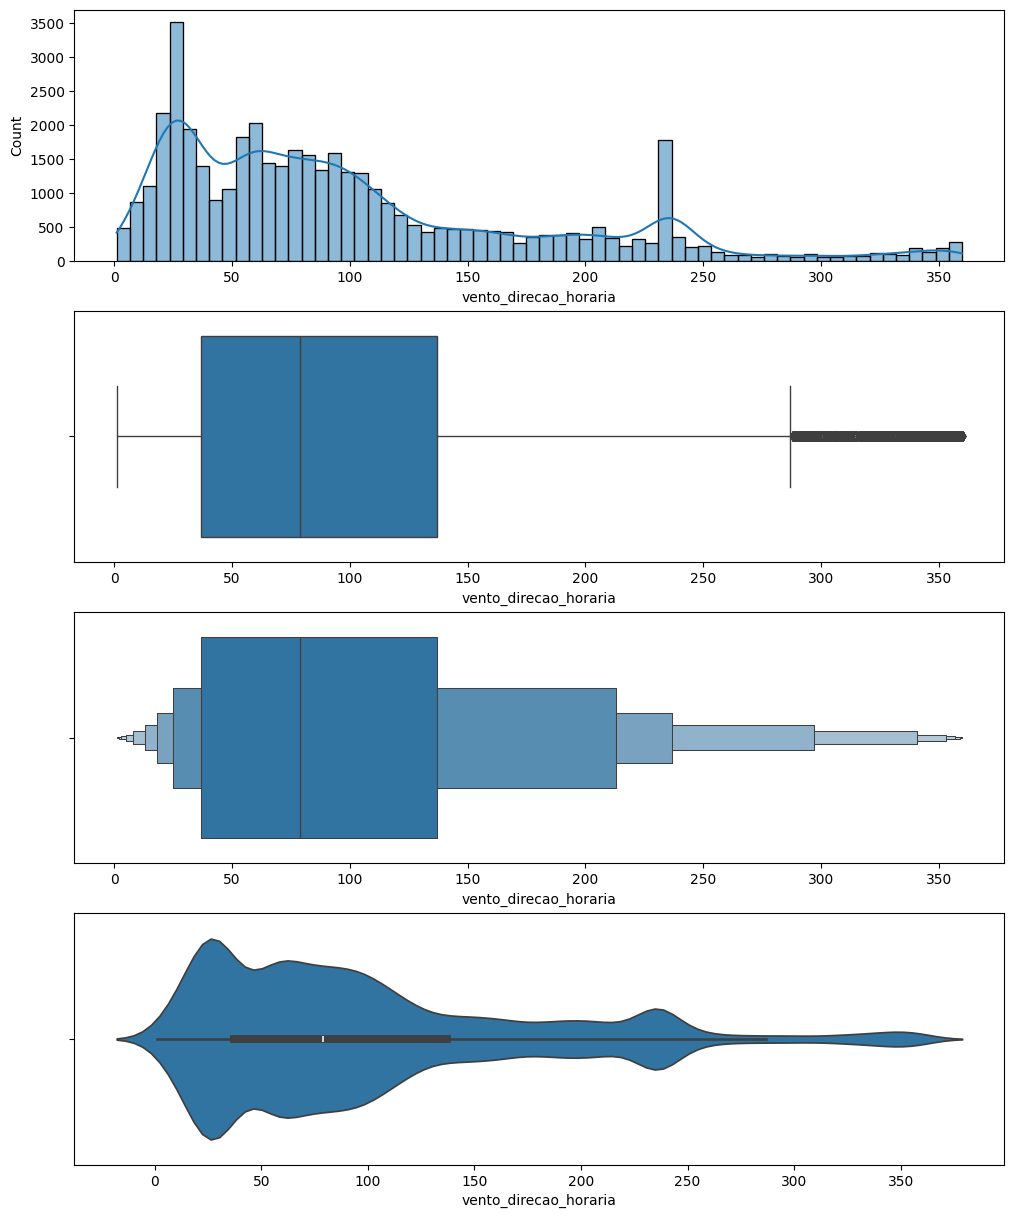

In [672]:
plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1)
sns.histplot(df_wo_humidity_outliers, x="vento_direcao_horaria", kde=True)
plt.subplot(4, 1, 2)
sns.boxplot(
    df_wo_humidity_outliers["vento_direcao_horaria"],
    orient="h",
    flierprops={"marker": "d", "markersize": 5, "color": "lightgray"},
)
plt.subplot(4, 1, 3)
sns.boxenplot(
    df_wo_humidity_outliers["vento_direcao_horaria"],
    orient="h",
    flier_kws={"marker": "d"},
    k_depth="tukey",
)
plt.subplot(4, 1, 4)
sns.violinplot(df_wo_humidity_outliers["vento_direcao_horaria"], orient="h")

##### b) Identificação de outliers via desvio padrão para distribuições normais

In [673]:
# Teste de normalidade
normal = test_normal(
    df_wo_humidity_outliers["vento_direcao_horaria"].dropna(
        inplace=False
    )
)

factor = config["outlier_detection"]["wind_direction"]["dp_factor"]
if normal:
    print("É normal, vamos usar o desvio padrão")
    outliers_dp = detect_outliers_dp(
        df_wo_humidity_outliers["vento_direcao_horaria"],
        factor=factor,
    )

    print("Número de outliers:", len(outliers_dp))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_dp) / len(df_wo_humidity_outliers) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_wo_humidity_outliers,
        x="dia_ano",
        y="vento_direcao_horaria",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_wo_humidity_outliers.iloc[outliers_dp],
        x="dia_ano",
        y="vento_direcao_horaria",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_dp = []
    print("Não é normal")

p-value: 0.0009999999999998899
t test: 0.13600299122870552
Reject null hypothesis. Data is not normal
Não é normal


##### c) Identificação de outliers via IQR

Número de outliers: 475
Porcentagem de outliers: 1.08 %


<Axes: xlabel='dia_ano', ylabel='vento_direcao_horaria'>

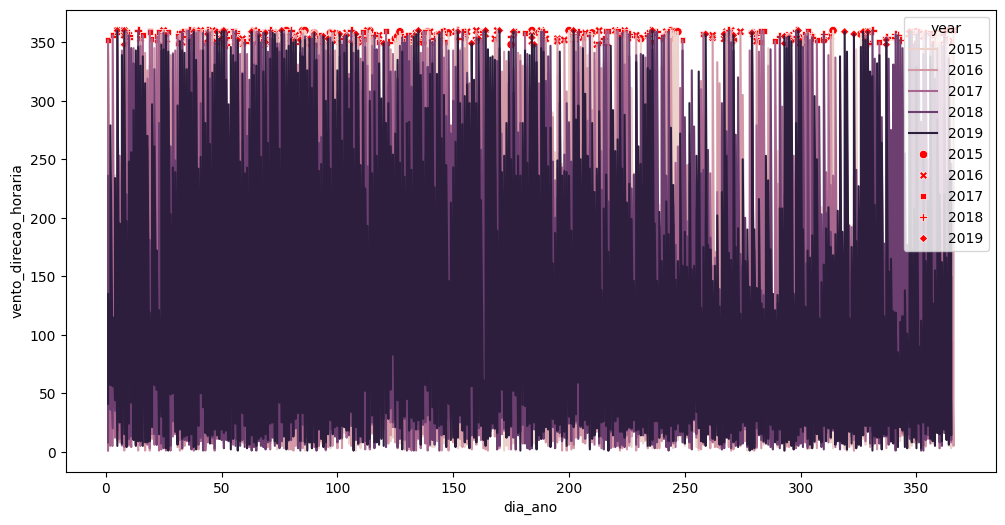

In [674]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_wo_humidity_outliers,
    x="dia_ano",
    y="vento_direcao_horaria",
    hue="year",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

iqr_factor = config["outlier_detection"]["wind_direction"]["iqr_factor"]
outliers_iqr = detect_outliers_iqr(
    df_wo_humidity_outliers["vento_direcao_horaria"],
    factor=iqr_factor,
)

print("Número de outliers:", len(outliers_iqr))
print(
    "Porcentagem de outliers:",
    round(len(outliers_iqr) / len(df_wo_humidity_outliers) * 100, 2),
    "%",
)

# outl são índices dos outliers, quero um scatterplot
sns.scatterplot(
    data=df_wo_humidity_outliers.iloc[outliers_iqr],
    x="dia_ano",
    y="vento_direcao_horaria",
    style="year",
    color="red",
    markers=True,
)

##### d) Identificação de outliers via distribuição normal

In [675]:
epsilon = config["outlier_detection"]["wind_direction"]["epsilon"]
if normal:
    print("É normal, vamos usar a dist Gaussiana")
    outliers_normal = detect_outlier_Normal(
        df_wo_humidity_outliers["vento_direcao_horaria"],
        epsilon=epsilon,
        plotdist=False,
    )

    print("Número de outliers:", len(outliers_normal))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_normal) / len(df_wo_humidity_outliers) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_wo_humidity_outliers,
        x="dia_ano",
        y="vento_direcao_horaria",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_wo_humidity_outliers.iloc[outliers_normal],
        x="dia_ano",
        y="vento_direcao_horaria",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_normal = []
    print("Não é normal")

Não é normal


##### e) União dos 3 métodos de detecção e remoção dos outliers

Não é normal


<Axes: xlabel='None', ylabel='vento_direcao_horaria'>

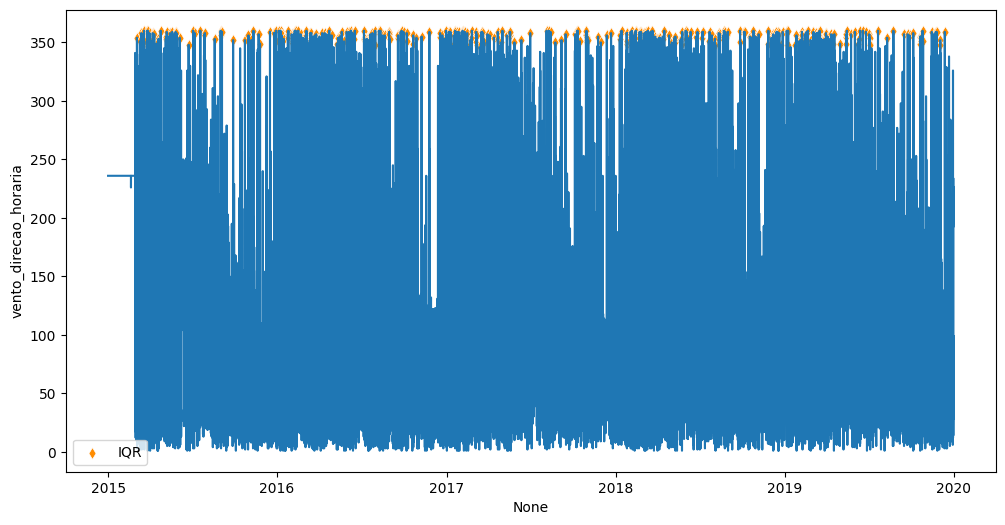

In [676]:
# Visualização de todos os 3 métodos de detecção de outliers sem separar por ano com eixo x correspondente ao índice
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_wo_humidity_outliers,
    x=df_wo_humidity_outliers.index,
    y="vento_direcao_horaria",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

if normal:
    sns.scatterplot(
        data=df_wo_humidity_outliers.iloc[outliers_dp],
        x=df_wo_humidity_outliers.index[outliers_dp],
        y="vento_direcao_horaria",
        color="red",
        markers=True,
        marker="o",
        label="Desvio Padrão",
    )
    sns.scatterplot(
        data=df_wo_humidity_outliers.iloc[outliers_normal],
        x=df_wo_humidity_outliers.index[outliers_normal],
        y="vento_direcao_horaria",
        color="indigo",
        markers=True,
        marker="x",
        label="Distribuição Gaussiana",
    )
else:
    print("Não é normal")

sns.scatterplot(
        data=df_wo_humidity_outliers.iloc[outliers_iqr],
        x=df_wo_humidity_outliers.index[outliers_iqr],
        y="vento_direcao_horaria",
        color="darkorange",
        markers=True,
        marker="d",
        label="IQR",
    )

In [677]:
# cálculo da % de outliers total
outliers_total = np.unique(
    np.concatenate((outliers_dp, outliers_iqr, outliers_normal))
)
# to int every element in outliers_total
outliers_total = outliers_total.astype(int)
print("Número de outliers total:", len(outliers_total))
print(
    "Porcentagem de outliers total:",
    round(len(outliers_total) / len(df_wo_humidity_outliers) * 100, 2),
    "%",
)

Número de outliers total: 475
Porcentagem de outliers total: 1.08 %


In [678]:
# Setando os outliers para NaN
df_wo_winddir_outliers = df_wo_temperature_outliers.copy()

df_wo_winddir_outliers.loc[
    df_wo_temperature_outliers.index[outliers_total],
    "vento_direcao_horaria",
] = np.nan

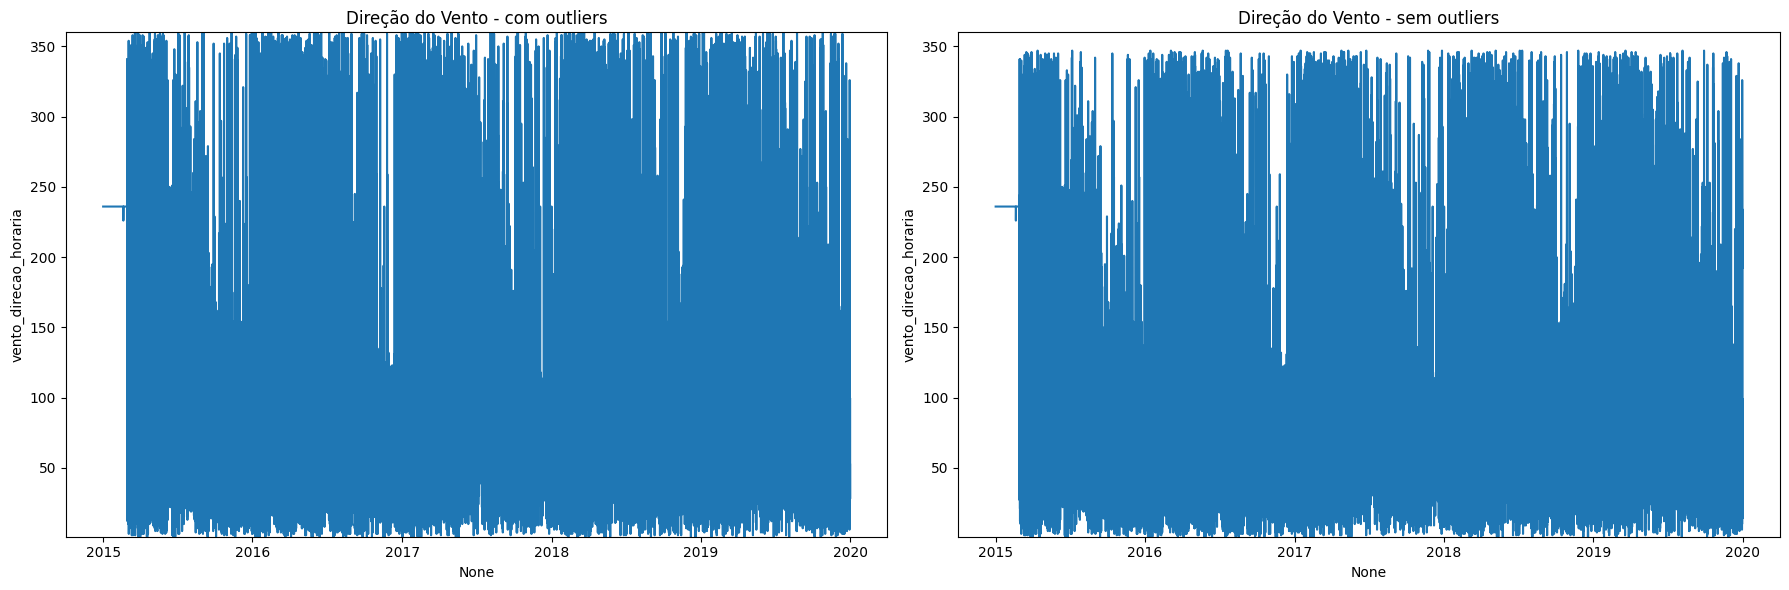

In [679]:
# Criando a figura e a grade de subgráficos
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 linha, 2 colunas

# Plot para anterior
sns.lineplot(
    data=df_wo_humidity_outliers,
    x=df_wo_humidity_outliers.index,
    y="vento_direcao_horaria",
    errorbar=None,
    estimator=None,
    ax=axes[0],  # Primeiro gráfico
)
axes[0].set_title("Direção do Vento - com outliers")

# Plot para após
sns.lineplot(
    data=df_wo_winddir_outliers,
    x=df_wo_winddir_outliers.index,
    y="vento_direcao_horaria",
    errorbar=None,
    estimator=None,
    ax=axes[1],  # Segundo gráfico
)
axes[1].set_title("Direção do Vento - sem outliers")

# Ajustando o limite do eixo y para ambos os gráficos (usando o valor do eixo y de df_wo_humidity_outliers)
y_min = min(
    df_wo_humidity_outliers["vento_direcao_horaria"].min(),
    df_wo_winddir_outliers["vento_direcao_horaria"].min(),
)
y_max = max(
    df_wo_humidity_outliers["vento_direcao_horaria"].max(),
    df_wo_winddir_outliers["vento_direcao_horaria"].max(),
)

# Definindo os limites do eixo y para ambos os gráficos
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

# Exibindo os gráficos
plt.tight_layout()
plt.show()

#### 3.4.6. Rajada do Vento

##### a) Visualização de Histograma / Boxplot / Boxenplot / Violinplot

<Axes: xlabel='vento_rajada_maxima'>

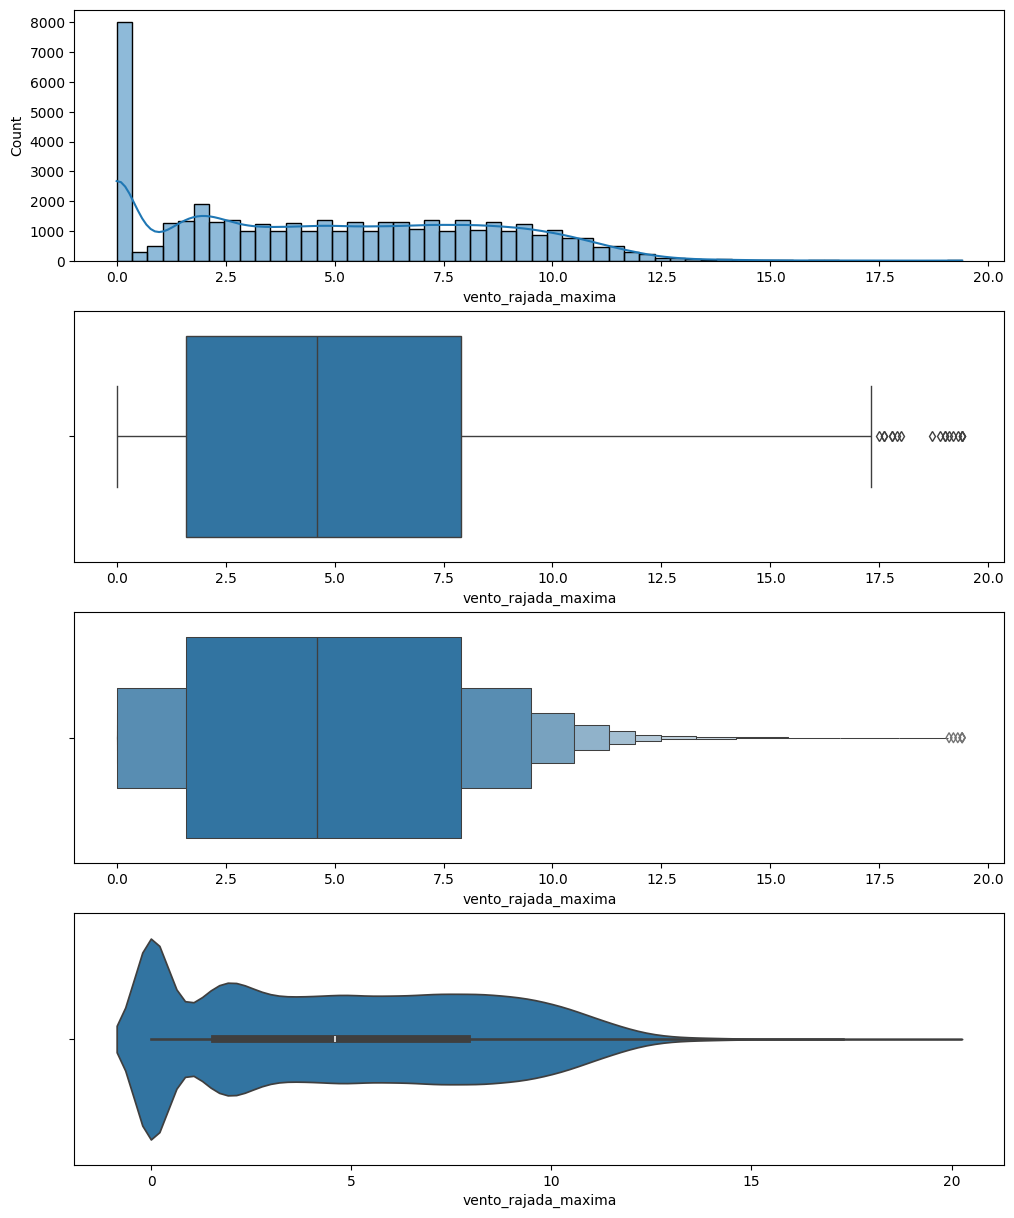

In [680]:
plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1)
sns.histplot(df_wo_winddir_outliers, x="vento_rajada_maxima", kde=True)
plt.subplot(4, 1, 2)
sns.boxplot(
    df_wo_winddir_outliers["vento_rajada_maxima"],
    orient="h",
    flierprops={"marker": "d", "markersize": 5, "color": "lightgray"},
)
plt.subplot(4, 1, 3)
sns.boxenplot(
    df_wo_winddir_outliers["vento_rajada_maxima"],
    orient="h",
    flier_kws={"marker": "d"},
    k_depth="tukey",
)
plt.subplot(4, 1, 4)
sns.violinplot(df_wo_winddir_outliers["vento_rajada_maxima"], orient="h")

##### b) Identificação de outliers via desvio padrão para distribuições normais

In [681]:
# Teste de normalidade
normal = test_normal(
    df_wo_winddir_outliers["vento_rajada_maxima"].dropna(
        inplace=False
    )
)

factor = config["outlier_detection"]["wind_max"]["dp_factor"]
if normal:
    print("É normal, vamos usar o desvio padrão")
    outliers_dp = detect_outliers_dp(
        df_wo_winddir_outliers["vento_rajada_maxima"],
        factor=factor,
    )

    print("Número de outliers:", len(outliers_dp))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_dp) / len(df_wo_winddir_outliers) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_wo_winddir_outliers,
        x="dia_ano",
        y="vento_rajada_maxima",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_wo_winddir_outliers.iloc[outliers_dp],
        x="dia_ano",
        y="vento_rajada_maxima",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_dp = []
    print("Não é normal")

p-value: 0.0009999999999998899
t test: 0.09379452119011988
Reject null hypothesis. Data is not normal
Não é normal


##### c) Identificação de outliers via IQR

Número de outliers: 17
Porcentagem de outliers: 0.04 %


<Axes: xlabel='dia_ano', ylabel='vento_rajada_maxima'>

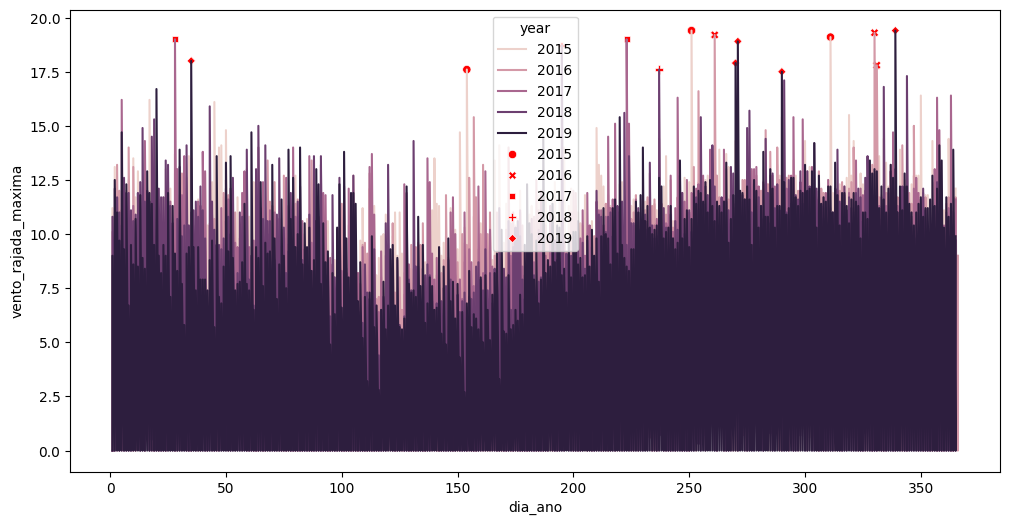

In [682]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_wo_winddir_outliers,
    x="dia_ano",
    y="vento_rajada_maxima",
    hue="year",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

iqr_factor = config["outlier_detection"]["wind_max"]["iqr_factor"]
outliers_iqr = detect_outliers_iqr(
    df_wo_winddir_outliers["vento_rajada_maxima"],
    factor=iqr_factor,
)

print("Número de outliers:", len(outliers_iqr))
print(
    "Porcentagem de outliers:",
    round(len(outliers_iqr) / len(df_wo_winddir_outliers) * 100, 2),
    "%",
)

# outl são índices dos outliers, quero um scatterplot
sns.scatterplot(
    data=df_wo_winddir_outliers.iloc[outliers_iqr],
    x="dia_ano",
    y="vento_rajada_maxima",
    style="year",
    color="red",
    markers=True,
)

##### d) Identificação de outliers via distribuição normal

In [683]:
epsilon = config["outlier_detection"]["wind_max"]["epsilon"]
if normal:
    print("É normal, vamos usar a dist Gaussiana")
    outliers_normal = detect_outlier_Normal(
        df_wo_winddir_outliers["vento_rajada_maxima"],
        epsilon=epsilon,
        plotdist=False,
    )

    print("Número de outliers:", len(outliers_normal))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_normal) / len(df_wo_winddir_outliers) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_wo_winddir_outliers,
        x="dia_ano",
        y="vento_rajada_maxima",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_wo_winddir_outliers.iloc[outliers_normal],
        x="dia_ano",
        y="vento_rajada_maxima",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_normal = []
    print("Não é normal")

Não é normal


##### e) União dos 3 métodos de detecção e remoção dos outliers

Não é normal


<Axes: xlabel='None', ylabel='vento_rajada_maxima'>

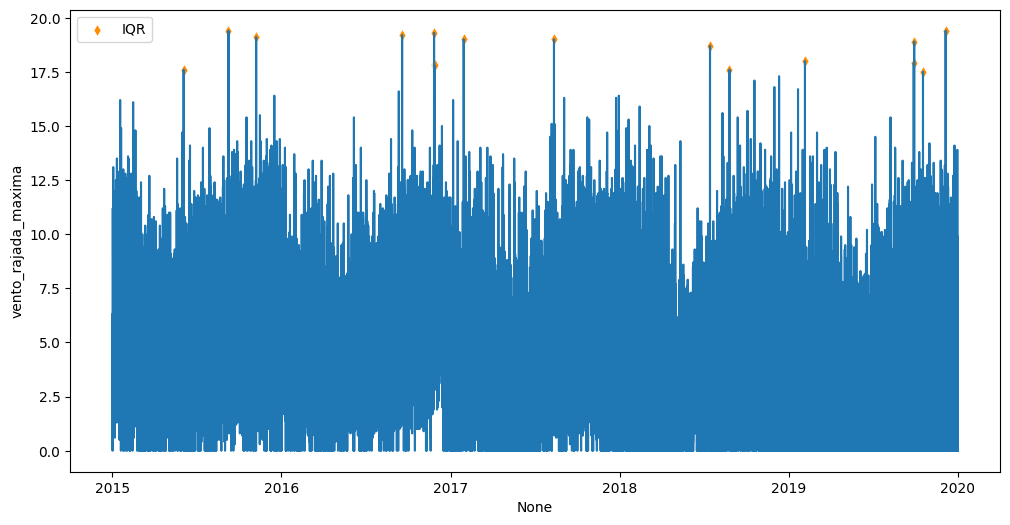

In [684]:
# Visualização de todos os 3 métodos de detecção de outliers sem separar por ano com eixo x correspondente ao índice
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_wo_winddir_outliers,
    x=df_wo_winddir_outliers.index,
    y="vento_rajada_maxima",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

if normal:
    sns.scatterplot(
        data=df_wo_winddir_outliers.iloc[outliers_dp],
        x=df_wo_winddir_outliers.index[outliers_dp],
        y="vento_rajada_maxima",
        color="red",
        markers=True,
        marker="o",
        label="Desvio Padrão",
    )
    sns.scatterplot(
        data=df_wo_winddir_outliers.iloc[outliers_normal],
        x=df_wo_winddir_outliers.index[outliers_normal],
        y="vento_rajada_maxima",
        color="indigo",
        markers=True,
        marker="x",
        label="Distribuição Gaussiana",
    )
else:
    print("Não é normal")

sns.scatterplot(
        data=df_wo_winddir_outliers.iloc[outliers_iqr],
        x=df_wo_winddir_outliers.index[outliers_iqr],
        y="vento_rajada_maxima",
        color="darkorange",
        markers=True,
        marker="d",
        label="IQR",
    )

In [685]:
# cálculo da % de outliers total
outliers_total = np.unique(
    np.concatenate((outliers_dp, outliers_iqr, outliers_normal))
)
# to int every element in outliers_total
outliers_total = outliers_total.astype(int)
print("Número de outliers total:", len(outliers_total))
print(
    "Porcentagem de outliers total:",
    round(len(outliers_total) / len(df_wo_winddir_outliers) * 100, 2),
    "%",
)

Número de outliers total: 17
Porcentagem de outliers total: 0.04 %


In [686]:
# Setando os outliers para NaN
df_wo_windmax_outliers = df_wo_winddir_outliers.copy()

df_wo_windmax_outliers.loc[
    df_wo_winddir_outliers.index[outliers_total],
    "vento_rajada_maxima",
] = np.nan

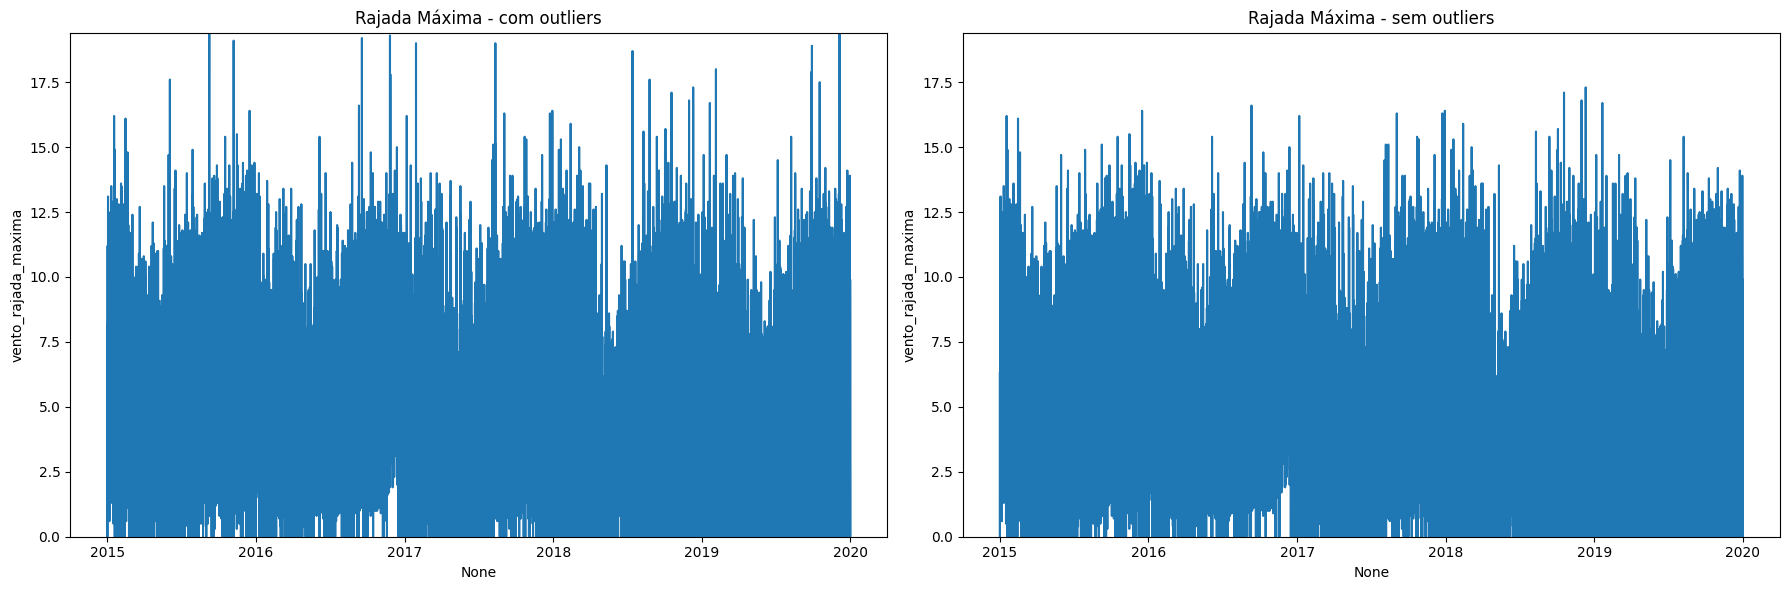

In [687]:
# Criando a figura e a grade de subgráficos
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 linha, 2 colunas

# Plot para anterior
sns.lineplot(
    data=df_wo_winddir_outliers,
    x=df_wo_winddir_outliers.index,
    y="vento_rajada_maxima",
    errorbar=None,
    estimator=None,
    ax=axes[0],  # Primeiro gráfico
)
axes[0].set_title("Rajada Máxima - com outliers")

# Plot para após
sns.lineplot(
    data=df_wo_windmax_outliers,
    x=df_wo_windmax_outliers.index,
    y="vento_rajada_maxima",
    errorbar=None,
    estimator=None,
    ax=axes[1],  # Segundo gráfico
)
axes[1].set_title("Rajada Máxima - sem outliers")

# Ajustando o limite do eixo y para ambos os gráficos (usando o valor do eixo y de df_wo_winddir_outliers)
y_min = min(
    df_wo_winddir_outliers["vento_rajada_maxima"].min(),
    df_wo_winddir_outliers["vento_rajada_maxima"].min(),
)
y_max = max(
    df_wo_winddir_outliers["vento_rajada_maxima"].max(),
    df_wo_winddir_outliers["vento_rajada_maxima"].max(),
)

# Definindo os limites do eixo y para ambos os gráficos
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

# Exibindo os gráficos
plt.tight_layout()
plt.show()

#### 3.4.7. Velocidade do Vento

##### a) Visualização de Histograma / Boxplot / Boxenplot / Violinplot

<Axes: xlabel='vento_velocidade_horaria'>

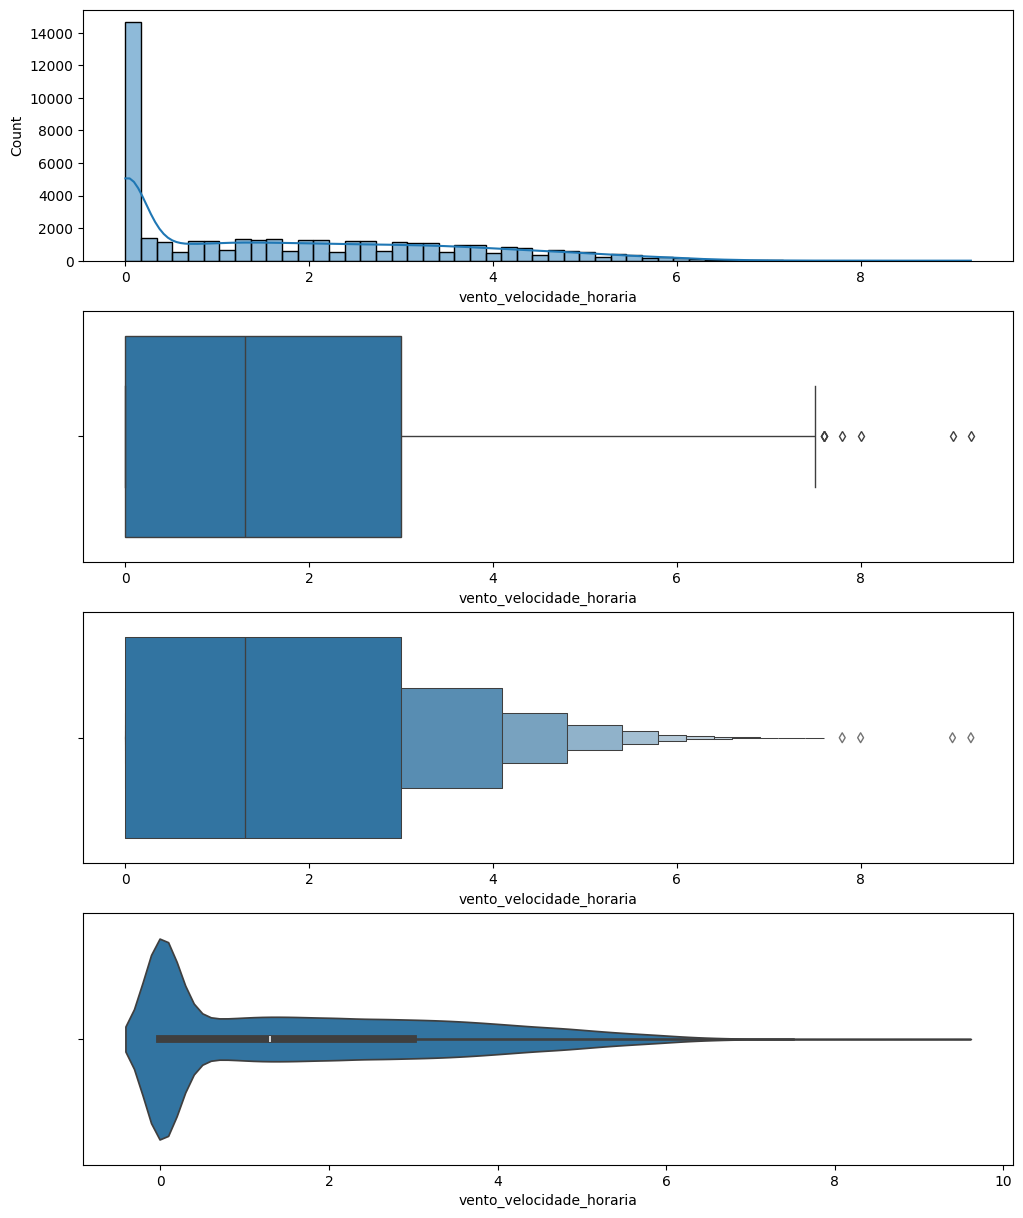

In [688]:
plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1)
sns.histplot(df_wo_windmax_outliers, x="vento_velocidade_horaria", kde=True)
plt.subplot(4, 1, 2)
sns.boxplot(
    df_wo_windmax_outliers["vento_velocidade_horaria"],
    orient="h",
    flierprops={"marker": "d", "markersize": 5, "color": "lightgray"},
)
plt.subplot(4, 1, 3)
sns.boxenplot(
    df_wo_windmax_outliers["vento_velocidade_horaria"],
    orient="h",
    flier_kws={"marker": "d"},
    k_depth="tukey",
)
plt.subplot(4, 1, 4)
sns.violinplot(df_wo_windmax_outliers["vento_velocidade_horaria"], orient="h")

##### b) Identificação de outliers via desvio padrão para distribuições normais

In [689]:
# Teste de normalidade
normal = test_normal(
    df_wo_windmax_outliers["vento_velocidade_horaria"].dropna(
        inplace=False
    )
)

factor = config["outlier_detection"]["wind_speed"]["dp_factor"]
if normal:
    print("É normal, vamos usar o desvio padrão")
    outliers_dp = detect_outliers_dp(
        df_wo_windmax_outliers["vento_velocidade_horaria"],
        factor=factor,
    )

    print("Número de outliers:", len(outliers_dp))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_dp) / len(df_wo_windmax_outliers) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_wo_windmax_outliers,
        x="dia_ano",
        y="vento_velocidade_horaria",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_wo_windmax_outliers.iloc[outliers_dp],
        x="dia_ano",
        y="vento_velocidade_horaria",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_dp = []
    print("Não é normal")

p-value: 0.0009999999999998899
t test: 0.16501131394150398
Reject null hypothesis. Data is not normal
Não é normal


##### c) Identificação de outliers via IQR

Número de outliers: 7
Porcentagem de outliers: 0.02 %


<Axes: xlabel='dia_ano', ylabel='vento_velocidade_horaria'>

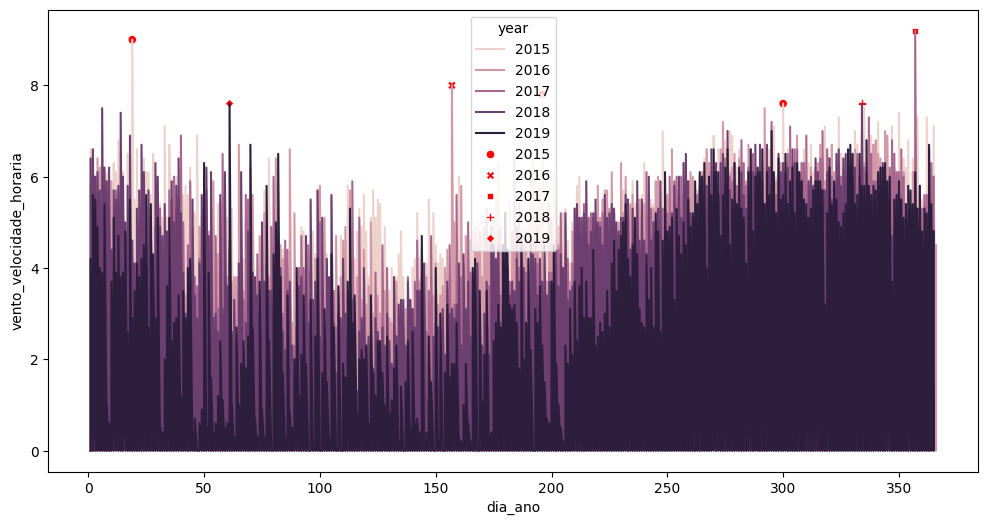

In [690]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_wo_windmax_outliers,
    x="dia_ano",
    y="vento_velocidade_horaria",
    hue="year",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

iqr_factor = config["outlier_detection"]["wind_speed"]["iqr_factor"]
outliers_iqr = detect_outliers_iqr(
    df_wo_windmax_outliers["vento_velocidade_horaria"],
    factor=iqr_factor,
)

print("Número de outliers:", len(outliers_iqr))
print(
    "Porcentagem de outliers:",
    round(len(outliers_iqr) / len(df_wo_windmax_outliers) * 100, 2),
    "%",
)

# outl são índices dos outliers, quero um scatterplot
sns.scatterplot(
    data=df_wo_windmax_outliers.iloc[outliers_iqr],
    x="dia_ano",
    y="vento_velocidade_horaria",
    style="year",
    color="red",
    markers=True,
)

##### d) Identificação de outliers via distribuição normal

In [691]:
epsilon = config["outlier_detection"]["wind_speed"]["epsilon"]
if normal:
    print("É normal, vamos usar a dist Gaussiana")
    outliers_normal = detect_outlier_Normal(
        df_wo_windmax_outliers["vento_velocidade_horaria"],
        epsilon=epsilon,
        plotdist=False,
    )

    print("Número de outliers:", len(outliers_normal))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_normal) / len(df_wo_windmax_outliers) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_wo_windmax_outliers,
        x="dia_ano",
        y="vento_velocidade_horaria",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_wo_windmax_outliers.iloc[outliers_normal],
        x="dia_ano",
        y="vento_velocidade_horaria",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_normal = []
    print("Não é normal")

Não é normal


##### e) União dos 3 métodos de detecção e remoção dos outliers

Não é normal


<Axes: xlabel='None', ylabel='vento_velocidade_horaria'>

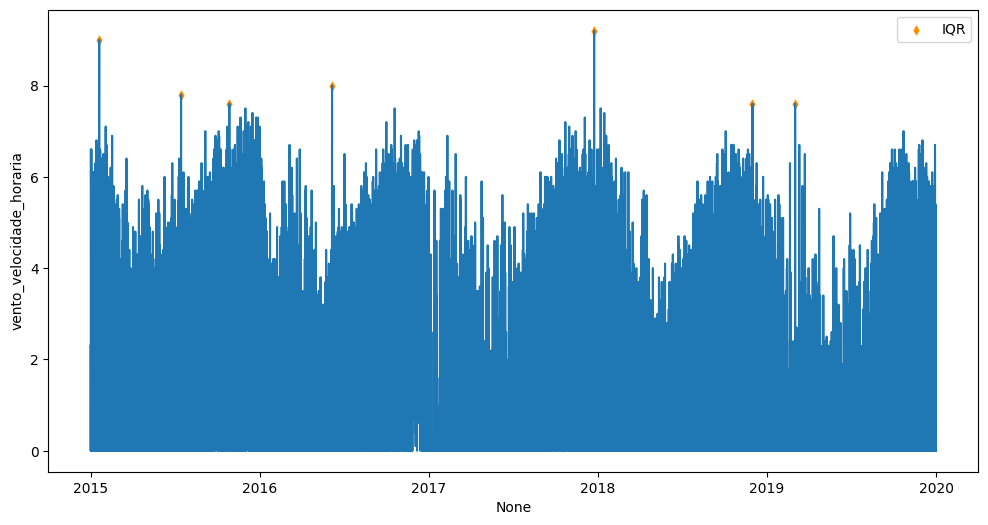

In [692]:
# Visualização de todos os 3 métodos de detecção de outliers sem separar por ano com eixo x correspondente ao índice
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_wo_windmax_outliers,
    x=df_wo_windmax_outliers.index,
    y="vento_velocidade_horaria",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

if normal:
    sns.scatterplot(
        data=df_wo_windmax_outliers.iloc[outliers_dp],
        x=df_wo_windmax_outliers.index[outliers_dp],
        y="vento_velocidade_horaria",
        color="red",
        markers=True,
        marker="o",
        label="Desvio Padrão",
    )
    sns.scatterplot(
        data=df_wo_windmax_outliers.iloc[outliers_normal],
        x=df_wo_windmax_outliers.index[outliers_normal],
        y="vento_velocidade_horaria",
        color="indigo",
        markers=True,
        marker="x",
        label="Distribuição Gaussiana",
    )
else:
    print("Não é normal")

sns.scatterplot(
        data=df_wo_windmax_outliers.iloc[outliers_iqr],
        x=df_wo_windmax_outliers.index[outliers_iqr],
        y="vento_velocidade_horaria",
        color="darkorange",
        markers=True,
        marker="d",
        label="IQR",
    )

In [693]:
# cálculo da % de outliers total
outliers_total = np.unique(
    np.concatenate((outliers_dp, outliers_iqr, outliers_normal))
)
# to int every element in outliers_total
outliers_total = outliers_total.astype(int)
print("Número de outliers total:", len(outliers_total))
print(
    "Porcentagem de outliers total:",
    round(len(outliers_total) / len(df_wo_windmax_outliers) * 100, 2),
    "%",
)

Número de outliers total: 7
Porcentagem de outliers total: 0.02 %


In [694]:
# Setando os outliers para NaN
df_wo_windspeed_outliers = df_wo_windmax_outliers.copy()

df_wo_windspeed_outliers.loc[
    df_wo_windmax_outliers.index[outliers_total],
    "vento_velocidade_horaria",
] = np.nan

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


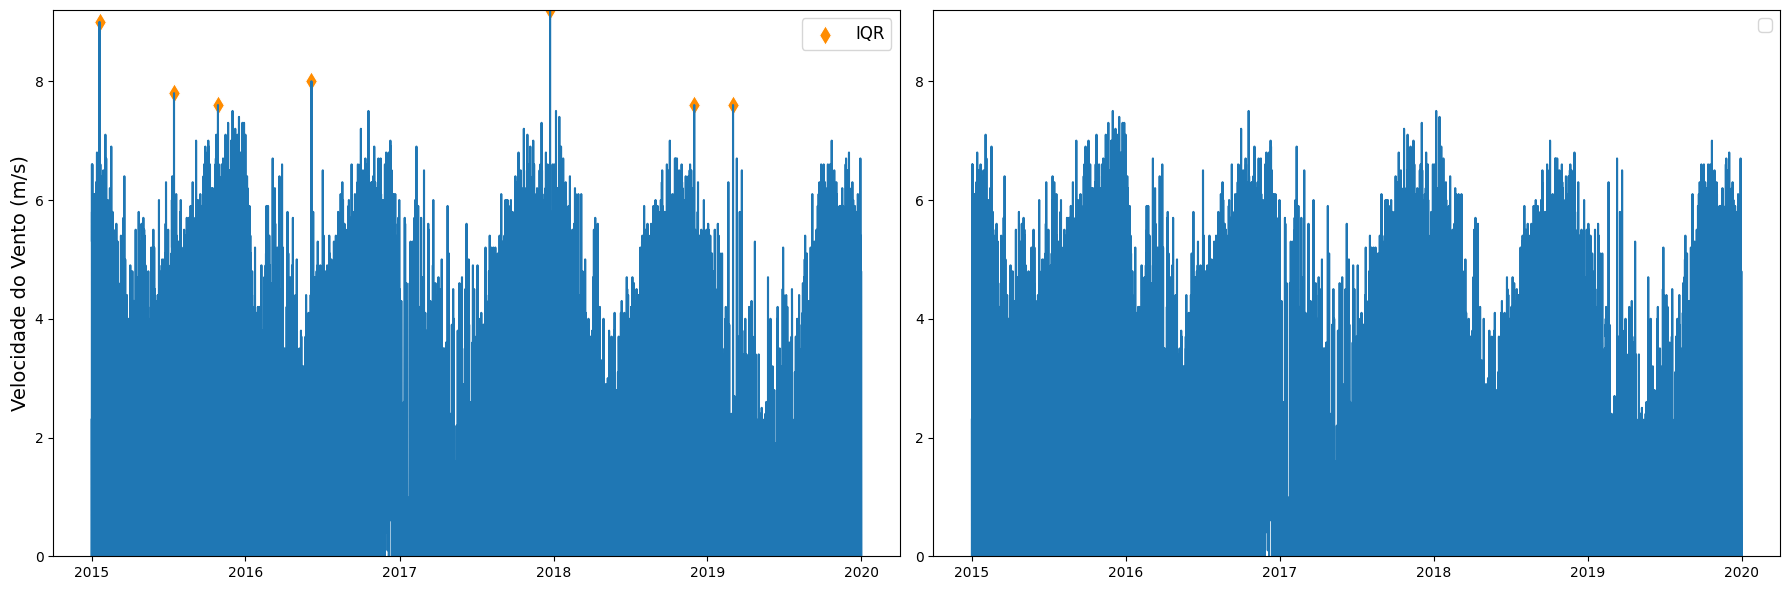

In [695]:
# Criando a figura e a grade de subgráficos
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 linha, 2 colunas

# Plot para anterior
sns.lineplot(
    data=df_wo_windmax_outliers,
    x=df_wo_windmax_outliers.index,
    y="vento_velocidade_horaria",
    errorbar=None,
    estimator=None,
    ax=axes[0],  # Primeiro gráfico
)
sns.scatterplot(
        data=df_wo_windmax_outliers.iloc[outliers_iqr],
        x=df_wo_windmax_outliers.index[outliers_iqr],
        y="vento_velocidade_horaria",
        color="darkorange",
        markers=True,
        marker="d",
        label="IQR",
        ax=axes[0],
        s=100
    )
axes[0].set_title("Velocidade do Vento - com outliers", fontsize=16)
axes[0].set_ylabel("Velocidade do Vento (m/s)", fontsize=14)

# Plot para após
sns.lineplot(
    data=df_wo_windspeed_outliers,
    x=df_wo_windspeed_outliers.index,
    y="vento_velocidade_horaria",
    errorbar=None,
    estimator=None,
    ax=axes[1],  # Segundo gráfico
)
axes[1].set_title("Velocidade do Vento - sem outliers", fontsize=16)

# Ajustando o limite do eixo y para ambos os gráficos (usando o valor do eixo y de df_wo_windmax_outliers)
y_min = min(
    df_wo_windmax_outliers["vento_velocidade_horaria"].min(),
    df_wo_windmax_outliers["vento_velocidade_horaria"].min(),
)
y_max = max(
    df_wo_windmax_outliers["vento_velocidade_horaria"].max(),
    df_wo_windmax_outliers["vento_velocidade_horaria"].max(),
)

# Definindo os limites do eixo y para ambos os gráficos
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

# sem título e sem eixo x
axes[0].set_title("")
axes[0].set_xlabel("")
axes[1].set_title("")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Aumentando a fonte da legenda
axes[0].legend(fontsize=12)
axes[1].legend(fontsize=12)


# Exibindo os gráficos
plt.tight_layout()
plt.show()

In [696]:
df_wo_windspeed_outliers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 43824 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43078 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43360 non-null  float64
 3   umidade_relativa_ar_horaria                39412 non-null  float64
 4   vento_direcao_horaria                      42879 non-null  float64
 5   vento_rajada_maxima                        43282 non-null  float64
 6   vento_velocidade_horaria                   43347 non-null  float64
 7   radiacao_global                            41296 non-null  float64
 8   year                                       43824 non-null  int32  
 9   hora                                       43824 no

#### 3.4.8. Radiação Global

##### a) Visualização de Histograma / Boxplot / Boxenplot / Violinplot

<Axes: xlabel='radiacao_global'>

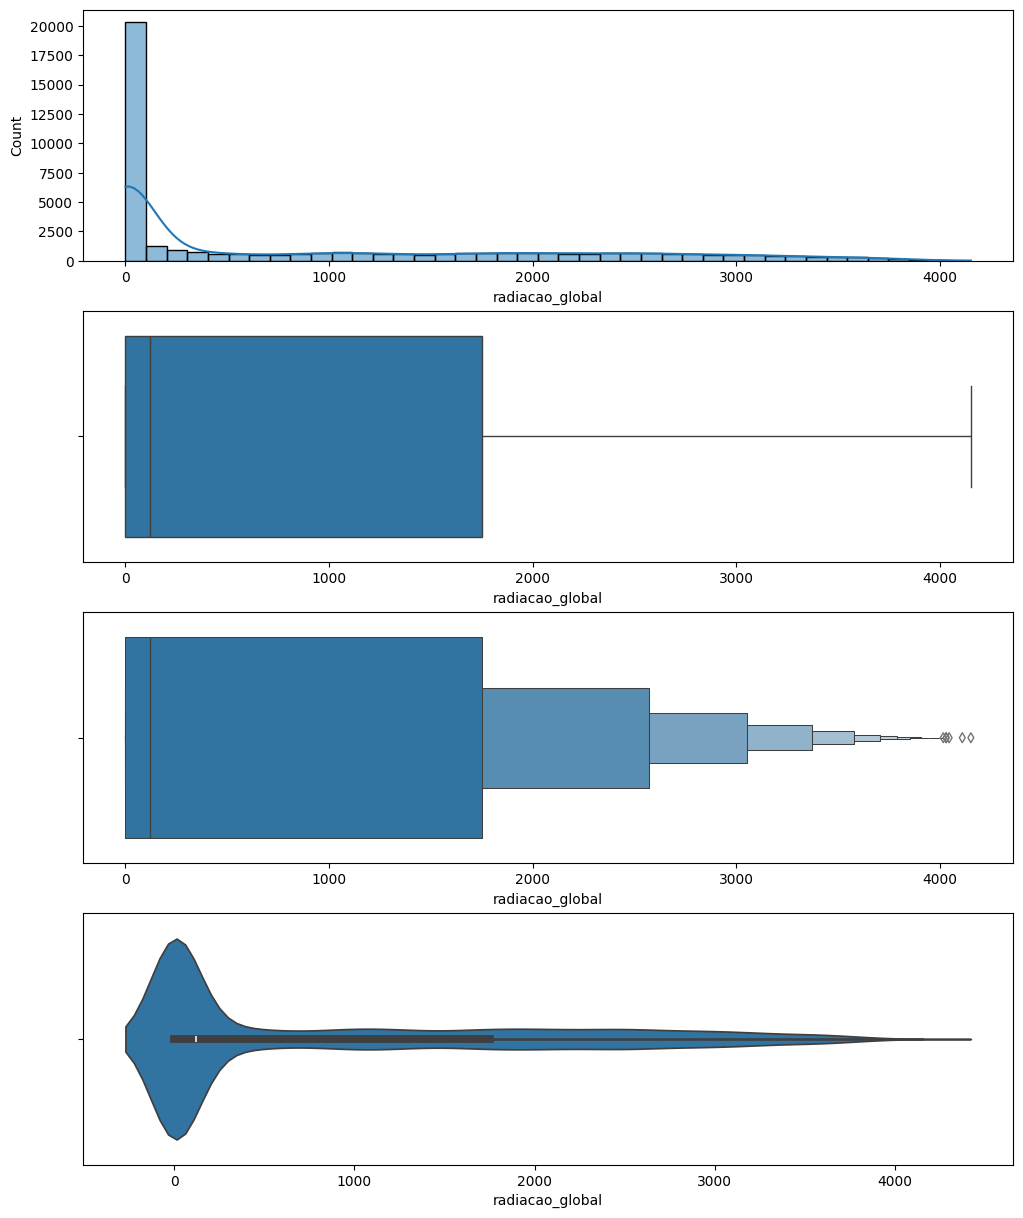

In [697]:
plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1)
sns.histplot(df_wo_windspeed_outliers, x="radiacao_global", kde=True)
plt.subplot(4, 1, 2)
sns.boxplot(
    df_wo_windspeed_outliers["radiacao_global"],
    orient="h",
    flierprops={"marker": "d", "markersize": 5, "color": "lightgray"},
)
plt.subplot(4, 1, 3)
sns.boxenplot(
    df_wo_windspeed_outliers["radiacao_global"],
    orient="h",
    flier_kws={"marker": "d"},
    k_depth="tukey",
)
plt.subplot(4, 1, 4)
sns.violinplot(df_wo_windspeed_outliers["radiacao_global"], orient="h")

##### b) Identificação de outliers via desvio padrão para distribuições normais

In [698]:
# Teste de normalidade
normal = test_normal(
    df_wo_windspeed_outliers["radiacao_global"].dropna(
        inplace=False
    )
)

factor = config["outlier_detection"]["radiation"]["dp_factor"]
if normal:
    print("É normal, vamos usar o desvio padrão")
    outliers_dp = detect_outliers_dp(
        df_wo_windspeed_outliers["radiacao_global"],
        factor=factor,
    )

    print("Número de outliers:", len(outliers_dp))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_dp) / len(df_wo_windspeed_outliers) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_wo_windspeed_outliers,
        x="dia_ano",
        y="radiacao_global",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_wo_windspeed_outliers.iloc[outliers_dp],
        x="dia_ano",
        y="radiacao_global",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_dp = []
    print("Não é normal")

p-value: 0.0009999999999998899
t test: 0.2490193458636636
Reject null hypothesis. Data is not normal
Não é normal


##### c) Identificação de outliers via IQR

Número de outliers: 0
Porcentagem de outliers: 0.0 %


<Axes: xlabel='dia_ano', ylabel='radiacao_global'>

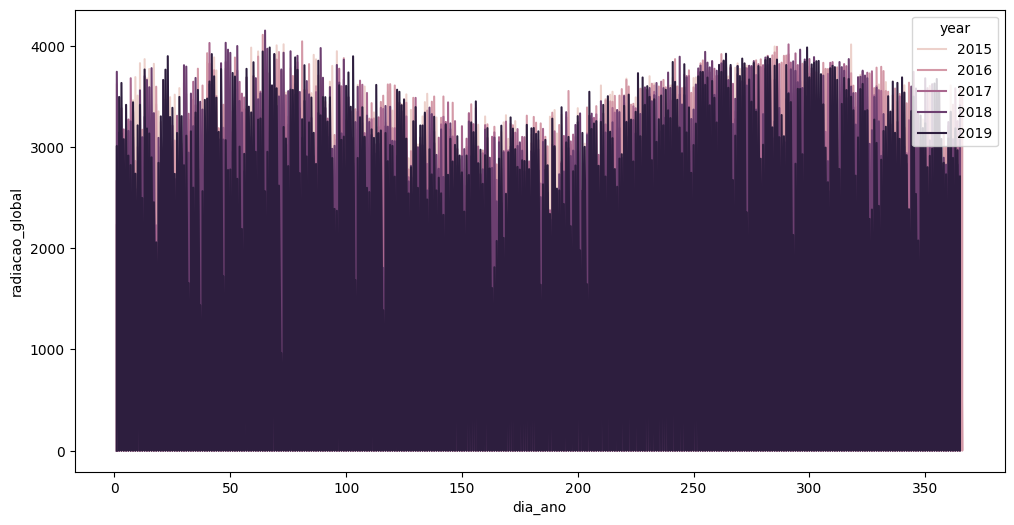

In [699]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_wo_windspeed_outliers,
    x="dia_ano",
    y="radiacao_global",
    hue="year",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

iqr_factor = config["outlier_detection"]["radiation"]["iqr_factor"]
outliers_iqr = detect_outliers_iqr(
    df_wo_windspeed_outliers["radiacao_global"],
    factor=iqr_factor,
)

print("Número de outliers:", len(outliers_iqr))
print(
    "Porcentagem de outliers:",
    round(len(outliers_iqr) / len(df_wo_windspeed_outliers) * 100, 2),
    "%",
)

# outl são índices dos outliers, quero um scatterplot
sns.scatterplot(
    data=df_wo_windspeed_outliers.iloc[outliers_iqr],
    x="dia_ano",
    y="radiacao_global",
    style="year",
    color="red",
    markers=True,
)

##### d) Identificação de outliers via distribuição normal

In [700]:
epsilon = config["outlier_detection"]["radiation"]["epsilon"]
if normal:
    print("É normal, vamos usar a dist Gaussiana")
    outliers_normal = detect_outlier_Normal(
        df_wo_windspeed_outliers["radiacao_global"],
        epsilon=epsilon,
        plotdist=False,
    )

    print("Número de outliers:", len(outliers_normal))
    print(
        "Porcentagem de outliers:",
        round(len(outliers_normal) / len(df_wo_windspeed_outliers) * 100, 2),
        "%",
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_wo_windspeed_outliers,
        x="dia_ano",
        y="radiacao_global",
        hue="year",
        errorbar=None,
        estimator=None,
        # markers=True,
        # style="year",
    )

    # outl são índices dos outliers, quero um scatterplot
    sns.scatterplot(
        data=df_wo_windspeed_outliers.iloc[outliers_normal],
        x="dia_ano",
        y="radiacao_global",
        style="year",
        color="red",
        markers=True,
    )
else:
    outliers_normal = []
    print("Não é normal")

Não é normal


##### e) União dos 3 métodos de detecção e remoção dos outliers

Não é normal


<Axes: xlabel='None', ylabel='radiacao_global'>

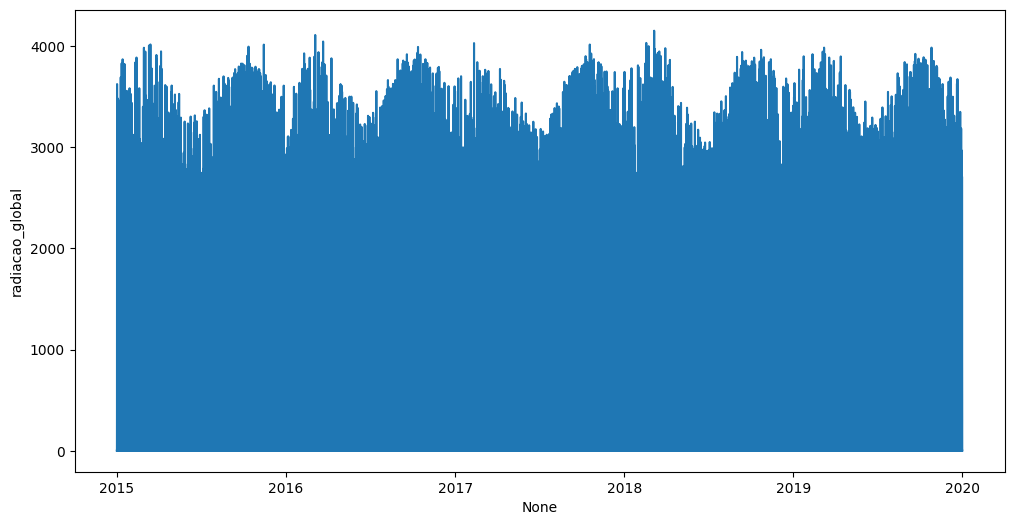

In [701]:
# Visualização de todos os 3 métodos de detecção de outliers sem separar por ano com eixo x correspondente ao índice
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_wo_windspeed_outliers,
    x=df_wo_windspeed_outliers.index,
    y="radiacao_global",
    errorbar=None,
    estimator=None,
    # markers=True,
    # style="year",
)

if normal:
    sns.scatterplot(
        data=df_wo_windspeed_outliers.iloc[outliers_dp],
        x=df_wo_windspeed_outliers.index[outliers_dp],
        y="radiacao_global",
        color="red",
        markers=True,
        marker="o",
        label="Desvio Padrão",
    )
    sns.scatterplot(
        data=df_wo_windspeed_outliers.iloc[outliers_normal],
        x=df_wo_windspeed_outliers.index[outliers_normal],
        y="radiacao_global",
        color="indigo",
        markers=True,
        marker="x",
        label="Distribuição Gaussiana",
    )
else:
    print("Não é normal")

sns.scatterplot(
        data=df_wo_windspeed_outliers.iloc[outliers_iqr],
        x=df_wo_windspeed_outliers.index[outliers_iqr],
        y="radiacao_global",
        color="darkorange",
        markers=True,
        marker="d",
        label="IQR",
    )

In [702]:
# cálculo da % de outliers total
outliers_total = np.unique(
    np.concatenate((outliers_dp, outliers_iqr, outliers_normal))
)
# to int every element in outliers_total
outliers_total = outliers_total.astype(int)
print("Número de outliers total:", len(outliers_total))
print(
    "Porcentagem de outliers total:",
    round(len(outliers_total) / len(df_wo_windspeed_outliers) * 100, 2),
    "%",
)

Número de outliers total: 0
Porcentagem de outliers total: 0.0 %


In [703]:
# Setando os outliers para NaN
df_wo_outliers = df_wo_windspeed_outliers.copy()

df_wo_outliers.loc[
    df_wo_windspeed_outliers.index[outliers_total],
    "radiacao_global",
] = np.nan

**Versão final sem outliers**

In [704]:
df_wo_outliers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 43824 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43078 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43360 non-null  float64
 3   umidade_relativa_ar_horaria                39412 non-null  float64
 4   vento_direcao_horaria                      42879 non-null  float64
 5   vento_rajada_maxima                        43282 non-null  float64
 6   vento_velocidade_horaria                   43347 non-null  float64
 7   radiacao_global                            41296 non-null  float64
 8   year                                       43824 non-null  int32  
 9   hora                                       43824 no

### 3.5. Tratamento de Valores Faltantes (ii)

#### 3.5.1. Pressão Atmosférica

a) Plot de variável

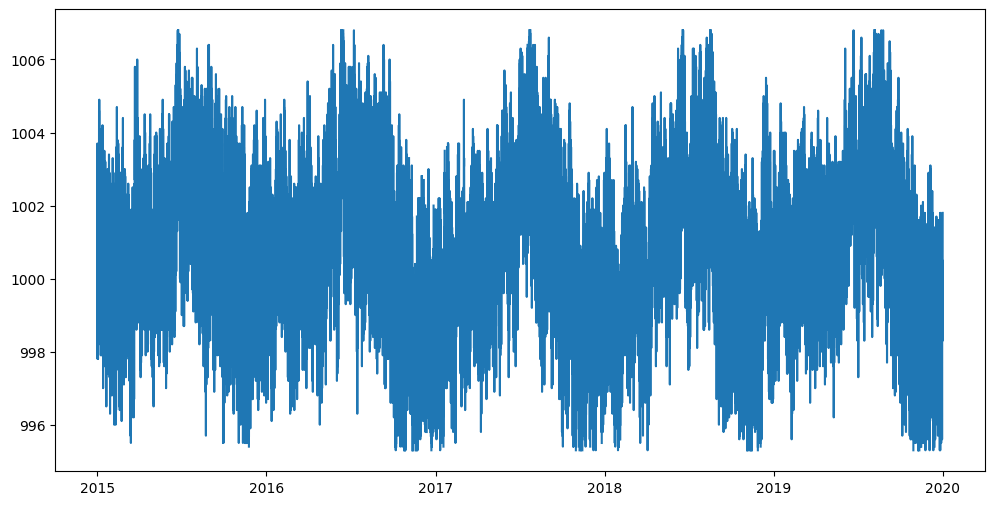

In [705]:
# plot de variável
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_outliers.index,
    df_wo_outliers["pressao_atmosferica_nivel_estacao_horaria"],
    label="Pressão Atmosférica",
)


b) Identificação de principais buracos de dados (>= 6 horas)

In [706]:
# Supondo que df_wo_outliers é o seu DataFrame e a coluna de interesse é "pressao_atmosferica_nivel_estacao_horaria"
coluna = 'pressao_atmosferica_nivel_estacao_horaria'

# Criar uma máscara booleana indicando onde estão os NaNs
nan_mask = df_wo_outliers[coluna].isna()

# Identificar grupos consecutivos de NaNs
nan_groups = (nan_mask != nan_mask.shift()).cumsum()

# Contar o tamanho de cada grupo
group_sizes = nan_mask.groupby(nan_groups).sum()

# Filtrar apenas os grupos de NaNs consecutivos com tamanho >= 6
nan_consecutivos = group_sizes[group_sizes >= 6]

# Ordenar os grupos em ordem decrescente de tamanho
nan_consecutivos = nan_consecutivos.sort_values(ascending=False)

# Obter os índices exatos dos valores NaN nos grupos consecutivos (>= 6) em ordem decrescente de tamanho
nan_indices = [df_wo_outliers.index[nan_mask & (nan_groups == group)].tolist()
               for group in nan_consecutivos.index]

# Exibir os resultados em ordem decrescente de tamanho
for i, (group_size, indices) in enumerate(zip(nan_consecutivos, nan_indices), start=1):
    print(f"Grupo {i}:")
    print(f"Índices dos NaNs consecutivos com tamanho >= 6:\n{indices}")
    print(f"Tamanho: {group_size}\n")

Grupo 1:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2017-02-10 23:00:00'), Timestamp('2017-02-11 00:00:00'), Timestamp('2017-02-11 01:00:00'), Timestamp('2017-02-11 02:00:00'), Timestamp('2017-02-11 03:00:00'), Timestamp('2017-02-11 04:00:00'), Timestamp('2017-02-11 05:00:00'), Timestamp('2017-02-11 06:00:00'), Timestamp('2017-02-11 07:00:00'), Timestamp('2017-02-11 08:00:00'), Timestamp('2017-02-11 09:00:00'), Timestamp('2017-02-11 10:00:00'), Timestamp('2017-02-11 11:00:00'), Timestamp('2017-02-11 12:00:00'), Timestamp('2017-02-11 13:00:00'), Timestamp('2017-02-11 14:00:00')]
Tamanho: 16

Grupo 2:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2017-01-15 18:00:00'), Timestamp('2017-01-15 19:00:00'), Timestamp('2017-01-15 20:00:00'), Timestamp('2017-01-15 21:00:00'), Timestamp('2017-01-15 22:00:00'), Timestamp('2017-01-15 23:00:00'), Timestamp('2017-01-16 00:00:00'), Timestamp('2017-01-16 01:00:00'), Timestamp('2017-01-16 02:00:00'), Timestamp('2017-01-16

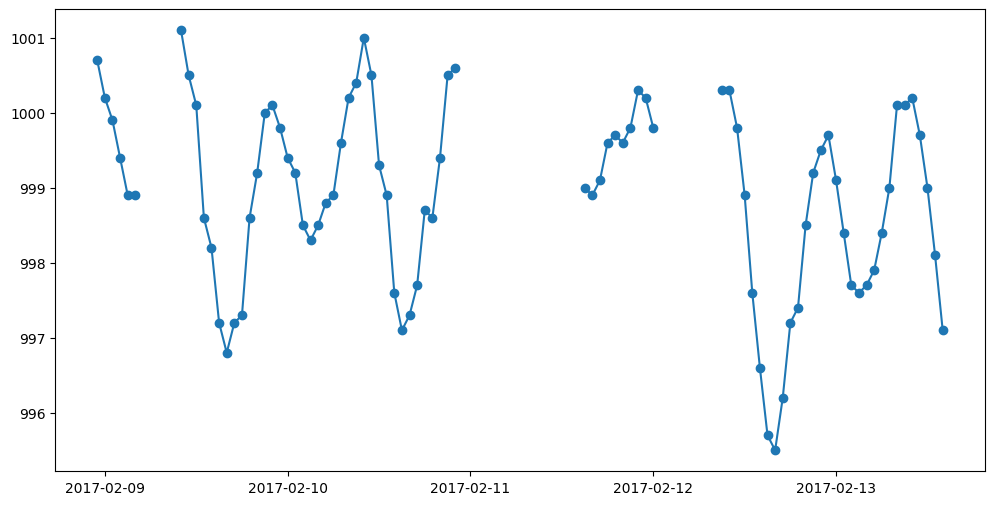

In [707]:
# print de dados para maior gap em grafico
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_outliers.loc["2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna],
    marker="o",
)

In [708]:
# tamanho do maior gap
maior_gap = nan_consecutivos.max()

proporcao_pressao = maior_gap/len(df_wo_outliers)*100

print(f"Proporção de NaNs para o maior gap da coluna {coluna}: \n{proporcao_pressao:.2f}%")

Proporção de NaNs para o maior gap da coluna pressao_atmosferica_nivel_estacao_horaria: 
0.04%


c) Input de dados para maiores buracos (>= 1 dia ou 24h)

In [709]:
def imputar_grandes_buracos(df, coluna, group_sizes):
    """
    Identifica grupos consecutivos de NaNs maiores que 24 e imputa com a média
    do mesmo período (dia/hora) para os demais anos do estudo.

    Parâmetros:
    - df: DataFrame com índice datetime.
    - coluna: Nome da coluna com dados a serem tratados.
    - group_sizes: Série com o tamanho dos grupos de NaNs consecutivos.

    Retorna:
    - DataFrame com valores imputados.
    """
    import numpy as np

    # Filtrar apenas os grupos com tamanho > 24
    grupos_maiores_24 = group_sizes[group_sizes > 24].index

    # Verificar se existem grupos maiores que 24
    if len(grupos_maiores_24) == 0:
        print("Nenhum grupo de NaNs consecutivos maior que 24 foi encontrado.")
        return df

    # Identificar máscara booleana e grupos consecutivos
    nan_mask = df[coluna].isna()
    nan_groups = (nan_mask != nan_mask.shift()).cumsum()

    # Criar uma cópia para evitar alterações desnecessárias no DataFrame original
    df_copy = df.copy()

    # Criar uma coluna auxiliar com "mês-dia hora:minuto"
    df_copy["periodo"] = df_copy.index.strftime("%m-%d %H:%M")

    # Iterar apenas sobre os grupos identificados
    for group in grupos_maiores_24:
        # Filtrar os índices onde estão os NaNs desse grupo
        indices = nan_mask & (nan_groups == group)
        datas_faltantes = df_copy.loc[indices].index
        periodo_faltante = df_copy.loc[indices, "periodo"].unique()

        # Filtrar o mesmo período em outros anos (vetorizado)
        for periodo in periodo_faltante:
            valores_mesmo_periodo = df_copy.loc[
                (df_copy["periodo"] == periodo) & (~df_copy[coluna].isna()),
                coluna,
            ]

            # Calcular a média do período e imputar para todas as datas faltantes
            media_mesmo_periodo = valores_mesmo_periodo.mean()
            if not np.isnan(media_mesmo_periodo):
                df_copy.loc[
                    indices & (df_copy["periodo"] == periodo), coluna
                ] = media_mesmo_periodo

    # Remover a coluna auxiliar
    df_copy.drop(columns=["periodo"], inplace=True)

    return df_copy

In [710]:
df_interpol_pressure = imputar_grandes_buracos(
    df_wo_outliers, coluna, nan_consecutivos
)

Nenhum grupo de NaNs consecutivos maior que 24 foi encontrado.


d) input dos demais gaps via interpolação e/ou média

**Obs.:** Visto que o maior período de dados faltantes para a variável não é tão significativo, bem como devido à sazonalidade, realizaremos apenas interpolação para preenchimento

In [711]:
# Imputação univariada com interpolação linear
# df_interpol_pressure = df_wo_outliers.copy()

df_interpol_pressure[coluna] = df_interpol_pressure[coluna].interpolate(
    method="linear"
)

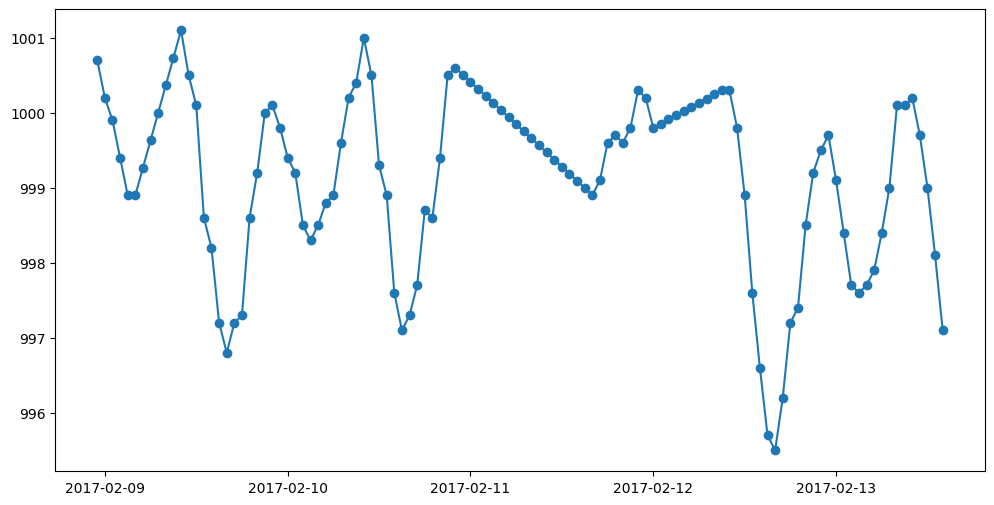

In [712]:
# print de dados entre maior range de NaNs após tratamento
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_pressure.loc[
        "2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna
    ],
    marker="o",
)

Vemos que a interpolação funcionou ok para o período

In [713]:
df_interpol_pressure.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 43824 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43824 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43360 non-null  float64
 3   umidade_relativa_ar_horaria                39412 non-null  float64
 4   vento_direcao_horaria                      42879 non-null  float64
 5   vento_rajada_maxima                        43282 non-null  float64
 6   vento_velocidade_horaria                   43347 non-null  float64
 7   radiacao_global                            41296 non-null  float64
 8   year                                       43824 non-null  int32  
 9   hora                                       43824 no

#### 3.5.2. Temperatura do Ar

a) Plot de variável

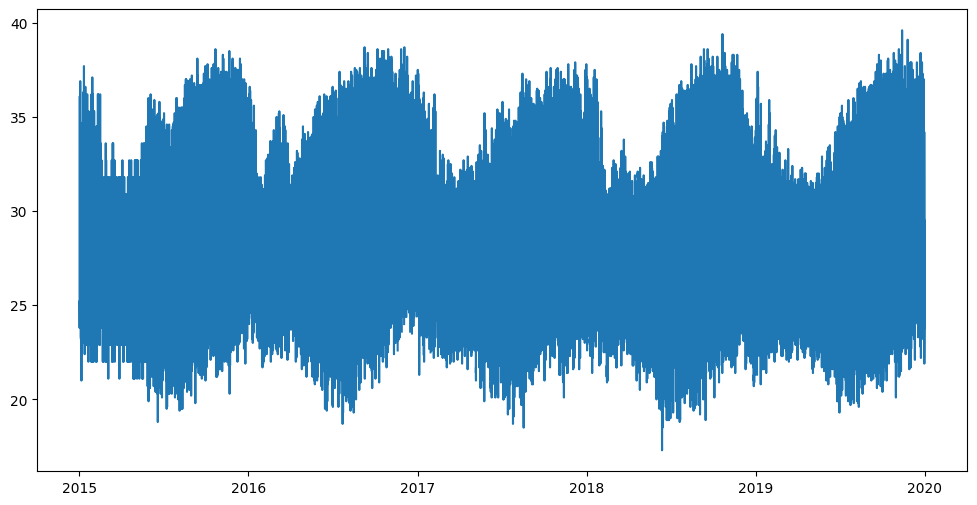

In [714]:
# plot de variável
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_pressure.index,
    df_interpol_pressure["temperatura_ar_bulbo_seco_horaria"],
    label="Temperatura do Ar",
)

b) Identificação de principais buracos de dados (>= 6 horas)

In [715]:
coluna = 'temperatura_ar_bulbo_seco_horaria'

# Criar uma máscara booleana indicando onde estão os NaNs
nan_mask = df_interpol_pressure[coluna].isna()

# Identificar grupos consecutivos de NaNs
nan_groups = (nan_mask != nan_mask.shift()).cumsum()

# Contar o tamanho de cada grupo
group_sizes = nan_mask.groupby(nan_groups).sum()

# Filtrar apenas os grupos de NaNs consecutivos com tamanho >= 6
nan_consecutivos = group_sizes[group_sizes >= 6]

# Ordenar os grupos em ordem decrescente de tamanho
nan_consecutivos = nan_consecutivos.sort_values(ascending=False)

# Obter os índices exatos dos valores NaN nos grupos consecutivos (>= 6) em ordem decrescente de tamanho
nan_indices = [df_interpol_pressure.index[nan_mask & (nan_groups == group)].tolist()
               for group in nan_consecutivos.index]

# Exibir os resultados em ordem decrescente de tamanho
for i, (group_size, indices) in enumerate(zip(nan_consecutivos, nan_indices), start=1):
    print(f"Grupo {i}:")
    print(f"Índices dos NaNs consecutivos com tamanho >= 6:\n{indices}")
    print(f"Tamanho: {group_size}\n")

Grupo 1:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2017-02-10 23:00:00'), Timestamp('2017-02-11 00:00:00'), Timestamp('2017-02-11 01:00:00'), Timestamp('2017-02-11 02:00:00'), Timestamp('2017-02-11 03:00:00'), Timestamp('2017-02-11 04:00:00'), Timestamp('2017-02-11 05:00:00'), Timestamp('2017-02-11 06:00:00'), Timestamp('2017-02-11 07:00:00'), Timestamp('2017-02-11 08:00:00'), Timestamp('2017-02-11 09:00:00'), Timestamp('2017-02-11 10:00:00'), Timestamp('2017-02-11 11:00:00'), Timestamp('2017-02-11 12:00:00'), Timestamp('2017-02-11 13:00:00'), Timestamp('2017-02-11 14:00:00')]
Tamanho: 16

Grupo 2:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2016-12-11 18:00:00'), Timestamp('2016-12-11 19:00:00'), Timestamp('2016-12-11 20:00:00'), Timestamp('2016-12-11 21:00:00'), Timestamp('2016-12-11 22:00:00'), Timestamp('2016-12-11 23:00:00'), Timestamp('2016-12-12 00:00:00'), Timestamp('2016-12-12 01:00:00'), Timestamp('2016-12-12 02:00:00'), Timestamp('2016-12-12

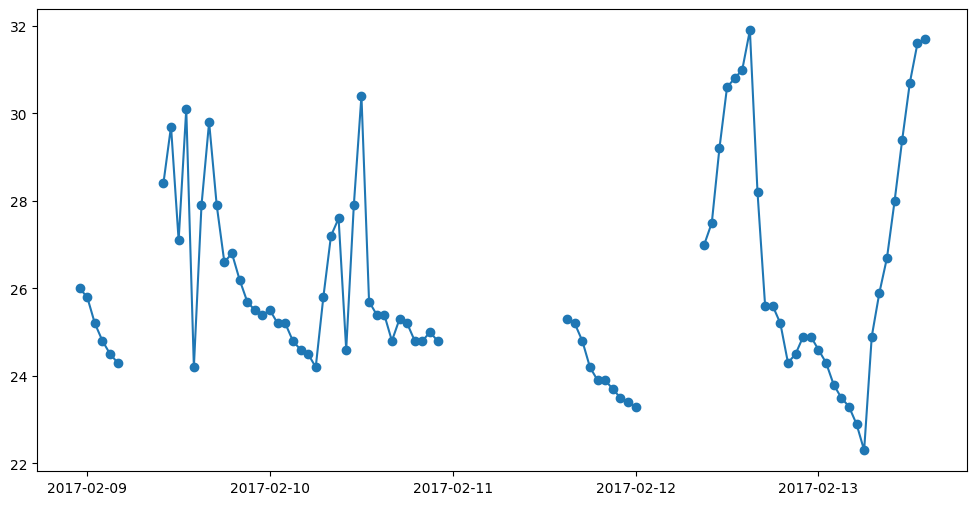

In [716]:
# print de dados para maior gap em grafico
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_pressure.loc["2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna],
    marker="o",
)

In [717]:
# tamanho do maior gap
maior_gap = nan_consecutivos.max()

proporcao_pressao = maior_gap/len(df_interpol_pressure)*100

print(f"Proporção de NaNs do maior gap da coluna {coluna} \nem relação ao total: \n{proporcao_pressao:.2f}%")

Proporção de NaNs do maior gap da coluna temperatura_ar_bulbo_seco_horaria 
em relação ao total: 
0.04%


c) Input de dados para maiores buracos (>= 1 dia ou 24h)

In [718]:
df_interpol_temperature = imputar_grandes_buracos(
    df_interpol_pressure, coluna, nan_consecutivos
)

Nenhum grupo de NaNs consecutivos maior que 24 foi encontrado.


d) input dos demais gaps via interpolação e/ou média

Analisando sazonalidade

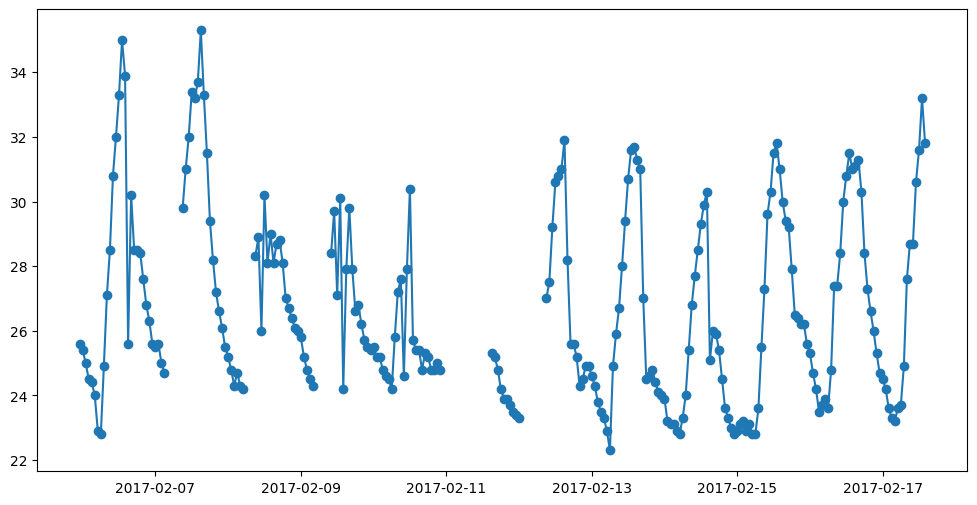

In [719]:
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_pressure.loc["2017-02-05 23:00:00":"2017-02-17 14:00:00", coluna],
    marker="o",
)

**Obs.:** Visto que o maior período de dados faltantes para a variável não é tão significativo (<5%), mas como temos sazonalidade diária aparente, realizaremos interpolação para preenchimento dos menores buracos de dados e input da média para os demais casos

In [720]:
# Filtrar grupos com menos de 6 e maiores ou iguais a 6 NaNs consecutivos (1/4 de período)
grupos_menores_6 = group_sizes[group_sizes < 6].index
grupos_maiores_ou_iguais_6 = group_sizes[
    (group_sizes >= 6) & (group_sizes < 24)
].index

In [721]:
# Imputação univariada com interpolação linear
# df_interpol_temperature = df_interpol_pressure.copy()

# df_interpol_temperature[coluna] = df_interpol_temperature[coluna].interpolate(
#     method="linear"
# )

In [722]:
# Aplicar interpolação nos grupos menores que 6
for group in grupos_menores_6:
    indices = nan_mask & (nan_groups == group)
    df_interpol_temperature.loc[indices, coluna] = df_interpol_temperature[
        coluna
    ].interpolate(method="linear")

# Preencher os grupos maiores ou iguais a 6 com a média da coluna
media_coluna = df_interpol_temperature[coluna].mean()
for group in grupos_maiores_ou_iguais_6:
    indices = nan_mask & (nan_groups == group)
    df_interpol_temperature.loc[indices, coluna] = media_coluna

# Verificar o resultado final
print(
    df_interpol_temperature[coluna].isna().sum()
)  # Deve ser 0 se todos os buracos forem tratados

0


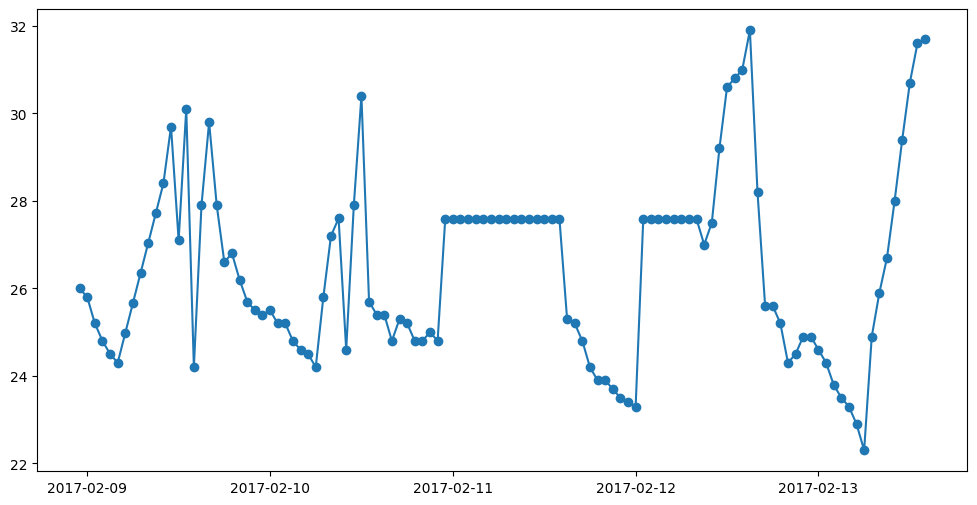

In [723]:
# print de dados entre maior gap em grafico
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_temperature.loc["2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna],
    marker="o",
)

Vemos a interpolação de dados próximo ao dia 2017-02-09 e input de média próximo a 2017-02-11

In [724]:
df_interpol_temperature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 43824 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43824 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43824 non-null  float64
 3   umidade_relativa_ar_horaria                39412 non-null  float64
 4   vento_direcao_horaria                      42879 non-null  float64
 5   vento_rajada_maxima                        43282 non-null  float64
 6   vento_velocidade_horaria                   43347 non-null  float64
 7   radiacao_global                            41296 non-null  float64
 8   year                                       43824 non-null  int32  
 9   hora                                       43824 no

#### 3.5.3. Umidade Relativa do Ar

a) Plot de variável

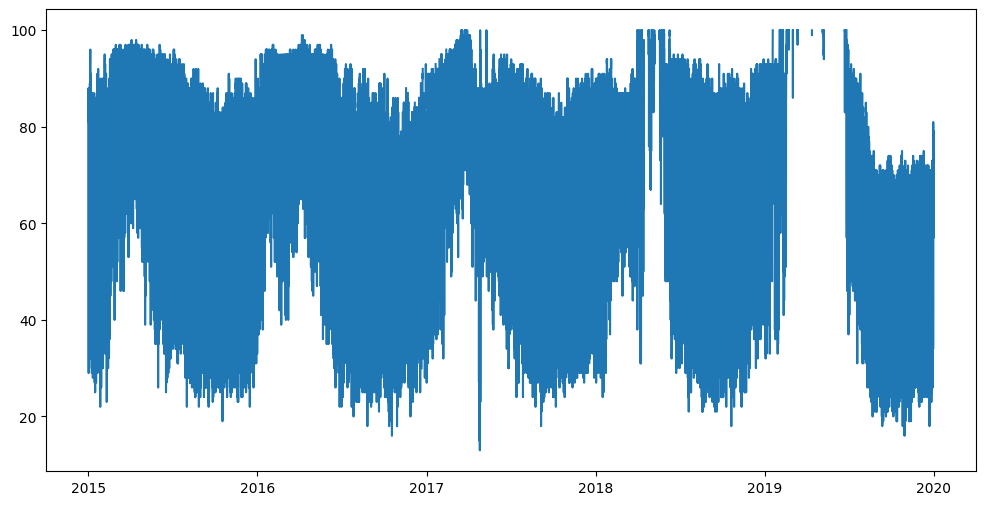

In [725]:
# plot de variável
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_temperature.index,
    df_interpol_temperature["umidade_relativa_ar_horaria"],
    label="Umidade Relativa",
)

b) Identificação de principais buracos de dados (>= 6 horas)

In [726]:
coluna = 'umidade_relativa_ar_horaria'

# Criar uma máscara booleana indicando onde estão os NaNs
nan_mask = df_interpol_temperature[coluna].isna()

# Identificar grupos consecutivos de NaNs
nan_groups = (nan_mask != nan_mask.shift()).cumsum()

# Contar o tamanho de cada grupo
group_sizes = nan_mask.groupby(nan_groups).sum()

# Filtrar apenas os grupos de NaNs consecutivos com tamanho >= 6
nan_consecutivos = group_sizes[group_sizes >= 6]

# Ordenar os grupos em ordem decrescente de tamanho
nan_consecutivos = nan_consecutivos.sort_values(ascending=False)

# Obter os índices exatos dos valores NaN nos grupos consecutivos (>= 6) em ordem decrescente de tamanho
nan_indices = [df_interpol_temperature.index[nan_mask & (nan_groups == group)].tolist()
               for group in nan_consecutivos.index]

# Exibir os resultados em ordem decrescente de tamanho
for i, (group_size, indices) in enumerate(zip(nan_consecutivos, nan_indices), start=1):
    print(f"Grupo {i}:")
    print(f"Índices dos NaNs consecutivos com tamanho >= 6:\n{indices}")
    print(f"Tamanho: {group_size}\n")

Grupo 1:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2019-05-08 16:00:00'), Timestamp('2019-05-08 17:00:00'), Timestamp('2019-05-08 18:00:00'), Timestamp('2019-05-08 19:00:00'), Timestamp('2019-05-08 20:00:00'), Timestamp('2019-05-08 21:00:00'), Timestamp('2019-05-08 22:00:00'), Timestamp('2019-05-08 23:00:00'), Timestamp('2019-05-09 00:00:00'), Timestamp('2019-05-09 01:00:00'), Timestamp('2019-05-09 02:00:00'), Timestamp('2019-05-09 03:00:00'), Timestamp('2019-05-09 04:00:00'), Timestamp('2019-05-09 05:00:00'), Timestamp('2019-05-09 06:00:00'), Timestamp('2019-05-09 07:00:00'), Timestamp('2019-05-09 08:00:00'), Timestamp('2019-05-09 09:00:00'), Timestamp('2019-05-09 10:00:00'), Timestamp('2019-05-09 11:00:00'), Timestamp('2019-05-09 12:00:00'), Timestamp('2019-05-09 13:00:00'), Timestamp('2019-05-09 14:00:00'), Timestamp('2019-05-09 15:00:00'), Timestamp('2019-05-09 16:00:00'), Timestamp('2019-05-09 17:00:00'), Timestamp('2019-05-09 18:00:00'), Timestamp('2019-05-09 19

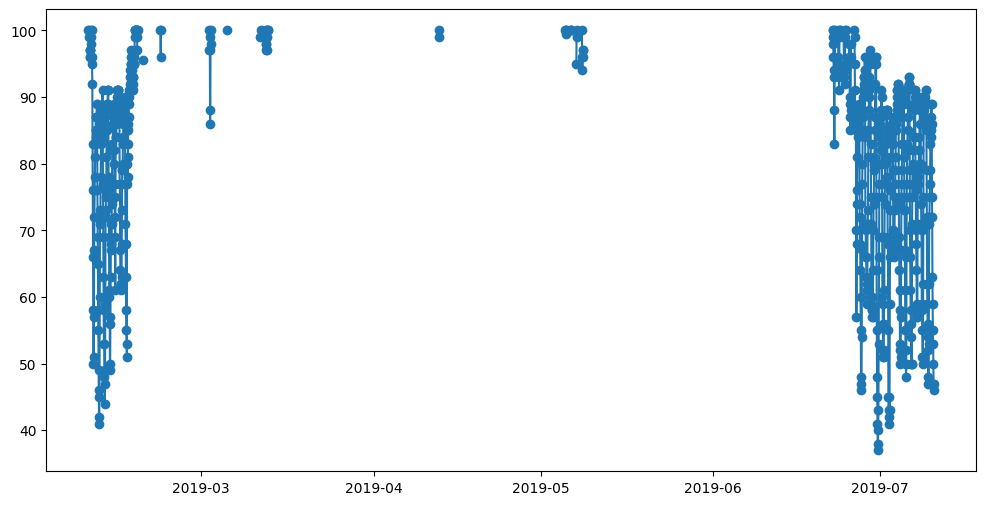

In [727]:
# print de dados para maior gap em grafico
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_temperature.loc['2019-02-06 00:00:00':'2019-07-10 16:00:00', coluna],
    marker="o",
)

In [728]:
# tamanho do maior gap
maior_gap = nan_consecutivos.max()

proporcao_umidade = maior_gap/len(df_interpol_temperature)*100

print(f"Proporção de NaNs do maior gap da coluna {coluna} \nem relação ao total: \n{proporcao_umidade:.2f}%")

Proporção de NaNs do maior gap da coluna umidade_relativa_ar_horaria 
em relação ao total: 
2.45%


c) Input de dados para maiores buracos (>= 1 dia ou 24h)

In [729]:
df_wo_nan_humidity = imputar_grandes_buracos(
    df_interpol_temperature, coluna, nan_consecutivos
)

d) input dos demais gaps via interpolação e/ou média

Analisando sazonalidade

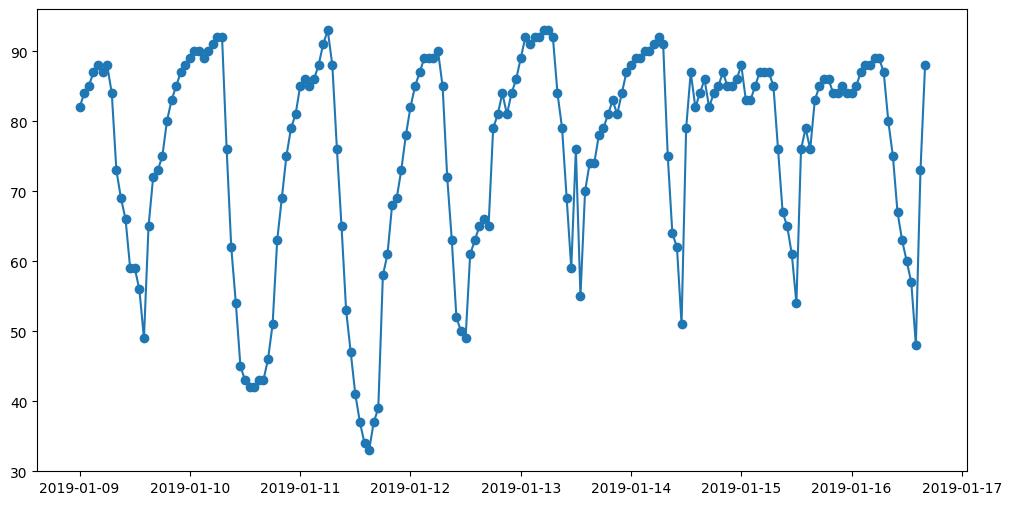

In [730]:
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_temperature.loc['2019-01-09 00:00:00':'2019-01-16 16:00:00', coluna],
    marker="o",
)

**Obs.:** Temos uma quantidade maior de dados faltantes do que as variáveis de Pressão e Temperatura, mas ainda assim menor do que 5% dos dados. ENTRETANTO, temos uma sazonalidade. Dessa forma não faz muito sentido simplesmente interpolar, a não ser para intervalos de dados faltantes menores que a metade do que 1/4 do período

A SAZONALIDADE parece ser de 1 dia. Então realizaremos interpolação para intervalos menores que 6 horas e inputaremos a média para períodos maiores que isso.

In [731]:
# Filtrar grupos com menos de 6 e maiores ou iguais a 6 NaNs consecutivos (1/4 de período)
grupos_menores_6 = group_sizes[group_sizes < 6].index
grupos_maiores_ou_iguais_6 = group_sizes[
    (group_sizes >= 6) & (group_sizes < 24)
].index

In [732]:
# Aplicar interpolação nos grupos menores que 6
for group in grupos_menores_6:
    indices = nan_mask & (nan_groups == group)
    df_wo_nan_humidity.loc[indices, coluna] = df_wo_nan_humidity[coluna].interpolate(method='linear')

# Preencher os grupos maiores ou iguais a 6 com a média da coluna
media_coluna = df_wo_nan_humidity[coluna].mean()
for group in grupos_maiores_ou_iguais_6:
    indices = nan_mask & (nan_groups == group)
    df_wo_nan_humidity.loc[indices, coluna] = media_coluna

# Verificar o resultado final
print(df_wo_nan_humidity[coluna].isna().sum())  # Deve ser 0 se todos os buracos forem tratados

0


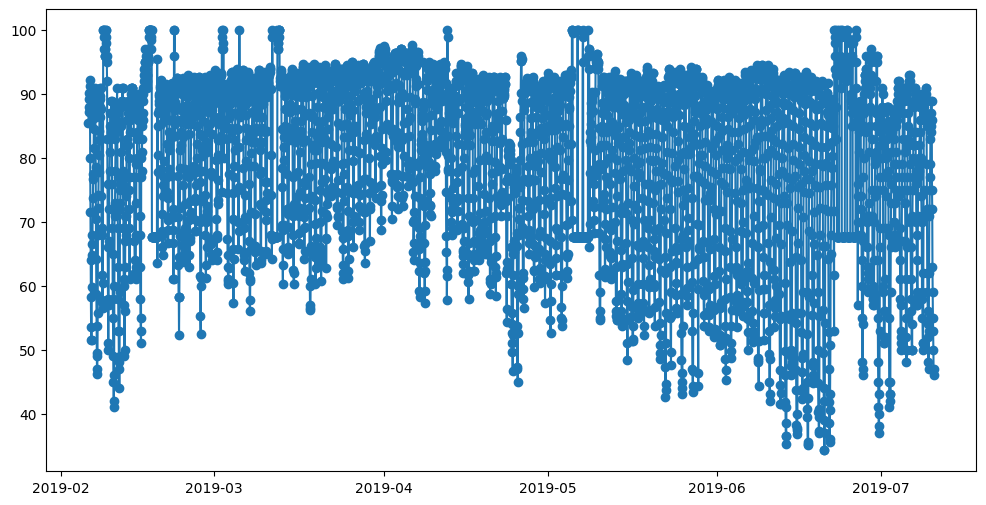

In [733]:
# print de dados entre maior gap em grafico
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_humidity.loc['2019-02-06 00:00:00':'2019-07-10 16:00:00', coluna],
    marker="o",
)

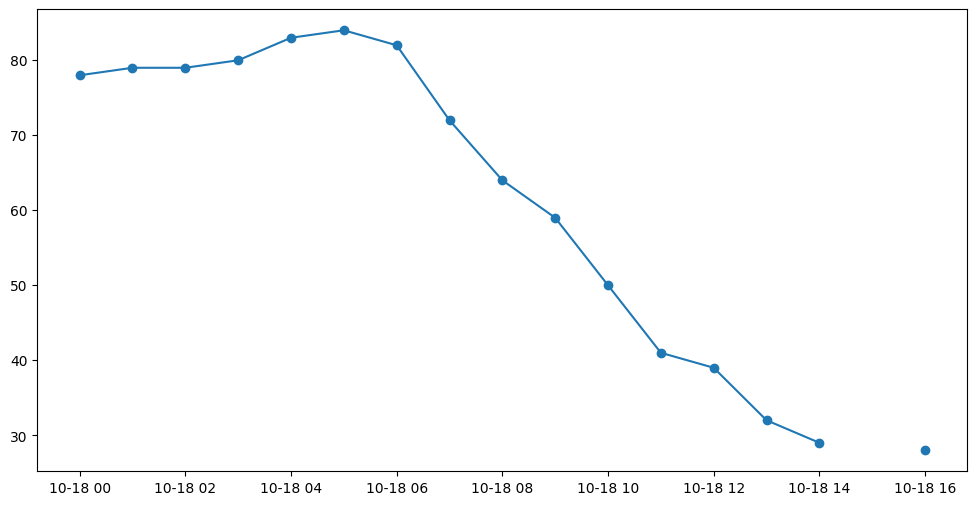

In [734]:
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_temperature.loc['2016-10-18 00:00:00':'2016-10-18 16:00:00', coluna],
    marker="o",
)

In [735]:
media_coluna

67.64541154355798

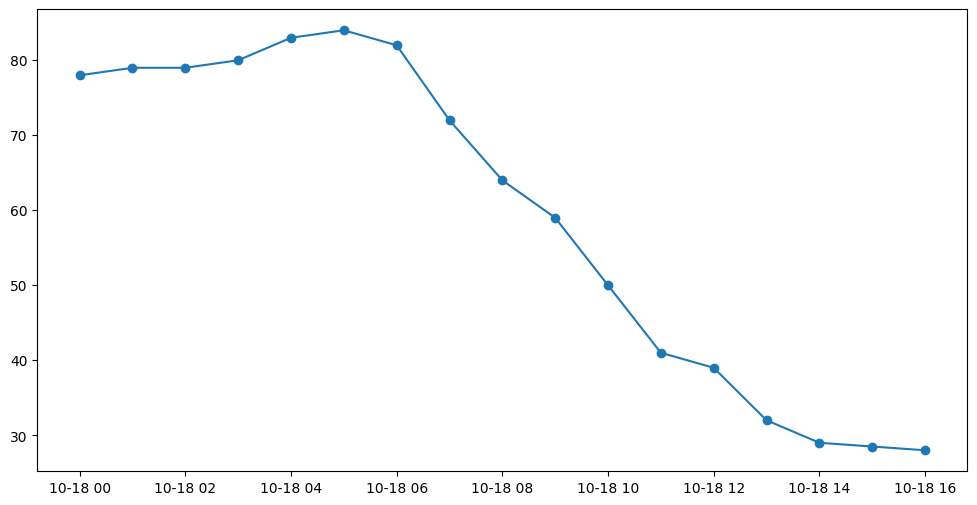

In [736]:
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_humidity.loc['2016-10-18 00:00:00':'2016-10-18 16:00:00', coluna],
    marker="o",
)

Interpolação ok para gaps menores

In [737]:
df_wo_nan_humidity.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 43824 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43824 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43824 non-null  float64
 3   umidade_relativa_ar_horaria                43824 non-null  float64
 4   vento_direcao_horaria                      42879 non-null  float64
 5   vento_rajada_maxima                        43282 non-null  float64
 6   vento_velocidade_horaria                   43347 non-null  float64
 7   radiacao_global                            41296 non-null  float64
 8   year                                       43824 non-null  int32  
 9   hora                                       43824 no

#### 3.5.4. Direção do Vento

a) Plot de variável

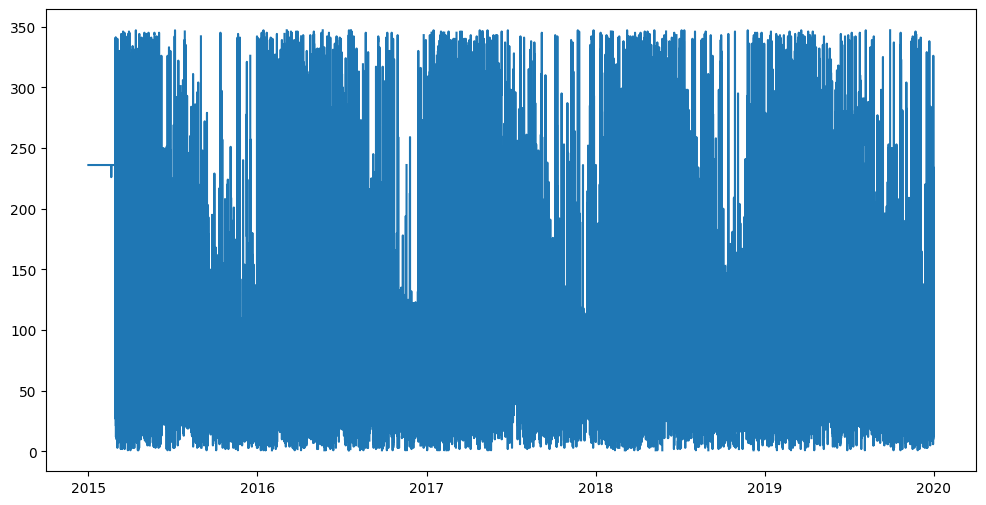

In [738]:
# plot de variável
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_humidity.index,
    df_wo_nan_humidity["vento_direcao_horaria"],
    label="Direção do Vento",
)

b) Identificação de principais buracos de dados (>= 6 horas)

In [739]:
coluna = 'vento_direcao_horaria'

# Criar uma máscara booleana indicando onde estão os NaNs
nan_mask = df_wo_nan_humidity[coluna].isna()

# Identificar grupos consecutivos de NaNs
nan_groups = (nan_mask != nan_mask.shift()).cumsum()

# Contar o tamanho de cada grupo
group_sizes = nan_mask.groupby(nan_groups).sum()

# Filtrar apenas os grupos de NaNs consecutivos com tamanho >= 6
nan_consecutivos = group_sizes[group_sizes >= 6]

# Ordenar os grupos em ordem decrescente de tamanho
nan_consecutivos = nan_consecutivos.sort_values(ascending=False)

# Obter os índices exatos dos valores NaN nos grupos consecutivos (>= 6) em ordem decrescente de tamanho
nan_indices = [df_wo_nan_humidity.index[nan_mask & (nan_groups == group)].tolist()
               for group in nan_consecutivos.index]

# Exibir os resultados em ordem decrescente de tamanho
for i, (group_size, indices) in enumerate(zip(nan_consecutivos, nan_indices), start=1):
    print(f"Grupo {i}:")
    print(f"Índices dos NaNs consecutivos com tamanho >= 6:\n{indices}")
    print(f"Tamanho: {group_size}\n")

Grupo 1:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2017-02-10 23:00:00'), Timestamp('2017-02-11 00:00:00'), Timestamp('2017-02-11 01:00:00'), Timestamp('2017-02-11 02:00:00'), Timestamp('2017-02-11 03:00:00'), Timestamp('2017-02-11 04:00:00'), Timestamp('2017-02-11 05:00:00'), Timestamp('2017-02-11 06:00:00'), Timestamp('2017-02-11 07:00:00'), Timestamp('2017-02-11 08:00:00'), Timestamp('2017-02-11 09:00:00'), Timestamp('2017-02-11 10:00:00'), Timestamp('2017-02-11 11:00:00'), Timestamp('2017-02-11 12:00:00'), Timestamp('2017-02-11 13:00:00'), Timestamp('2017-02-11 14:00:00')]
Tamanho: 16

Grupo 2:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2016-12-11 18:00:00'), Timestamp('2016-12-11 19:00:00'), Timestamp('2016-12-11 20:00:00'), Timestamp('2016-12-11 21:00:00'), Timestamp('2016-12-11 22:00:00'), Timestamp('2016-12-11 23:00:00'), Timestamp('2016-12-12 00:00:00'), Timestamp('2016-12-12 01:00:00'), Timestamp('2016-12-12 02:00:00'), Timestamp('2016-12-12

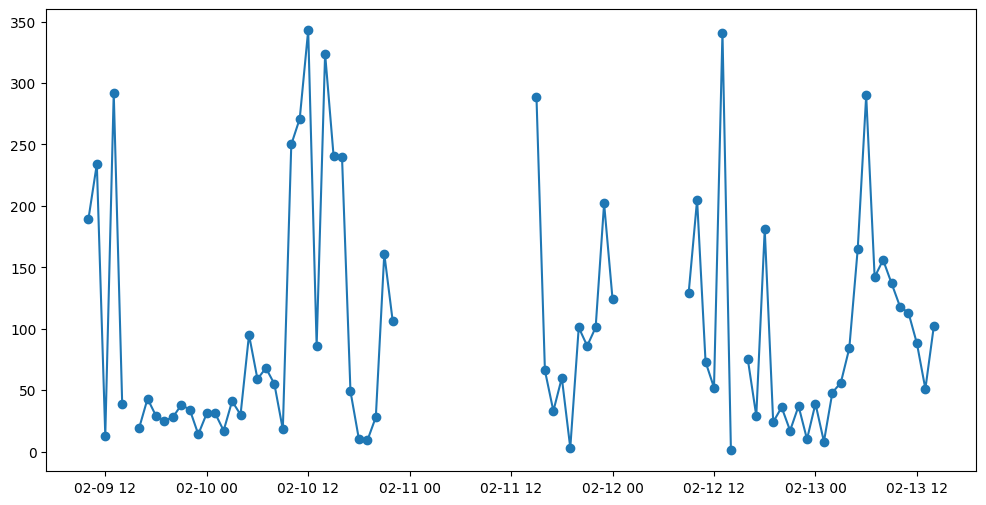

In [740]:
# print de dados para maior gap em grafico
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_humidity.loc["2017-02-09 10:00:00":"2017-02-13 14:00:00", coluna],
    marker="o",
)

In [741]:
# tamanho do maior gap
maior_gap = nan_consecutivos.max()

proporcao_pressao = maior_gap/len(df_wo_nan_humidity)*100

print(f"Proporção de NaNs do maior gap da coluna {coluna} \nem relação ao total: \n{proporcao_pressao:.2f}%")

Proporção de NaNs do maior gap da coluna vento_direcao_horaria 
em relação ao total: 
0.04%


c) Input de dados para maiores buracos (>= 1 dia ou 24h)

In [742]:
df_wo_nan_winddir = imputar_grandes_buracos(
    df_wo_nan_humidity, coluna, nan_consecutivos
)

Nenhum grupo de NaNs consecutivos maior que 24 foi encontrado.


d) input dos demais gaps via interpolação e/ou média

Analisando sazonalidade

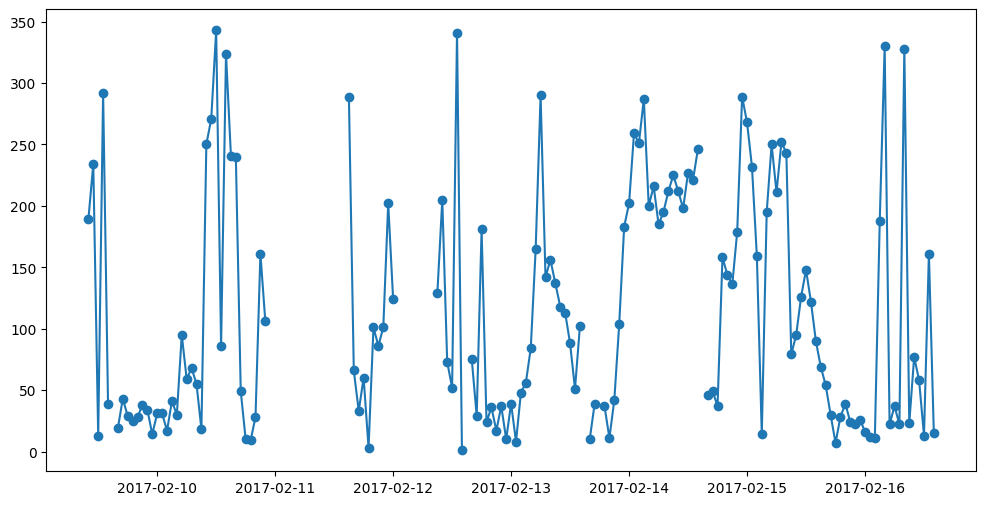

In [743]:
# print de dados para maior gap em grafico
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_winddir.loc["2017-02-09 10:00:00":"2017-02-16 14:00:00", coluna],
    marker="o",
)

**Obs.:** Visto que o maior período de dados faltantes para a variável não é tão significativo (<5%), bem como não termos sazonalidade aparente, realizaremos apenas interpolação para preenchimento

In [744]:
# Imputação univariada com interpolação linear
df_interpol_winddir = df_wo_nan_winddir.copy()

df_interpol_winddir[coluna] = df_interpol_winddir[coluna].interpolate(
    method="linear"
)

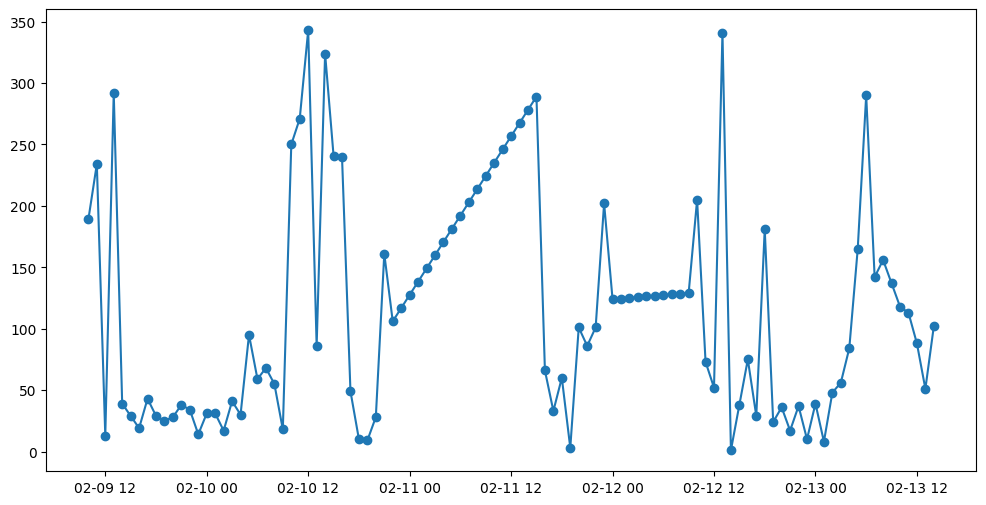

In [745]:
# print de dados entre maior gap
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_winddir.loc["2017-02-09 10:00:00":"2017-02-13 14:00:00", coluna],
    marker="o",
)

In [746]:
df_interpol_winddir.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 43824 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43824 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43824 non-null  float64
 3   umidade_relativa_ar_horaria                43824 non-null  float64
 4   vento_direcao_horaria                      43824 non-null  float64
 5   vento_rajada_maxima                        43282 non-null  float64
 6   vento_velocidade_horaria                   43347 non-null  float64
 7   radiacao_global                            41296 non-null  float64
 8   year                                       43824 non-null  int32  
 9   hora                                       43824 no

#### 3.5.5. Rajada Máxima

a) Plot de variável

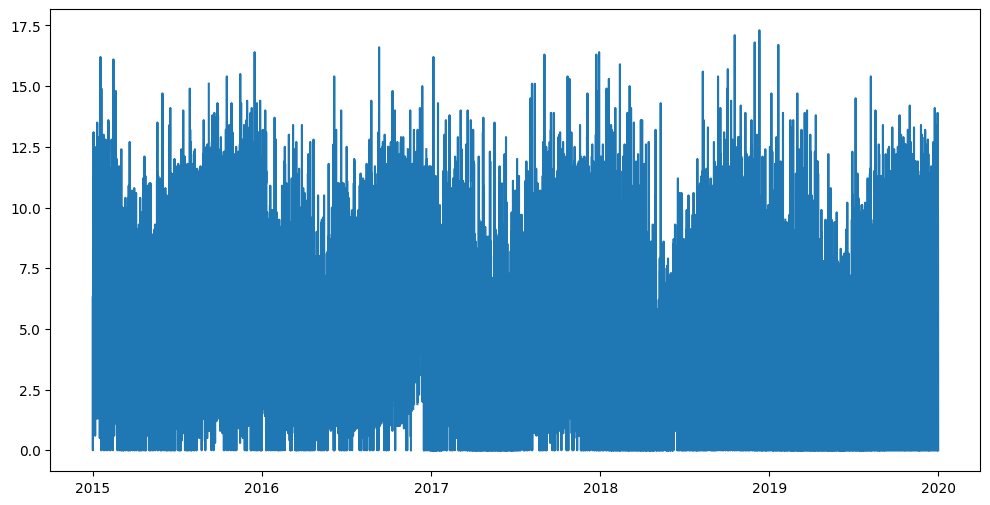

In [747]:
# plot de variável
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_winddir.index,
    df_interpol_winddir["vento_rajada_maxima"],
    label="Rajada Máxima",
)

b) Identificação de principais buracos de dados (>= 6 horas)

In [748]:
coluna = 'vento_rajada_maxima'

# Criar uma máscara booleana indicando onde estão os NaNs
nan_mask = df_interpol_winddir[coluna].isna()

# Identificar grupos consecutivos de NaNs
nan_groups = (nan_mask != nan_mask.shift()).cumsum()

# Contar o tamanho de cada grupo
group_sizes = nan_mask.groupby(nan_groups).sum()

# Filtrar apenas os grupos de NaNs consecutivos com tamanho >= 6
nan_consecutivos = group_sizes[group_sizes >= 6]

# Ordenar os grupos em ordem decrescente de tamanho
nan_consecutivos = nan_consecutivos.sort_values(ascending=False)

# Obter os índices exatos dos valores NaN nos grupos consecutivos (>= 6) em ordem decrescente de tamanho
nan_indices = [df_interpol_winddir.index[nan_mask & (nan_groups == group)].tolist()
               for group in nan_consecutivos.index]

# Exibir os resultados em ordem decrescente de tamanho
for i, (group_size, indices) in enumerate(zip(nan_consecutivos, nan_indices), start=1):
    print(f"Grupo {i}:")
    print(f"Índices dos NaNs consecutivos com tamanho >= 6:\n{indices}")
    print(f"Tamanho: {group_size}\n")

Grupo 1:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2017-02-10 23:00:00'), Timestamp('2017-02-11 00:00:00'), Timestamp('2017-02-11 01:00:00'), Timestamp('2017-02-11 02:00:00'), Timestamp('2017-02-11 03:00:00'), Timestamp('2017-02-11 04:00:00'), Timestamp('2017-02-11 05:00:00'), Timestamp('2017-02-11 06:00:00'), Timestamp('2017-02-11 07:00:00'), Timestamp('2017-02-11 08:00:00'), Timestamp('2017-02-11 09:00:00'), Timestamp('2017-02-11 10:00:00'), Timestamp('2017-02-11 11:00:00'), Timestamp('2017-02-11 12:00:00'), Timestamp('2017-02-11 13:00:00'), Timestamp('2017-02-11 14:00:00'), Timestamp('2017-02-11 15:00:00')]
Tamanho: 17

Grupo 2:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2016-12-11 18:00:00'), Timestamp('2016-12-11 19:00:00'), Timestamp('2016-12-11 20:00:00'), Timestamp('2016-12-11 21:00:00'), Timestamp('2016-12-11 22:00:00'), Timestamp('2016-12-11 23:00:00'), Timestamp('2016-12-12 00:00:00'), Timestamp('2016-12-12 01:00:00'), Timestamp('2016-12-12

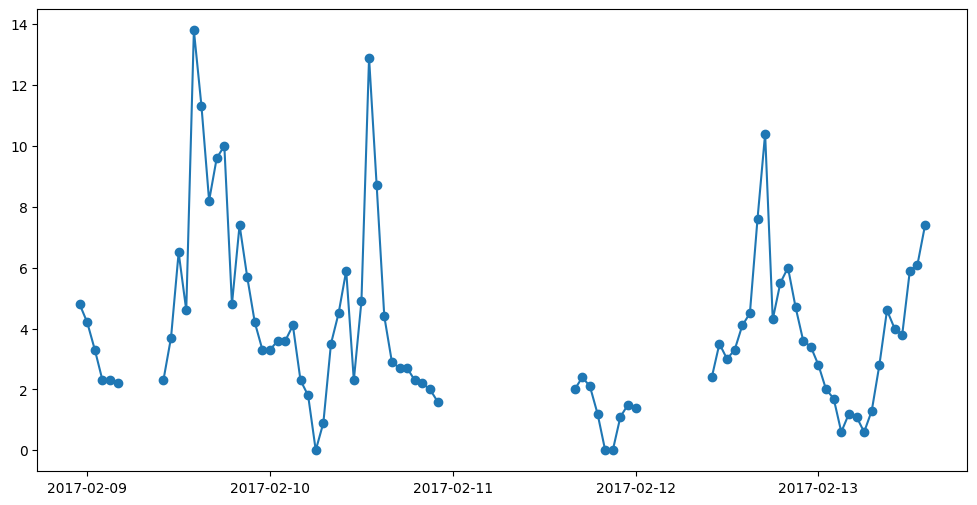

In [749]:
# print de dados para maior gap em grafico
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_winddir.loc["2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna],
    marker="o",
)

In [750]:
# tamanho do maior gap
maior_gap = nan_consecutivos.max()

proporcao = maior_gap/len(df_interpol_winddir)*100

print(f"Proporção de NaNs do maior gap da coluna {coluna} \nem relação ao total: \n{proporcao:.2f}%")

Proporção de NaNs do maior gap da coluna vento_rajada_maxima 
em relação ao total: 
0.04%


c) Input de dados para maiores buracos (>= 1 dia ou 24h)

In [751]:
df_wo_nan_rajada = imputar_grandes_buracos(
    df_interpol_winddir, coluna, nan_consecutivos
)

Nenhum grupo de NaNs consecutivos maior que 24 foi encontrado.


d) input dos demais gaps via interpolação e/ou média

**Analisando sazonalidade**

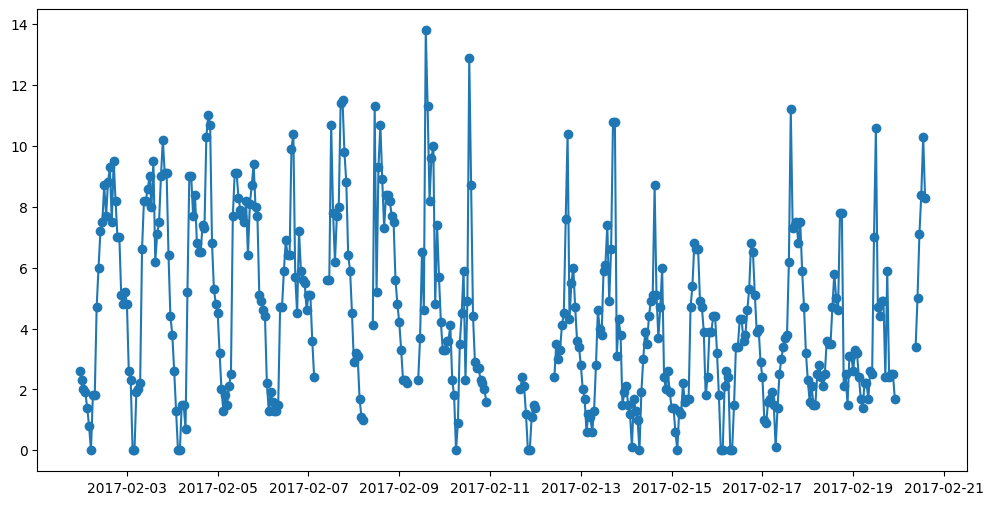

In [752]:
# print de dados entre gap
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_winddir.loc["2017-02-01 23:00:00":"2017-02-20 14:00:00", coluna],
    marker="o",
)

**Obs.:** Temos uma quantidade maior de dados faltantes do que as variáveis de Pressão e Temperatura, mas ainda assim menor do que 5% dos dados. ENTRETANTO, temos uma sazonalidade. Dessa forma não faz muito sentido simplesmente interpolar, a não ser para intervalos de dados faltantes menores que a metade do que 1/4 do período

A SAZONALIDADE parece ter período de 1 dia. Então realizaremos interpolação para intervalos menores que 6 horas e inputaremos a média para períodos maiores que isso.

In [753]:
# Filtrar grupos com menos de 6 e maiores ou iguais a 6 NaNs consecutivos (1/4 de período)
grupos_menores_6 = group_sizes[group_sizes < 6].index
grupos_maiores_ou_iguais_6 = group_sizes[
    (group_sizes >= 6) & (group_sizes < 24)
].index

In [754]:
# Aplicar interpolação nos grupos menores que 6
for group in grupos_menores_6:
    indices = nan_mask & (nan_groups == group)
    df_wo_nan_rajada.loc[indices, coluna] = df_wo_nan_rajada[coluna].interpolate(method='linear')

# Preencher os grupos maiores ou iguais a 6 com a média da coluna
media_coluna = df_wo_nan_rajada[coluna].mean()
for group in grupos_maiores_ou_iguais_6:
    indices = nan_mask & (nan_groups == group)
    df_wo_nan_rajada.loc[indices, coluna] = media_coluna

# Verificar o resultado final
print(df_wo_nan_rajada[coluna].isna().sum())  # Deve ser 0 se todos os buracos forem tratados

0


In [755]:
media_coluna

4.818461893231869

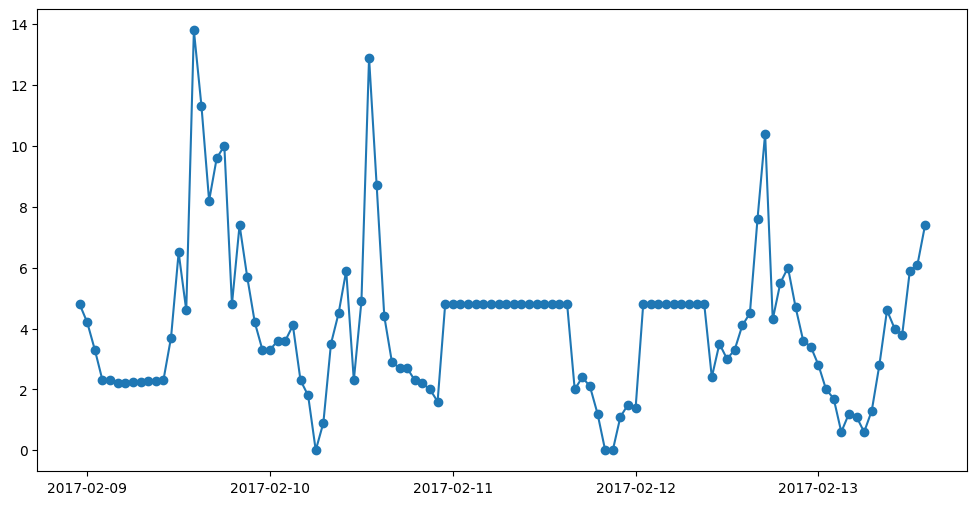

In [756]:
# print de dados gap mais importante
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_rajada.loc["2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna],
    marker="o",
)

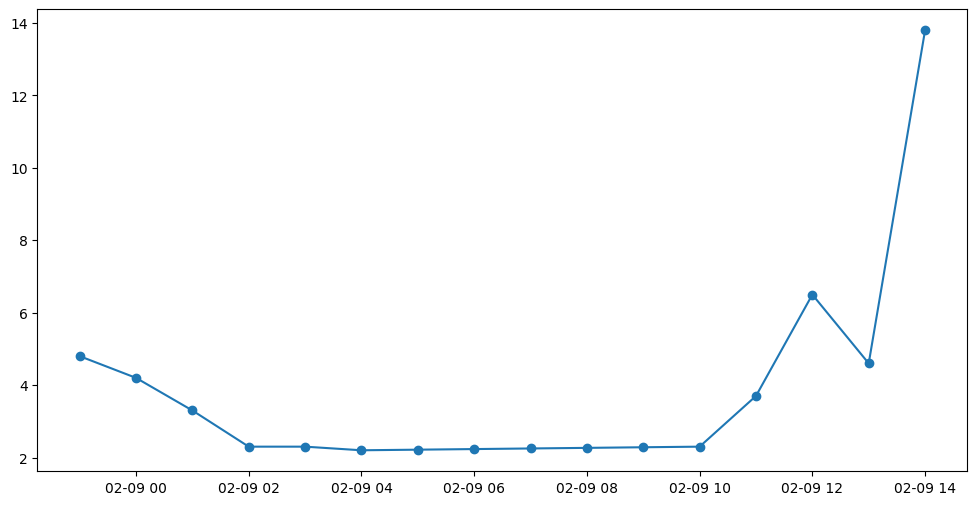

In [757]:
# print de dados
plt.figure(figsize=(12, 6))

plt.plot(
    df_interpol_winddir.loc["2017-02-08 23:00:00":"2017-02-09 14:00:00", coluna],
    marker="o",
)

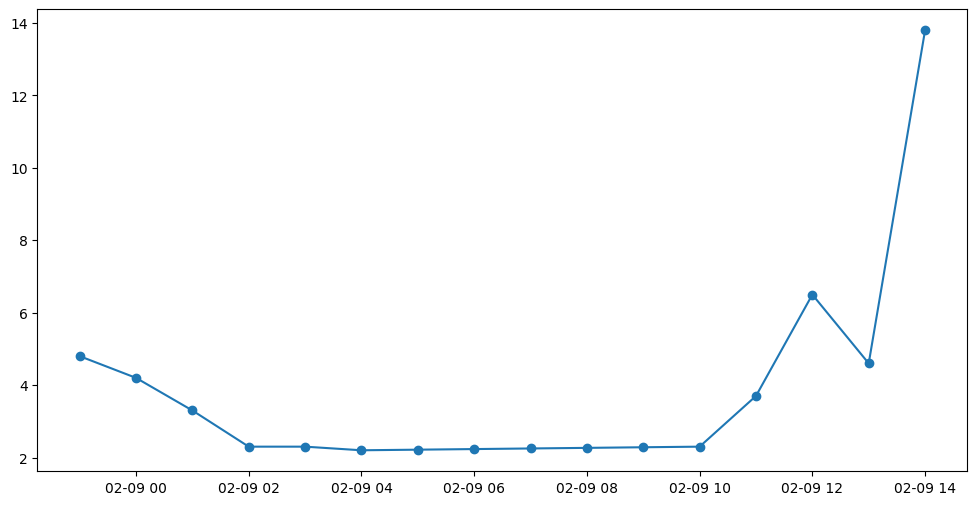

In [758]:
# print de dados entre gap mais importante
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_rajada.loc["2017-02-08 23:00:00":"2017-02-09 14:00:00", coluna],
    marker="o",
)

In [759]:
df_wo_nan_rajada.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 43824 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43824 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43824 non-null  float64
 3   umidade_relativa_ar_horaria                43824 non-null  float64
 4   vento_direcao_horaria                      43824 non-null  float64
 5   vento_rajada_maxima                        43824 non-null  float64
 6   vento_velocidade_horaria                   43347 non-null  float64
 7   radiacao_global                            41296 non-null  float64
 8   year                                       43824 non-null  int32  
 9   hora                                       43824 no

#### 3.5.6. Velocidade do Vento

a) Plot de variável

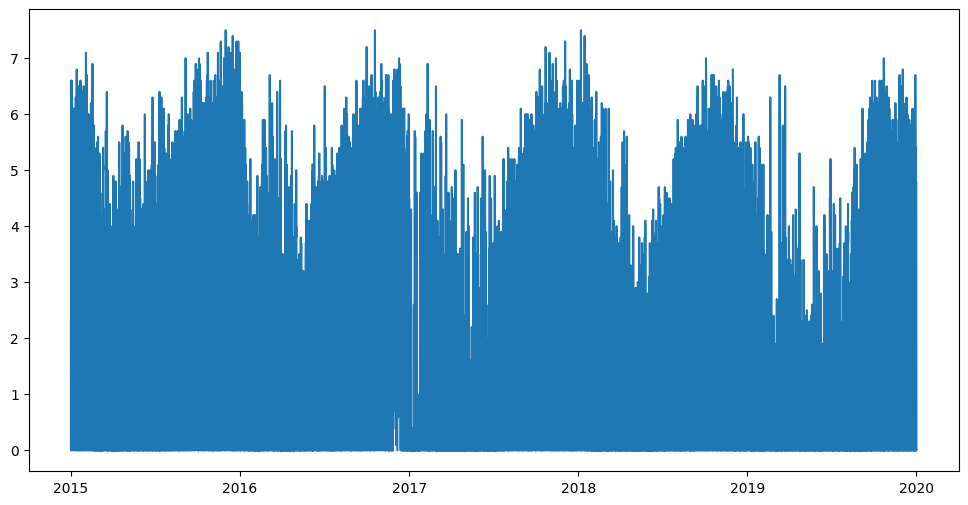

In [760]:
# plot de variável
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_rajada.index,
    df_wo_nan_rajada["vento_velocidade_horaria"],
    label="Velocidade do Vento",
)

b) Identificação de principais buracos de dados (>= 6 horas)

In [761]:
coluna = 'vento_velocidade_horaria'

# Criar uma máscara booleana indicando onde estão os NaNs
nan_mask = df_wo_nan_rajada[coluna].isna()

# Identificar grupos consecutivos de NaNs
nan_groups = (nan_mask != nan_mask.shift()).cumsum()

# Contar o tamanho de cada grupo
group_sizes = nan_mask.groupby(nan_groups).sum()

# Filtrar apenas os grupos de NaNs consecutivos com tamanho >= 6
nan_consecutivos = group_sizes[group_sizes >= 6]

# Ordenar os grupos em ordem decrescente de tamanho
nan_consecutivos = nan_consecutivos.sort_values(ascending=False)

# Obter os índices exatos dos valores NaN nos grupos consecutivos (>= 6) em ordem decrescente de tamanho
nan_indices = [df_wo_nan_rajada.index[nan_mask & (nan_groups == group)].tolist()
               for group in nan_consecutivos.index]

# Exibir os resultados em ordem decrescente de tamanho
for i, (group_size, indices) in enumerate(zip(nan_consecutivos, nan_indices), start=1):
    print(f"Grupo {i}:")
    print(f"Índices dos NaNs consecutivos com tamanho >= 6:\n{indices}")
    print(f"Tamanho: {group_size}\n")

Grupo 1:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2017-02-10 23:00:00'), Timestamp('2017-02-11 00:00:00'), Timestamp('2017-02-11 01:00:00'), Timestamp('2017-02-11 02:00:00'), Timestamp('2017-02-11 03:00:00'), Timestamp('2017-02-11 04:00:00'), Timestamp('2017-02-11 05:00:00'), Timestamp('2017-02-11 06:00:00'), Timestamp('2017-02-11 07:00:00'), Timestamp('2017-02-11 08:00:00'), Timestamp('2017-02-11 09:00:00'), Timestamp('2017-02-11 10:00:00'), Timestamp('2017-02-11 11:00:00'), Timestamp('2017-02-11 12:00:00'), Timestamp('2017-02-11 13:00:00'), Timestamp('2017-02-11 14:00:00')]
Tamanho: 16

Grupo 2:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2016-12-11 18:00:00'), Timestamp('2016-12-11 19:00:00'), Timestamp('2016-12-11 20:00:00'), Timestamp('2016-12-11 21:00:00'), Timestamp('2016-12-11 22:00:00'), Timestamp('2016-12-11 23:00:00'), Timestamp('2016-12-12 00:00:00'), Timestamp('2016-12-12 01:00:00'), Timestamp('2016-12-12 02:00:00'), Timestamp('2016-12-12

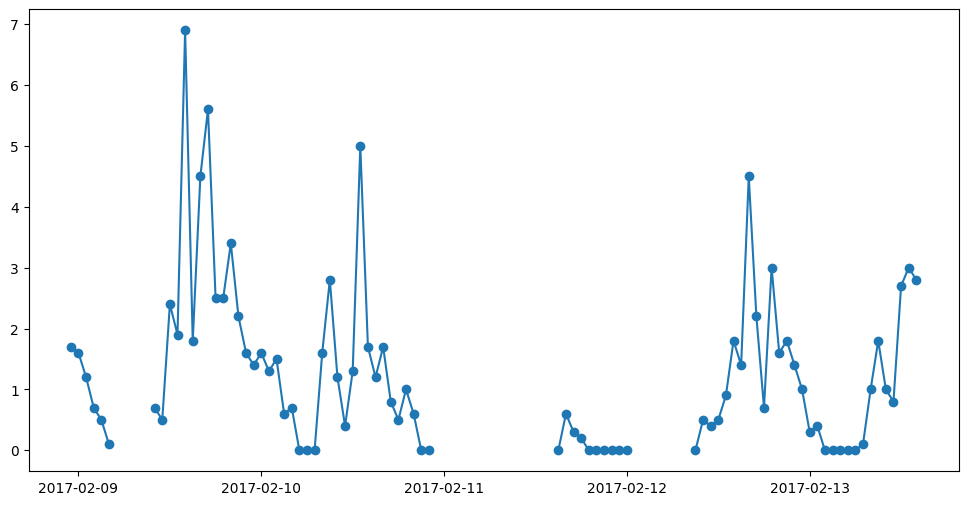

In [762]:
# print de dados gap mais importante
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_rajada.loc["2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna],
    marker="o",
)

In [763]:
# tamanho do maior gap
maior_gap = nan_consecutivos.max()

proporcao = maior_gap/len(df_wo_nan_rajada)*100

print(f"Proporção de NaNs do maior gap da coluna {coluna} \nem relação ao total: \n{proporcao:.2f}%")

Proporção de NaNs do maior gap da coluna vento_velocidade_horaria 
em relação ao total: 
0.04%


c) Input de dados para maiores buracos (>= 1 dia ou 24h)

In [764]:
df_wo_nan_windspeed = imputar_grandes_buracos(
    df_wo_nan_rajada, coluna, nan_consecutivos
)

Nenhum grupo de NaNs consecutivos maior que 24 foi encontrado.


**Analisando sazonalidade**

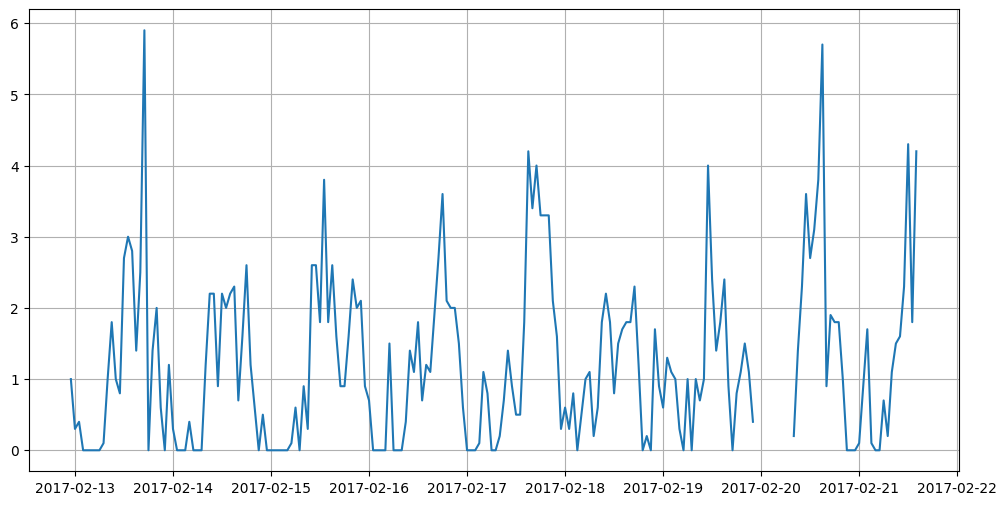

In [765]:
# print de dados entre gap
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_rajada.loc["2017-02-12 23:00:00":"2017-02-21 14:00:00", coluna],
)
# grid
plt.grid(True)

**Obs.:** Temos uma quantidade maior de dados faltantes do que as variáveis de Pressão e Temperatura, mas ainda assim menor do que 5% dos dados. ENTRETANTO, temos uma sazonalidade. Dessa forma não faz muito sentido simplesmente interpolar, a não ser para intervalos de dados faltantes menores que a metade do que 1/4 do período

A SAZONALIDADE parece ter período de 1 dia. Então realizaremos interpolação para intervalos menores que 6 horas e inputaremos a média para períodos maiores que isso.

In [766]:
# Filtrar grupos com menos de 6 e maiores ou iguais a 6 NaNs consecutivos (1/4 de período)
grupos_menores_6 = group_sizes[group_sizes < 6].index
grupos_maiores_ou_iguais_6 = group_sizes[
    (group_sizes >= 6) & (group_sizes < 24)
].index

In [767]:
# Aplicar interpolação nos grupos menores que 6
for group in grupos_menores_6:
    indices = nan_mask & (nan_groups == group)
    df_wo_nan_windspeed.loc[indices, coluna] = df_wo_nan_windspeed[coluna].interpolate(method='linear')

# Preencher os grupos maiores ou iguais a 6 com a média da coluna
media_coluna = df_wo_nan_windspeed[coluna].mean()
for group in grupos_maiores_ou_iguais_6:
    indices = nan_mask & (nan_groups == group)
    df_wo_nan_windspeed.loc[indices, coluna] = media_coluna

# Verificar o resultado final
print(df_wo_nan_windspeed[coluna].isna().sum())  # Deve ser 0 se todos os buracos forem tratados

0


In [768]:
media_coluna

1.708913998022943

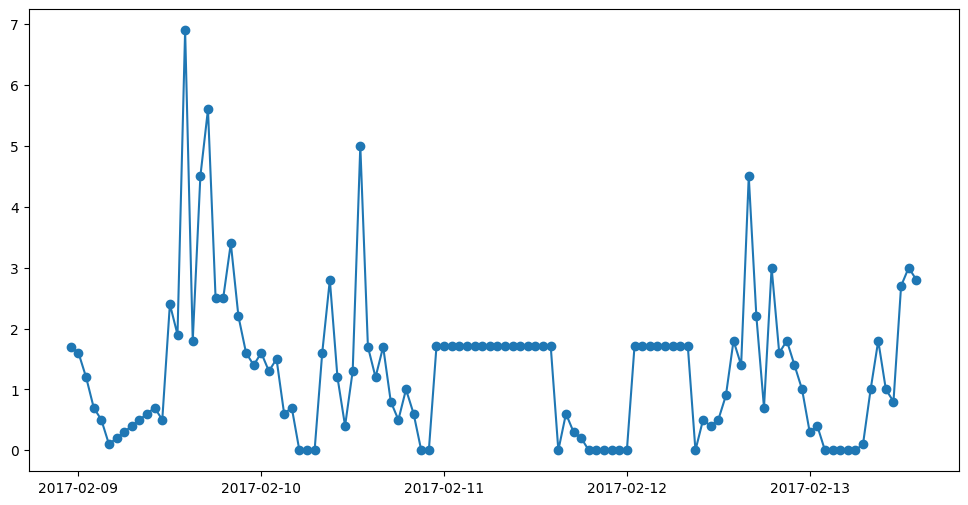

In [769]:
# print de dados gap mais importante
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_windspeed.loc[
        "2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna
    ],
    marker="o",
)

In [770]:
df_wo_nan_windspeed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 43824 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43824 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43824 non-null  float64
 3   umidade_relativa_ar_horaria                43824 non-null  float64
 4   vento_direcao_horaria                      43824 non-null  float64
 5   vento_rajada_maxima                        43824 non-null  float64
 6   vento_velocidade_horaria                   43824 non-null  float64
 7   radiacao_global                            41296 non-null  float64
 8   year                                       43824 non-null  int32  
 9   hora                                       43824 no

#### 3.5.7. Radiação Global

a) Plot de variável

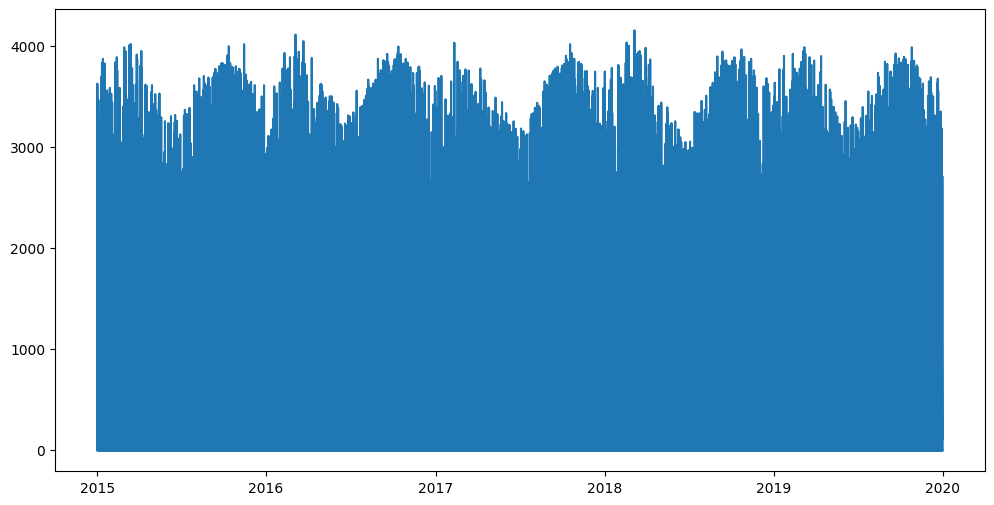

In [771]:
# plot de variável
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_windspeed.index,
    df_wo_nan_windspeed["radiacao_global"],
    label="Radiação Global",
)

b) Identificação de principais buracos de dados (>= 6 horas)

In [772]:
coluna = 'radiacao_global'

# Criar uma máscara booleana indicando onde estão os NaNs
nan_mask = df_wo_nan_windspeed[coluna].isna()

# Identificar grupos consecutivos de NaNs
nan_groups = (nan_mask != nan_mask.shift()).cumsum()

# Contar o tamanho de cada grupo
group_sizes = nan_mask.groupby(nan_groups).sum()

# Filtrar apenas os grupos de NaNs consecutivos com tamanho >= 6
nan_consecutivos = group_sizes[group_sizes >= 6]

# Ordenar os grupos em ordem decrescente de tamanho
nan_consecutivos = nan_consecutivos.sort_values(ascending=False)

# Obter os índices exatos dos valores NaN nos grupos consecutivos (>= 6) em ordem decrescente de tamanho
nan_indices = [df_wo_nan_windspeed.index[nan_mask & (nan_groups == group)].tolist()
               for group in nan_consecutivos.index]

# Exibir os resultados em ordem decrescente de tamanho
for i, (group_size, indices) in enumerate(zip(nan_consecutivos, nan_indices), start=1):
    print(f"Grupo {i}:")
    print(f"Índices dos NaNs consecutivos com tamanho >= 6:\n{indices}")
    print(f"Tamanho: {group_size}\n")

Grupo 1:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2017-02-11 05:00:00'), Timestamp('2017-02-11 06:00:00'), Timestamp('2017-02-11 07:00:00'), Timestamp('2017-02-11 08:00:00'), Timestamp('2017-02-11 09:00:00'), Timestamp('2017-02-11 10:00:00'), Timestamp('2017-02-11 11:00:00'), Timestamp('2017-02-11 12:00:00'), Timestamp('2017-02-11 13:00:00'), Timestamp('2017-02-11 14:00:00')]
Tamanho: 10

Grupo 2:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2016-12-18 05:00:00'), Timestamp('2016-12-18 06:00:00'), Timestamp('2016-12-18 07:00:00'), Timestamp('2016-12-18 08:00:00'), Timestamp('2016-12-18 09:00:00'), Timestamp('2016-12-18 10:00:00'), Timestamp('2016-12-18 11:00:00')]
Tamanho: 7

Grupo 3:
Índices dos NaNs consecutivos com tamanho >= 6:
[Timestamp('2016-12-14 05:00:00'), Timestamp('2016-12-14 06:00:00'), Timestamp('2016-12-14 07:00:00'), Timestamp('2016-12-14 08:00:00'), Timestamp('2016-12-14 09:00:00'), Timestamp('2016-12-14 10:00:00')]
Tamanho: 6

Grupo 4

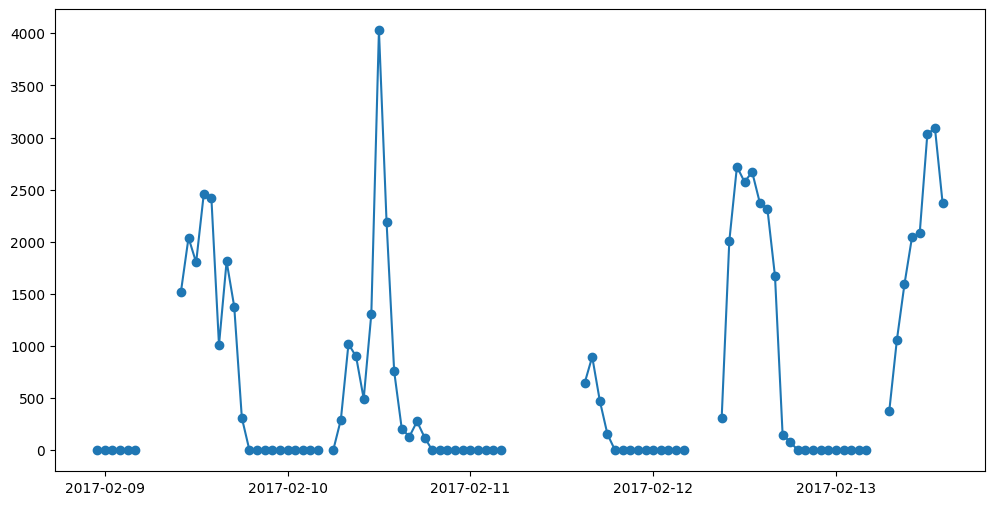

In [773]:
# print de dados gap mais importante
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_windspeed.loc["2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna],
    marker="o",
)

In [774]:
# tamanho do maior gap
maior_gap = nan_consecutivos.max()

proporcao = maior_gap/len(df_wo_nan_windspeed)*100

print(f"Proporção de NaNs do maior gap da coluna {coluna} \nem relação ao total: \n{proporcao:.2f}%")

Proporção de NaNs do maior gap da coluna radiacao_global 
em relação ao total: 
0.02%


c) Input de dados para maiores buracos (>= 1 dia ou 24h)

In [775]:
df_wo_nan_radiation = imputar_grandes_buracos(
    df_wo_nan_windspeed, coluna, nan_consecutivos
)

Nenhum grupo de NaNs consecutivos maior que 24 foi encontrado.


d) input dos demais gaps via interpolação e/ou média

**Analisando sazonalidade**

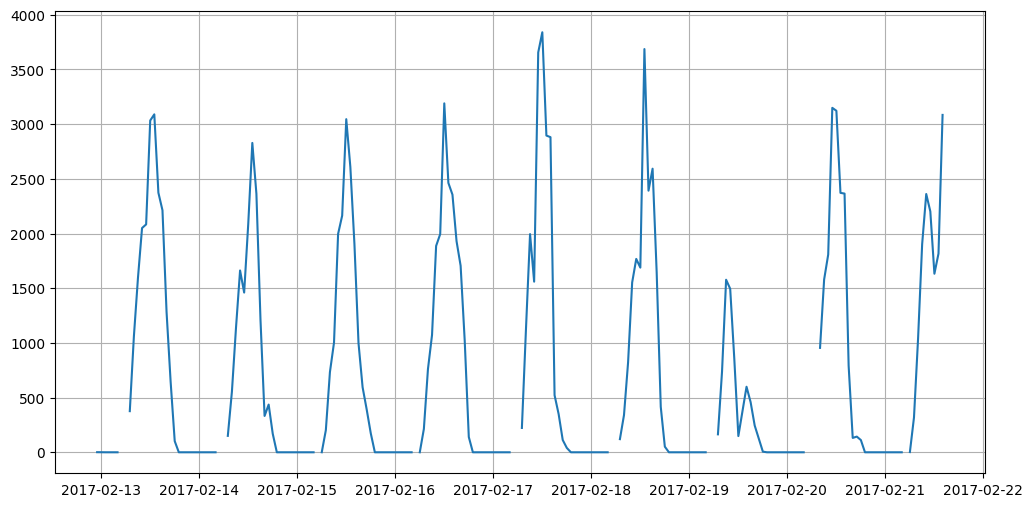

In [776]:
# print de dados entre gap
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_windspeed.loc["2017-02-12 23:00:00":"2017-02-21 14:00:00", coluna],
)
# grid
plt.grid(True)

**Obs.:** Temos uma quantidade maior de dados faltantes do que as variáveis de Pressão e Temperatura, mas ainda assim menor do que 5% dos dados. ENTRETANTO, temos uma sazonalidade. Dessa forma não faz muito sentido simplesmente interpolar, a não ser para intervalos de dados faltantes menores que a metade do que 1/4 do período

A SAZONALIDADE parece ter período de 1 dia. Então realizaremos interpolação para intervalos menores que 6 horas e inputaremos a média para períodos maiores que isso.

Além disso, logicamente, faz sentido físico essa sazonalidade diária (nascer/por do sol)

In [777]:
# Filtrar grupos com menos de 6 e maiores ou iguais a 6 NaNs consecutivos (1/4 de período)
grupos_menores_6 = group_sizes[group_sizes < 6].index
grupos_maiores_ou_iguais_6 = group_sizes[
    (group_sizes >= 6) & (group_sizes < 24)
].index

In [778]:
# Aplicar interpolação nos grupos menores que 6
for group in grupos_menores_6:
    indices = nan_mask & (nan_groups == group)
    df_wo_nan_radiation.loc[indices, coluna] = df_wo_nan_radiation[coluna].interpolate(method='linear')

# Preencher os grupos maiores ou iguais a 6 com a média da coluna
media_coluna = df_wo_nan_radiation[coluna].mean()
for group in grupos_maiores_ou_iguais_6:
    indices = nan_mask & (nan_groups == group)
    df_wo_nan_radiation.loc[indices, coluna] = media_coluna

# Verificar o resultado final
print(df_wo_nan_radiation[coluna].isna().sum())  # Deve ser 0 se todos os buracos forem tratados

0


In [779]:
media_coluna

833.4590068281989

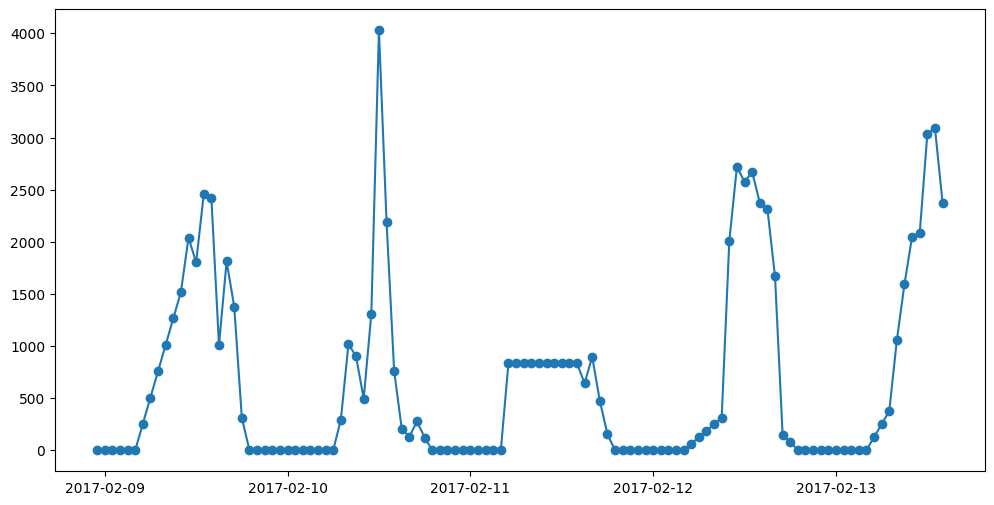

In [780]:
# print de dados gap mais importante
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_radiation.loc[
        "2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna
    ],
    marker="o",
)

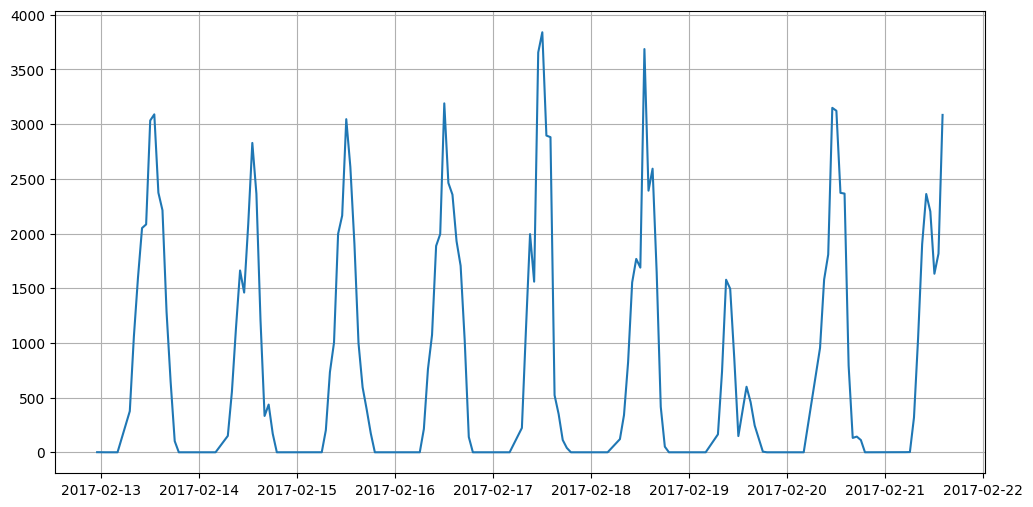

In [781]:
# print de dados entre gap
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_radiation.loc["2017-02-12 23:00:00":"2017-02-21 14:00:00", coluna],
)
# grid
plt.grid(True)

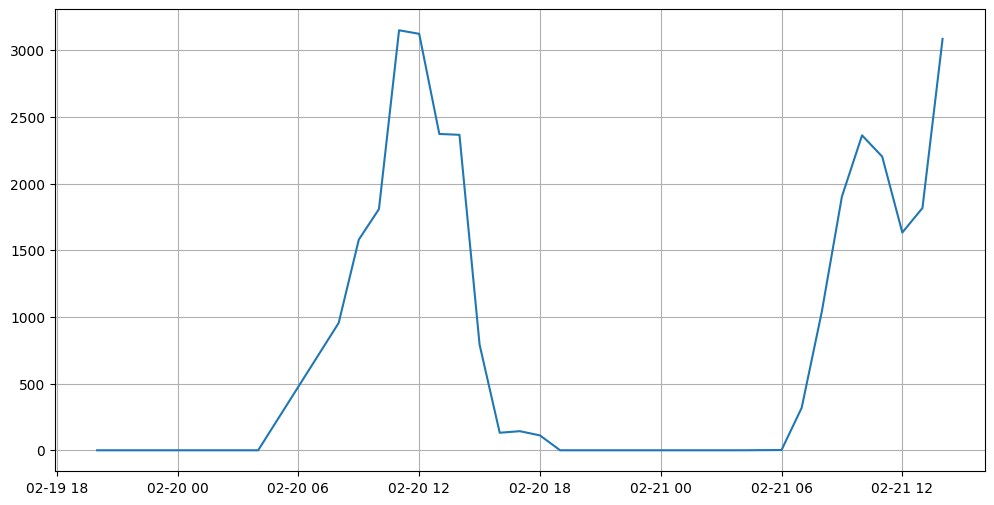

In [782]:
plt.figure(figsize=(12, 6))

plt.plot(
    df_wo_nan_radiation.loc["2017-02-19 20:00:00":"2017-02-21 14:00:00", coluna],
)
# grid
plt.grid(True)

In [783]:
df_preprocessed = df_wo_nan_radiation.copy()

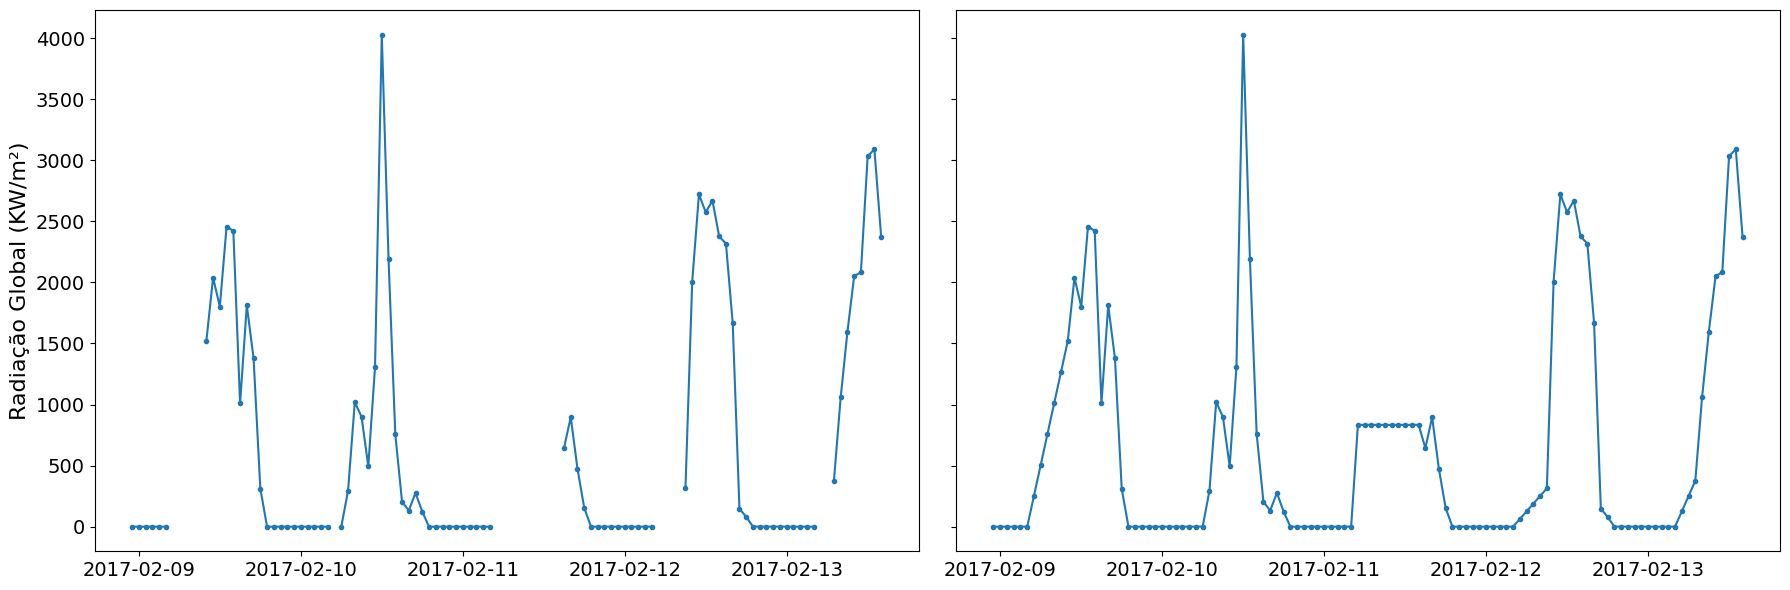

In [784]:
# Criando os subgráficos lado a lado (2 gráficos, 1 linha) com eixo y compartilhado
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot do primeiro gráfico (Umidade)
ax[0].plot(
    df_wo_nan_humidity.loc["2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna],
    marker=".",
)
ax[0].set_ylabel("Radiação Global (KW/m²)", fontsize=16)  # Tamanho da fonte do eixo y
# ax[0].set_xlabel("Data", fontsize=14)  # Tamanho da fonte do eixo x
ax[0].tick_params(axis='both', labelsize=14)  # Tamanho das fontes dos ticks

# Plot do segundo gráfico (Radiação Global)
ax[1].plot(
    df_wo_nan_radiation.loc["2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna],
    marker=".",
)
# ax[1].set_ylabel("Radiação Global (KW/m²)", fontsize=16)  # Tamanho da fonte do eixo y
# ax[1].set_xlabel("Data", fontsize=14)  # Tamanho da fonte do eixo x
ax[1].tick_params(axis='both', labelsize=14)  # Tamanho das fontes dos ticks

# Ajustando o layout para que os gráficos não sobreponham
plt.tight_layout()

# Exibição dos gráficos
plt.show()

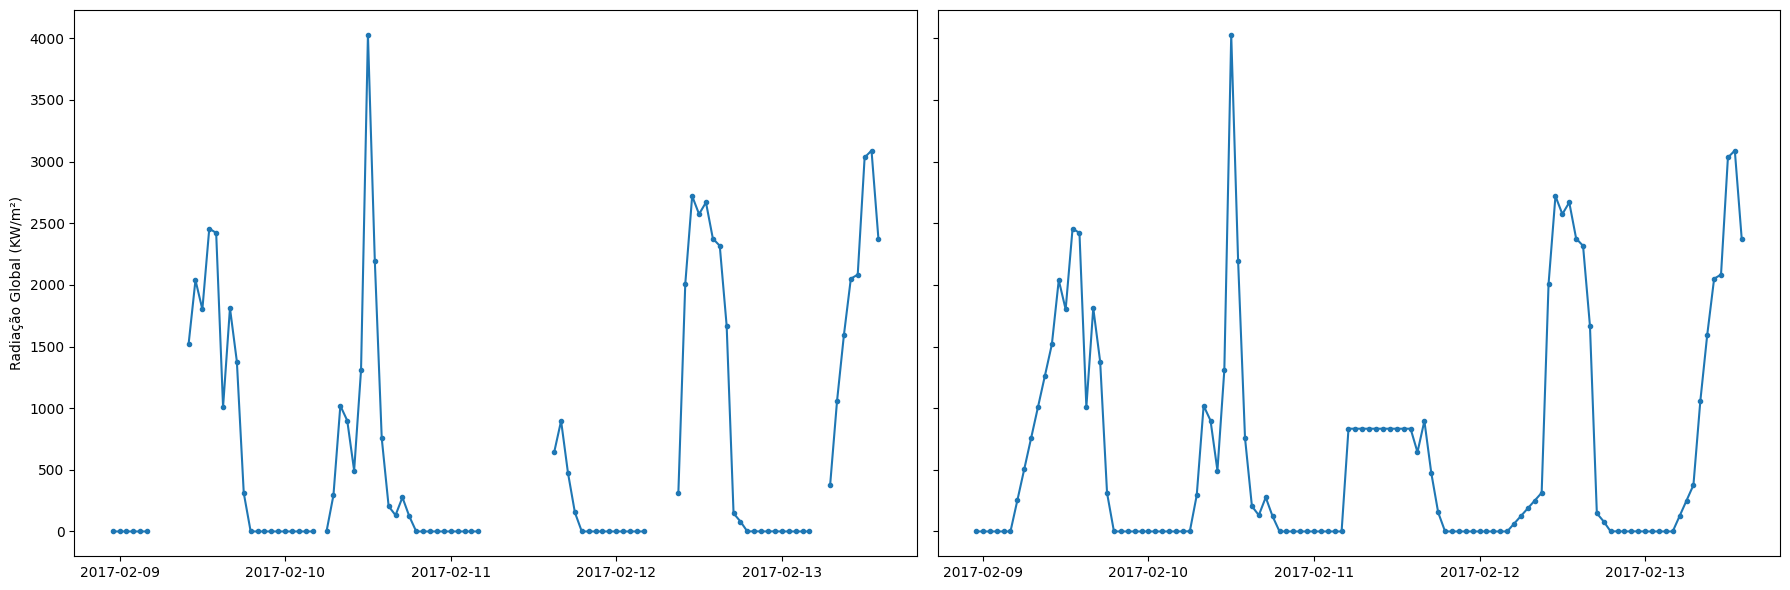

In [785]:
# Criando os subgráficos lado a lado (2 gráficos, 1 linha) com eixo y compartilhado
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot do primeiro gráfico (Umidade)
ax[0].plot(
    df_wo_nan_humidity.loc["2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna],
    marker=".",
)
ax[0].set_ylabel("Radiação Global (KW/m²)")

# Plot do segundo gráfico (Radiação Global)
ax[1].plot(
    df_wo_nan_radiation.loc["2017-02-08 23:00:00":"2017-02-13 14:00:00", coluna],
    marker=".",
)

# Ajustando o layout para que os gráficos não sobreponham
plt.tight_layout()

# Exibição dos gráficos
plt.show()

### 3.6. Export dos dados pré-processados

In [786]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 43824 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43824 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43824 non-null  float64
 3   umidade_relativa_ar_horaria                43824 non-null  float64
 4   vento_direcao_horaria                      43824 non-null  float64
 5   vento_rajada_maxima                        43824 non-null  float64
 6   vento_velocidade_horaria                   43824 non-null  float64
 7   radiacao_global                            43824 non-null  float64
 8   year                                       43824 non-null  int32  
 9   hora                                       43824 no

In [787]:
# export to csv
output_filename = (
    "preprocessed_data"
    + "_"
    + config["input_data_parameters"]["codigo_wmo"]
    + "_"
    + config["input_data_parameters"]["estacao"]
    + ".csv"
)
output_path = config["output_directory_preprocessing"]
df_preprocessed.to_csv(output_path + "/" + output_filename)

# Correlações - ideias

1. **Temperatura do Ar (bulbo seco) e Umidade Relativa do Ar**:
   - **Correlação esperada**: Inversa. Em condições normais, à medida que a **temperatura do ar** aumenta, a **umidade relativa** tende a diminuir. O ar quente pode reter mais vapor d'água, então a umidade relativa cai, mesmo que a quantidade absoluta de vapor d'água seja constante.
   - **Exemplo**: Dias quentes frequentemente têm menor umidade relativa.

2. **Temperatura do Ponto de Orvalho e Umidade Relativa do Ar**:
   - **Correlação esperada**: Positiva. Quanto mais próximo o ponto de orvalho está da temperatura do ar, maior é a **umidade relativa**. Quando a temperatura do ponto de orvalho se aproxima da temperatura do ar, o ar está próximo da saturação.
   - **Exemplo**: Se a diferença entre o ponto de orvalho e a temperatura do ar for pequena, a umidade será alta.

3. **Pressão Atmosférica e Precipitação**:
   - **Correlação esperada**: Inversa. Quando a **pressão atmosférica** é baixa, há uma maior probabilidade de **precipitação**. Sistemas de baixa pressão estão associados a tempestades e frentes frias, que trazem chuvas.
   - **Exemplo**: Antes de uma tempestade, a pressão atmosférica frequentemente cai.

4. **Radiação Global e Temperatura do Ar (bulbo seco)**:
   - **Correlação esperada**: Positiva. Em dias de maior **radiação solar**, espera-se que a **temperatura do ar** aumente, especialmente em regiões com baixa cobertura de nuvens.
   - **Exemplo**: Dias ensolarados normalmente têm temperaturas mais altas.

5. **Velocidade do Vento e Rajada Máxima de Vento**:
   - **Correlação esperada**: Positiva. A **velocidade média do vento** durante o dia tende a estar relacionada com a **intensidade das rajadas**. Dias ventosos normalmente têm rajadas de maior intensidade.
   - **Exemplo**: Se o vento é forte durante o dia, as rajadas provavelmente também serão intensas.

6. **Precipitação e Umidade Relativa**:
   - **Correlação esperada**: Positiva. Durante ou após a **precipitação**, a **umidade relativa do ar** tende a aumentar, pois o ar se satura com a evaporação da água das superfícies molhadas.
   - **Exemplo**: Após uma chuva, a umidade tende a estar alta.

7. **Precipitação e Temperatura do Ponto de Orvalho**:
   - **Correlação esperada**: Positiva. Quando o **ponto de orvalho** está mais próximo da **temperatura do ar**, há maior probabilidade de condensação, o que pode resultar em **chuvas**.
   - **Exemplo**: Tempestades ocorrem quando o ponto de orvalho está alto, indicando condições úmidas.

8. **Pressão Atmosférica e Velocidade do Vento**:
   - **Correlação esperada**: Inversa. Sistemas de baixa pressão tendem a gerar ventos mais fortes, pois o ar se move de áreas de alta pressão para áreas de baixa pressão.
   - **Exemplo**: Durante tempestades ou ciclones, a pressão atmosférica cai, e os ventos aumentam.

9. **Temperatura Máxima e Temperatura Mínima**:
   - **Correlação esperada**: Positiva. Locais que têm temperaturas máximas mais elevadas tendem a ter temperaturas mínimas também mais altas, uma vez que a atmosfera retém calor à noite.
   - **Exemplo**: Regiões tropicais podem ter pequenas variações entre as temperaturas máximas e mínimas diárias.

10. **Radiação Global e Umidade Relativa**:
   - **Correlação esperada**: Inversa. Dias com maior **radiação solar** geralmente têm menor **umidade relativa**, pois o aquecimento do ar reduz a umidade relativa.
   - **Exemplo**: Dias muito ensolarados frequentemente têm baixa umidade relativa, especialmente no meio da tarde.